# INFO-F-422 -  Statistical Foundations of Machine Learning 

### Frank Jordan Kuete Kamta - __[Frank.Jordan.Kuete.Kamta@ulb.be](mailto:Frank.Jordan.Kuete.Kamta@ulb.be) - Student ID 000492547__
### Vicent Moltó Gallego - __[vicent.molto.gallego@ulb.be](mailto:vicent.molto.gallego@ulb.be) - Student ID 000540389__
### Andrew Karam - __[andrew.karam@ulb.be](mailto:andrew.karam@ulb.be) - Student ID 000425393__

### Video presentation: https://youtu.be/8T4XHB6qamI

## Flu Shot Learning: Predict H1N1 and Seasonal Flu Vaccines


# Introduction


The goal of this project is to predict whether people got H1N1 and seasonal flu vaccines using information they shared about their backgrounds, opinions, and health behaviors. That is, we will be predicting two probabilities: H1N1 vaccine and seasonal vaccine. In order to do so, we will use the data from the National 2009 H1N1 Flu Survey (NHFS). This data will be provided by DrivenData. In addition, they also created an open competition to see who can do a better prediction.

In order to make the predictions and complete the project, we will first do some data preprocessing, as well as feature engineering and selection. We will try several methods to see which one works better. Once that is done, we will use the features selected to create three different learning models, chosen from the ones seen during the course and using the specified packages. After that, we will generate a fourth model, which will be a new model, different from the ones seen during the exercise sessions.

Finally, we will asses which model performs better, and then use the test data to make our predictions using our best model and submit our results to the DrivenData competition.

## Libraries used
The following are the libraries that we used during the development of this project. We also set the seed for the randomness generation.

In [1]:
install.packages("devtools")
install.packages("ggplot2")
install.packages("rpart")
install.packages("rpart.plot")
install.packages("nnet")
install.packages("randomForest")
install.packages("gbm")
install.packages("RSNNS")
install.packages("kernlab")

library(devtools)
library(ggplot2)
library(rpart)
library(rpart.plot)
library(nnet)
library(randomForest)
library(gbm)
library(RSNNS)
library(kernlab)

set.seed(2)


The downloaded binary packages are in
	/var/folders/7m/4hsycwb57hq4y57yld7wck0m0000gn/T//Rtmpj9yvT6/downloaded_packages

The downloaded binary packages are in
	/var/folders/7m/4hsycwb57hq4y57yld7wck0m0000gn/T//Rtmpj9yvT6/downloaded_packages

The downloaded binary packages are in
	/var/folders/7m/4hsycwb57hq4y57yld7wck0m0000gn/T//Rtmpj9yvT6/downloaded_packages

The downloaded binary packages are in
	/var/folders/7m/4hsycwb57hq4y57yld7wck0m0000gn/T//Rtmpj9yvT6/downloaded_packages

The downloaded binary packages are in
	/var/folders/7m/4hsycwb57hq4y57yld7wck0m0000gn/T//Rtmpj9yvT6/downloaded_packages

The downloaded binary packages are in
	/var/folders/7m/4hsycwb57hq4y57yld7wck0m0000gn/T//Rtmpj9yvT6/downloaded_packages

The downloaded binary packages are in
	/var/folders/7m/4hsycwb57hq4y57yld7wck0m0000gn/T//Rtmpj9yvT6/downloaded_packages

The downloaded binary packages are in
	/var/folders/7m/4hsycwb57hq4y57yld7wck0m0000gn/T//Rtmpj9yvT6/downloaded_packages

The downloaded binary packages 

Loading required package: usethis

randomForest 4.7-1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


Loaded gbm 2.1.8

Loading required package: Rcpp


Attaching package: ‘kernlab’


The following object is masked from ‘package:ggplot2’:

    alpha




# Data preprocessing

The first step is to consider as non attributed (NA) the values that are not present in the dataset, to do so while using the read.csv function we use the na.strings parameters with the list of every string that should be considered as non attributed. Here it's the empty char, the space and "NA".

We have 3 CSV file of data here:
1. The one that we are going to use to train our models, the data_training. We'll use this one because we know the output for these input. 
2. The output for data_training is in the data_training_results variable.
3. The last CSV file, loaded in the data_test_set_features variable is the data that our model is gonna treat as input and try to predict the output.

In [2]:
data_test <- read.csv("./test_set_features.csv", header=TRUE, stringsAsFactors=FALSE, na.strings=c(""," ", "NA"))
data_training <- read.csv("./training_set_features.csv", header=TRUE, stringsAsFactors=FALSE, na.strings=c(""," ", "NA"))
data_training_results <- read.csv("./training_set_labels.csv", header=TRUE, stringsAsFactors=FALSE, na.strings=c(""," ", "NA"))

#create a virgin copy of data_test for later use
intact_data_test <- read.csv("./test_set_features.csv", header=TRUE, stringsAsFactors=FALSE, na.strings=c(""," ", "NA"))


## Missing value imputation
We see that the dimension of data_training is 26707 data samples where each data samples is a vector of 36 values. The problem is that since there are a lot of components per individuals, it's frequent that they don't answer every questions which lead to a lot of Non-Attributed value. By omiting data samples that don't answer each questions we miss a lot of valuable values we go from 26707 to 6437 samples. Tha same has been done with the data which will be used for the testing. For each one of the steps for the preprocessing, we will do the same with both datasets, training and test.

In [3]:
dim(data_training)
dim(na.omit(data_training))
dim(data_test)
dim(na.omit(data_test))

[1] 26707    36

[1] 6437   36

[1] 26708    36

[1] 6499   36

The reason for this great loss of data is that some samples don't answer every part of the questionnaire, for example the job they exerce, some people exerce no jobs and thus give no answer. When one answer isn't given for one sample all his other answers are discarded. Is that a reason to omit their value? No. Let's load the csv files withtout ommiting blank spaces.

Here is an histogram of the number of Non-Attributed value per lines.
It is clear that the concentration of samples are around low values, thus there are in general more than 30 columns of features to be analyzed and exploit information from for our domain.

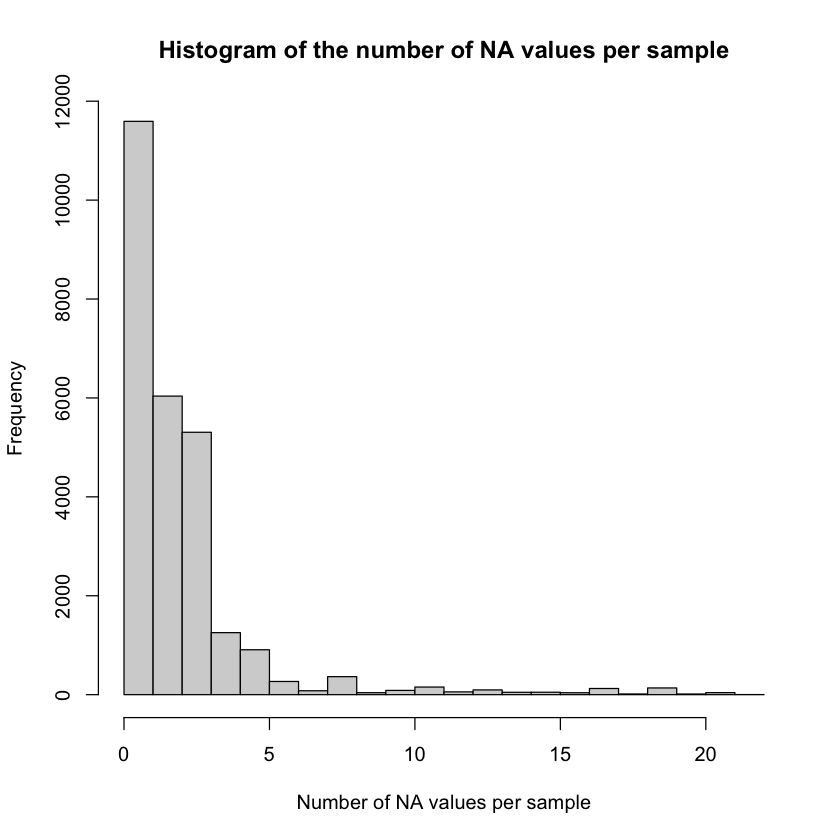

In [4]:
data_training$na_count <- apply(data_training, 1, function(x) sum(is.na(x)))
hist(data_training$na_count, main="Histogram of the number of NA values per sample", xlab="Number of NA values per sample")
data_training$na_count <- NULL

### Transform character columns of the data in factor columns

This will allow a better treatment of the information based on the advantages of factors:

In [5]:
data_training[sapply(data_training, is.character)] <- lapply(data_training[sapply(data_training, is.character)], as.factor)
data_test[sapply(data_test, is.character)] <- lapply(data_test[sapply(data_test, is.character)], as.factor)

### Remove the factor column to compute the median for NA values

In [6]:
factor_variables_training<-which(sapply(data_training[1,],class)=="factor")
int_variables_training<-which(sapply(data_training[1,],class)=="integer")
data_preprocessed_training<-data_training[,-factor_variables_training]
dim(data_preprocessed_training)
dim(na.omit(data_preprocessed_training))

[1] 26707    24

[1] 13506    24

In [7]:
factor_variables_test<-which(sapply(data_test[1,],class)=="factor")
int_variables_test<-which(sapply(data_test[1,],class)=="integer")
data_preprocessed_test<-data_test[,-factor_variables_test]
dim(data_preprocessed_test)
dim(na.omit(data_preprocessed_test))

[1] 26708    24

[1] 13513    24

We observe thanks to the na.omit method that no values are omitted anymore in the integer columns.

In [8]:
replace_na_with_median_value<-function(vec) {
    median_vec<-median(vec,na.rm=T)
    vec[is.na(vec)]<-median_vec
    vec
}

In [9]:
data_preprocessed_training<-data.frame(apply(data_preprocessed_training,2,replace_na_with_median_value)) #caution this line convert to numeric values
data_preprocessed_training[sapply(data_preprocessed_training, is.numeric)] <- lapply(data_preprocessed_training[sapply(data_preprocessed_training, is.numeric)], as.integer) #we retranslate to integer
dim(na.omit(data_preprocessed_training))

[1] 26707    24

In [10]:
data_preprocessed_test<-data.frame(apply(data_preprocessed_test,2,replace_na_with_median_value)) #caution this line convert to numeric values
data_preprocessed_test[sapply(data_preprocessed_test, is.numeric)] <- lapply(data_preprocessed_test[sapply(data_preprocessed_test, is.numeric)], as.integer) #we retranslate to integer
dim(na.omit(data_preprocessed_test))

[1] 26708    24

Replacing the numeric data with NA values in data_training by their median values.

With that, we already have saved 5500 data samples from being dumped.

In [11]:
dim(na.omit(data_training))
data_training[,-factor_variables_training]<-data_preprocessed_training
dim(na.omit(data_training))

[1] 6437   36

[1] 11942    36

In [12]:
dim(na.omit(data_test))
data_test[,-factor_variables_test]<-data_preprocessed_test
dim(na.omit(data_test))

[1] 6499   36

[1] 11982    36

Now we proceed to replace the factor NA values by their mode values.

In [13]:
get_mode <- function(v) {
    uniqv <- unique(v)
    uniqv[which.max(tabulate(match(v, uniqv)))]
}

In [14]:
replace_na_with_mode_value<-function(vec) {
    mode_vec<-get_mode(na.omit(vec))
    vec[is.na(vec)]<-mode_vec
    vec
}

We first remove the numeric values. We observe we loose a lot of information if we just dropped the rows that have NA values, so we replace them.

In [15]:
data_preprocessed_training<-data_training[,-int_variables_training]
dim(data_preprocessed_training)
dim(na.omit(data_preprocessed_training))

[1] 26707    12

[1] 11942    12

In [16]:
data_preprocessed_test<-data_test[,-int_variables_test]
dim(data_preprocessed_test)
dim(na.omit(data_preprocessed_test))

[1] 26708    12

[1] 11982    12

In [17]:
data_preprocessed_training$age_group<-replace_na_with_mode_value(data_preprocessed_training$age_group)
data_preprocessed_training$education<-replace_na_with_mode_value(data_preprocessed_training$education)
data_preprocessed_training$race<-replace_na_with_mode_value(data_preprocessed_training$race)
data_preprocessed_training$sex<-replace_na_with_mode_value(data_preprocessed_training$sex)
data_preprocessed_training$income_poverty<-replace_na_with_mode_value(data_preprocessed_training$income_poverty)
data_preprocessed_training$marital_status<-replace_na_with_mode_value(data_preprocessed_training$marital_status)
data_preprocessed_training$rent_or_own<-replace_na_with_mode_value(data_preprocessed_training$rent_or_own)
data_preprocessed_training$employment_status<-replace_na_with_mode_value(data_preprocessed_training$employment_status)
data_preprocessed_training$hhs_geo_region<-replace_na_with_mode_value(data_preprocessed_training$hhs_geo_region)
data_preprocessed_training$census_msa<-replace_na_with_mode_value(data_preprocessed_training$census_msa)
data_preprocessed_training$employment_industry<-replace_na_with_mode_value(data_preprocessed_training$employment_industry)
data_preprocessed_training$employment_occupation<-replace_na_with_mode_value(data_preprocessed_training$employment_occupation)

In [18]:
data_preprocessed_test$age_group<-replace_na_with_mode_value(data_preprocessed_test$age_group)
data_preprocessed_test$education<-replace_na_with_mode_value(data_preprocessed_test$education)
data_preprocessed_test$race<-replace_na_with_mode_value(data_preprocessed_test$race)
data_preprocessed_test$sex<-replace_na_with_mode_value(data_preprocessed_test$sex)
data_preprocessed_test$income_poverty<-replace_na_with_mode_value(data_preprocessed_test$income_poverty)
data_preprocessed_test$marital_status<-replace_na_with_mode_value(data_preprocessed_test$marital_status)
data_preprocessed_test$rent_or_own<-replace_na_with_mode_value(data_preprocessed_test$rent_or_own)
data_preprocessed_test$employment_status<-replace_na_with_mode_value(data_preprocessed_test$employment_status)
data_preprocessed_test$hhs_geo_region<-replace_na_with_mode_value(data_preprocessed_test$hhs_geo_region)
data_preprocessed_test$census_msa<-replace_na_with_mode_value(data_preprocessed_test$census_msa)
data_preprocessed_test$employment_industry<-replace_na_with_mode_value(data_preprocessed_test$employment_industry)
data_preprocessed_test$employment_occupation<-replace_na_with_mode_value(data_preprocessed_test$employment_occupation)

In [19]:
dim(na.omit(data_preprocessed_training))
dim(na.omit(data_preprocessed_test))

[1] 26707    12

[1] 26708    12

In [20]:
dim(na.omit(data_training))
data_training[,-int_variables_training]<-data_preprocessed_training
dim(na.omit(data_training))

[1] 11942    36

[1] 26707    36

In [21]:
dim(na.omit(data_test))
data_test[,-int_variables_test]<-data_preprocessed_test
dim(na.omit(data_test))

[1] 11982    36

[1] 26708    36

As we can see, after replacing all NA values, we can use all the data from the set.

## Feature engineering
Since some models are not able to handle correctly categorical variables, we need to change them into numerical ones. 
### Useless features removal
To start, first we check if any of the categorical variables has only one possible values. If so, we will remove them since they don't bring any information. Again, we will do the same procedure with both the training and the test sets.

In [22]:
for (n in colnames(data_training[,-int_variables_training])) {
    l <- nlevels(data_training[,n])
    if (l < 2) {
        print(n)
        print(data_training[1,n])
    }
}

In [23]:
for (n in colnames(data_test[,-int_variables_test])) {
    l <- nlevels(data_test[,n])
    if (l < 2) {
        print(n)
        print(data_test[1,n])
    }
}

In our case, all categorical variables can take more than just one value, so we are not removing none of them since they are considered useful. 
### Checking for binary features
Next, we check for the ones that have just two values.

In [24]:
for (n in colnames(data_training[,-int_variables_training])) {
    l <- nlevels(data_training[,n])
    if (l == 2) {
        print(n)
        print(data_training[1,n])
    }
}

[1] "sex"
[1] Female
Levels: Female Male
[1] "marital_status"
[1] Not Married
Levels: Married Not Married
[1] "rent_or_own"
[1] Own
Levels: Own Rent


In [25]:
for (n in colnames(data_test[,-int_variables_test])) {
    l <- nlevels(data_test[,n])
    if (l == 2) {
        print(n)
        print(data_test[1,n])
    }
}

[1] "sex"
[1] Female
Levels: Female Male
[1] "marital_status"
[1] Not Married
Levels: Married Not Married
[1] "rent_or_own"
[1] Rent
Levels: Own Rent


There are three variables that can take only two values. These two can be converted into binary variables without creating any more features. We proceed to do so:

In [26]:
create_binary_features <- function(df) {
#Converts features of the test set to binary (0-1)
    #feature sex
    levels(df$sex) <- c(levels(df$sex), "1","0")
    df$sex[df$sex == "Female"] <- 1
    df$sex[df$sex != "1"] <- 0
    df <- transform(df, sex = as.integer(as.character(sex)))
    #feature marital_status
    levels(df$marital_status) <- c(levels(df$marital_status), "1","0")
    df$marital_status[df$marital_status == "Married"] <- 1
    df$marital_status[df$marital_status != "1"] <- 0
    df <- transform(df, marital_status = as.integer(as.character(marital_status)))
    #feature rent_or_own
    levels(df$rent_or_own) <- c(levels(df$rent_or_own), "1","0")
    df$rent_or_own[df$rent_or_own == "Own"] <- 1
    df$rent_or_own[df$rent_or_own != "1"] <- 0
    df <- transform(df, rent_or_own = as.integer(as.character(rent_or_own)))
    return(df)
}

In [27]:
data_training<-create_binary_features(data_training)
head(data_training)

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,⋯,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<fct>,<int>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<fct>,<fct>
1,0,1,0,0,0,0,0,0,1,1,⋯,Below Poverty,0,1,Not in Labor Force,oxchjgsf,Non-MSA,0,0,fcxhlnwr,xtkaffoo
2,1,3,2,0,1,0,1,0,1,1,⋯,Below Poverty,0,0,Employed,bhuqouqj,"MSA, Not Principle City",0,0,pxcmvdjn,xgwztkwe
3,2,1,1,0,1,0,0,0,0,0,⋯,"<= $75,000, Above Poverty",0,1,Employed,qufhixun,"MSA, Not Principle City",2,0,rucpziij,xtkaffoo
4,3,1,1,0,1,0,1,1,0,0,⋯,Below Poverty,0,0,Not in Labor Force,lrircsnp,"MSA, Principle City",0,0,fcxhlnwr,xtkaffoo
5,4,2,1,0,1,0,1,1,0,1,⋯,"<= $75,000, Above Poverty",1,1,Employed,qufhixun,"MSA, Not Principle City",1,0,wxleyezf,emcorrxb
6,5,3,1,0,1,0,1,0,0,1,⋯,"<= $75,000, Above Poverty",1,1,Employed,atmpeygn,"MSA, Principle City",2,3,saaquncn,vlluhbov


In [28]:
data_test<-create_binary_features(data_test)
head(data_test)

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,⋯,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<fct>,<int>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<fct>,<fct>
1,26707,2,2,0,1,0,1,1,0,1,⋯,"> $75,000",0,0,Employed,mlyzmhmf,"MSA, Not Principle City",1,0,atmlpfrs,hfxkjkmi
2,26708,1,1,0,0,0,0,0,0,0,⋯,Below Poverty,0,0,Employed,bhuqouqj,Non-MSA,3,0,atmlpfrs,xqwwgdyp
3,26709,2,2,0,0,1,1,1,1,1,⋯,"> $75,000",1,1,Employed,lrircsnp,Non-MSA,1,0,nduyfdeo,pvmttkik
4,26710,1,1,0,0,0,0,0,0,0,⋯,"<= $75,000, Above Poverty",1,1,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1,0,fcxhlnwr,xtkaffoo
5,26711,3,1,1,1,0,1,1,1,1,⋯,"<= $75,000, Above Poverty",0,1,Employed,lzgpxyit,Non-MSA,0,1,fcxhlnwr,mxkfnird
6,26712,2,2,0,1,0,1,1,0,1,⋯,"> $75,000",0,1,Employed,mlyzmhmf,"MSA, Principle City",0,2,fcxhlnwr,cmhcxjea


### Scaling caterogical variables
Next, we proceed to do integer encoding with the categorical variables which could be scaled.

In [29]:
int_variables_training<-which(sapply(data_training[1,],class)=="integer")
head(data_training[,-int_variables_training])

,age_group,education,race,income_poverty,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,55 - 64 Years,< 12 Years,White,Below Poverty,Not in Labor Force,oxchjgsf,Non-MSA,fcxhlnwr,xtkaffoo
2,35 - 44 Years,12 Years,White,Below Poverty,Employed,bhuqouqj,"MSA, Not Principle City",pxcmvdjn,xgwztkwe
3,18 - 34 Years,College Graduate,White,"<= $75,000, Above Poverty",Employed,qufhixun,"MSA, Not Principle City",rucpziij,xtkaffoo
4,65+ Years,12 Years,White,Below Poverty,Not in Labor Force,lrircsnp,"MSA, Principle City",fcxhlnwr,xtkaffoo
5,45 - 54 Years,Some College,White,"<= $75,000, Above Poverty",Employed,qufhixun,"MSA, Not Principle City",wxleyezf,emcorrxb
6,65+ Years,12 Years,White,"<= $75,000, Above Poverty",Employed,atmpeygn,"MSA, Principle City",saaquncn,vlluhbov


In [30]:
int_variables_test<-which(sapply(data_test[1,],class)=="integer")
head(data_test[,-int_variables_test])

,age_group,education,race,income_poverty,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,35 - 44 Years,College Graduate,Hispanic,"> $75,000",Employed,mlyzmhmf,"MSA, Not Principle City",atmlpfrs,hfxkjkmi
2,18 - 34 Years,12 Years,White,Below Poverty,Employed,bhuqouqj,Non-MSA,atmlpfrs,xqwwgdyp
3,55 - 64 Years,College Graduate,White,"> $75,000",Employed,lrircsnp,Non-MSA,nduyfdeo,pvmttkik
4,65+ Years,12 Years,White,"<= $75,000, Above Poverty",Not in Labor Force,lrircsnp,"MSA, Not Principle City",fcxhlnwr,xtkaffoo
5,35 - 44 Years,12 Years,Black,"<= $75,000, Above Poverty",Employed,lzgpxyit,Non-MSA,fcxhlnwr,mxkfnird
6,45 - 54 Years,College Graduate,White,"> $75,000",Employed,mlyzmhmf,"MSA, Principle City",fcxhlnwr,cmhcxjea


It would make sense to encode the variables "age_group" and "income_poverty". For the "age_group" we will assign lower numbers to the lowest range of age, and for the "income_poverty" the lowest number will correspond to the value "Below poverty", and so on. We print the possible values those variables can take so we can encode them properly.

In [31]:
print(levels(data_training$age_group))
print(levels(data_training$income_poverty))

[1] "18 - 34 Years" "35 - 44 Years" "45 - 54 Years" "55 - 64 Years"
[5] "65+ Years"    
[1] "<= $75,000, Above Poverty" "> $75,000"                
[3] "Below Poverty"            


In [32]:
print(levels(data_test$age_group))
print(levels(data_test$income_poverty))

[1] "18 - 34 Years" "35 - 44 Years" "45 - 54 Years" "55 - 64 Years"
[5] "65+ Years"    
[1] "<= $75,000, Above Poverty" "> $75,000"                
[3] "Below Poverty"            


In [33]:
create_int_features <- function(df) {
    #feature age_group
    levels(df$age_group) <- c(levels(df$age_group), "0","1","2","3","4")
    df$age_group[df$age_group == "18 - 34 Years"] <- 0
    df$age_group[df$age_group == "35 - 44 Years"] <- 1
    df$age_group[df$age_group == "45 - 54 Years"] <- 2
    df$age_group[df$age_group == "55 - 64 Years"] <- 3
    df$age_group[df$age_group == "65+ Years"] <- 4
    df <- transform(df, age_group = as.integer(as.character(age_group)))
    #feature income_poverty
    levels(df$income_poverty) <- c(levels(df$income_poverty), "0","1","2")
    df$income_poverty[df$income_poverty == "Below Poverty"] <- 0
    df$income_poverty[df$income_poverty == "<= $75,000, Above Poverty"] <- 1
    df$income_poverty[df$income_poverty == "> $75,000"] <- 2
    df <- transform(df, income_poverty = as.integer(as.character(income_poverty)))
    return(df)
}

In [34]:
data_training<-create_int_features(data_training)
head(data_training[,-int_variables_training])
int_variables_training<-which(sapply(data_training[1,],class)=="integer")
head(data_training[,-int_variables_training])

,age_group,education,race,income_poverty,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
,<int>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>
1,3,< 12 Years,White,0,Not in Labor Force,oxchjgsf,Non-MSA,fcxhlnwr,xtkaffoo
2,1,12 Years,White,0,Employed,bhuqouqj,"MSA, Not Principle City",pxcmvdjn,xgwztkwe
3,0,College Graduate,White,1,Employed,qufhixun,"MSA, Not Principle City",rucpziij,xtkaffoo
4,4,12 Years,White,0,Not in Labor Force,lrircsnp,"MSA, Principle City",fcxhlnwr,xtkaffoo
5,2,Some College,White,1,Employed,qufhixun,"MSA, Not Principle City",wxleyezf,emcorrxb
6,4,12 Years,White,1,Employed,atmpeygn,"MSA, Principle City",saaquncn,vlluhbov


,education,race,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,< 12 Years,White,Not in Labor Force,oxchjgsf,Non-MSA,fcxhlnwr,xtkaffoo
2,12 Years,White,Employed,bhuqouqj,"MSA, Not Principle City",pxcmvdjn,xgwztkwe
3,College Graduate,White,Employed,qufhixun,"MSA, Not Principle City",rucpziij,xtkaffoo
4,12 Years,White,Not in Labor Force,lrircsnp,"MSA, Principle City",fcxhlnwr,xtkaffoo
5,Some College,White,Employed,qufhixun,"MSA, Not Principle City",wxleyezf,emcorrxb
6,12 Years,White,Employed,atmpeygn,"MSA, Principle City",saaquncn,vlluhbov


In [35]:
data_test<-create_int_features(data_test)
head(data_test[,-int_variables_test])
int_variables_test<-which(sapply(data_test[1,],class)=="integer")
head(data_test[,-int_variables_test])

,age_group,education,race,income_poverty,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
,<int>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>
1,1,College Graduate,Hispanic,2,Employed,mlyzmhmf,"MSA, Not Principle City",atmlpfrs,hfxkjkmi
2,0,12 Years,White,0,Employed,bhuqouqj,Non-MSA,atmlpfrs,xqwwgdyp
3,3,College Graduate,White,2,Employed,lrircsnp,Non-MSA,nduyfdeo,pvmttkik
4,4,12 Years,White,1,Not in Labor Force,lrircsnp,"MSA, Not Principle City",fcxhlnwr,xtkaffoo
5,1,12 Years,Black,1,Employed,lzgpxyit,Non-MSA,fcxhlnwr,mxkfnird
6,2,College Graduate,White,2,Employed,mlyzmhmf,"MSA, Principle City",fcxhlnwr,cmhcxjea


,education,race,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,College Graduate,Hispanic,Employed,mlyzmhmf,"MSA, Not Principle City",atmlpfrs,hfxkjkmi
2,12 Years,White,Employed,bhuqouqj,Non-MSA,atmlpfrs,xqwwgdyp
3,College Graduate,White,Employed,lrircsnp,Non-MSA,nduyfdeo,pvmttkik
4,12 Years,White,Not in Labor Force,lrircsnp,"MSA, Not Principle City",fcxhlnwr,xtkaffoo
5,12 Years,Black,Employed,lzgpxyit,Non-MSA,fcxhlnwr,mxkfnird
6,College Graduate,White,Employed,mlyzmhmf,"MSA, Principle City",fcxhlnwr,cmhcxjea


### Removal of the rest of categorical variables
Next, we print the levels of the rest of the categorical variables in order to see how we can transform them:

In [36]:
print(levels(data_training$education))
print(levels(data_training$race))
print(levels(data_training$employment_status))
print(levels(data_training$hhs_geo_region))
print(levels(data_training$census_msa))
print(levels(data_training$employment_industry))
print(levels(data_training$employment_occupation))

[1] "< 12 Years"       "12 Years"         "College Graduate" "Some College"    
[1] "Black"             "Hispanic"          "Other or Multiple"
[4] "White"            
[1] "Employed"           "Not in Labor Force" "Unemployed"        
 [1] "atmpeygn" "bhuqouqj" "dqpwygqj" "fpwskwrf" "kbazzjca" "lrircsnp"
 [7] "lzgpxyit" "mlyzmhmf" "oxchjgsf" "qufhixun"
[1] "MSA, Not Principle  City" "MSA, Principle City"     
[3] "Non-MSA"                 
 [1] "arjwrbjb" "atmlpfrs" "cfqqtusy" "dotnnunm" "fcxhlnwr" "haxffmxo"
 [7] "ldnlellj" "mcubkhph" "mfikgejo" "msuufmds" "nduyfdeo" "phxvnwax"
[13] "pxcmvdjn" "qnlwzans" "rucpziij" "saaquncn" "vjjrobsf" "wlfvacwt"
[19] "wxleyezf" "xicduogh" "xqicxuve"
 [1] "bxpfxfdn" "ccgxvspp" "cmhcxjea" "dcjcmpih" "dlvbwzss" "emcorrxb"
 [7] "haliazsg" "hfxkjkmi" "hodpvpew" "kldqjyjy" "mxkfnird" "oijqvulv"
[13] "pvmttkik" "qxajmpny" "rcertsgn" "tfqavkke" "ukymxvdu" "uqqtjvyb"
[19] "vlluhbov" "xgwztkwe" "xqwwgdyp" "xtkaffoo" "xzmlyyjv"


In [37]:
print(levels(data_test$education))
print(levels(data_test$race))
print(levels(data_test$employment_status))
print(levels(data_test$hhs_geo_region))
print(levels(data_test$census_msa))
print(levels(data_test$employment_industry))
print(levels(data_test$employment_occupation))

[1] "< 12 Years"       "12 Years"         "College Graduate" "Some College"    
[1] "Black"             "Hispanic"          "Other or Multiple"
[4] "White"            
[1] "Employed"           "Not in Labor Force" "Unemployed"        
 [1] "atmpeygn" "bhuqouqj" "dqpwygqj" "fpwskwrf" "kbazzjca" "lrircsnp"
 [7] "lzgpxyit" "mlyzmhmf" "oxchjgsf" "qufhixun"
[1] "MSA, Not Principle  City" "MSA, Principle City"     
[3] "Non-MSA"                 
 [1] "arjwrbjb" "atmlpfrs" "cfqqtusy" "dotnnunm" "fcxhlnwr" "haxffmxo"
 [7] "ldnlellj" "mcubkhph" "mfikgejo" "msuufmds" "nduyfdeo" "phxvnwax"
[13] "pxcmvdjn" "qnlwzans" "rucpziij" "saaquncn" "vjjrobsf" "wlfvacwt"
[19] "wxleyezf" "xicduogh" "xqicxuve"
 [1] "bxpfxfdn" "ccgxvspp" "cmhcxjea" "dcjcmpih" "dlvbwzss" "emcorrxb"
 [7] "haliazsg" "hfxkjkmi" "hodpvpew" "kldqjyjy" "mxkfnird" "oijqvulv"
[13] "pvmttkik" "qxajmpny" "rcertsgn" "tfqavkke" "ukymxvdu" "uqqtjvyb"
[19] "vlluhbov" "xgwztkwe" "xqwwgdyp" "xtkaffoo" "xzmlyyjv"


The variable "census_msa" could be splitted into two binary variables. We will change the possible values for "census_msa" so that they will be 0 when the value was "Non-MSA" and 1 otherwise. The second new variable will be called "msa_principle_city", and will take value 1 when it is a MSA Principle City and 0 when it's MSA but not a Principle City.

In [38]:
divide_features <- function(df) {
    #feature census_msa
    df$msa_principle_city<-df$census_msa
    levels(df$msa_principle_city) <- c(levels(df$msa_principle_city), "0","1")
    df$msa_principle_city[df$msa_principle_city == "MSA, Principle City"] <- 1
    df$msa_principle_city[df$msa_principle_city != "1"] <- 0
    df <- transform(df, msa_principle_city = as.integer(as.character(msa_principle_city)))
    levels(df$census_msa) <- c(levels(df$census_msa), "0","1")
    df$census_msa[df$census_msa == "Non-MSA"] <- 0
    df$census_msa[df$census_msa != "0"] <- 1
    df <- transform(df, census_msa = as.integer(as.character(census_msa)))
    return(df)
}

In [39]:
data_training<-divide_features(data_training)
head(data_training[,-int_variables_training])
int_variables_training<-which(sapply(data_training[1,],class)=="integer")
head(data_training[,-int_variables_training])

,education,race,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation,msa_principle_city
,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<int>
1,< 12 Years,White,Not in Labor Force,oxchjgsf,0,fcxhlnwr,xtkaffoo,0
2,12 Years,White,Employed,bhuqouqj,1,pxcmvdjn,xgwztkwe,0
3,College Graduate,White,Employed,qufhixun,1,rucpziij,xtkaffoo,0
4,12 Years,White,Not in Labor Force,lrircsnp,1,fcxhlnwr,xtkaffoo,1
5,Some College,White,Employed,qufhixun,1,wxleyezf,emcorrxb,0
6,12 Years,White,Employed,atmpeygn,1,saaquncn,vlluhbov,1


,education,race,employment_status,hhs_geo_region,employment_industry,employment_occupation
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,< 12 Years,White,Not in Labor Force,oxchjgsf,fcxhlnwr,xtkaffoo
2,12 Years,White,Employed,bhuqouqj,pxcmvdjn,xgwztkwe
3,College Graduate,White,Employed,qufhixun,rucpziij,xtkaffoo
4,12 Years,White,Not in Labor Force,lrircsnp,fcxhlnwr,xtkaffoo
5,Some College,White,Employed,qufhixun,wxleyezf,emcorrxb
6,12 Years,White,Employed,atmpeygn,saaquncn,vlluhbov


In [40]:
data_test<-divide_features(data_test)
head(data_test[,-int_variables_test])
int_variables_test<-which(sapply(data_test[1,],class)=="integer")
head(data_test[,-int_variables_test])

,education,race,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation,msa_principle_city
,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<int>
1,College Graduate,Hispanic,Employed,mlyzmhmf,1,atmlpfrs,hfxkjkmi,0
2,12 Years,White,Employed,bhuqouqj,0,atmlpfrs,xqwwgdyp,0
3,College Graduate,White,Employed,lrircsnp,0,nduyfdeo,pvmttkik,0
4,12 Years,White,Not in Labor Force,lrircsnp,1,fcxhlnwr,xtkaffoo,0
5,12 Years,Black,Employed,lzgpxyit,0,fcxhlnwr,mxkfnird,0
6,College Graduate,White,Employed,mlyzmhmf,1,fcxhlnwr,cmhcxjea,1


,education,race,employment_status,hhs_geo_region,employment_industry,employment_occupation
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,College Graduate,Hispanic,Employed,mlyzmhmf,atmlpfrs,hfxkjkmi
2,12 Years,White,Employed,bhuqouqj,atmlpfrs,xqwwgdyp
3,College Graduate,White,Employed,lrircsnp,nduyfdeo,pvmttkik
4,12 Years,White,Not in Labor Force,lrircsnp,fcxhlnwr,xtkaffoo
5,12 Years,Black,Employed,lzgpxyit,fcxhlnwr,mxkfnird
6,College Graduate,White,Employed,mlyzmhmf,fcxhlnwr,cmhcxjea


The variables "employment_status", "education" and "race" can be converted into several binary variables each, a variable for each one of its possible values.

In [41]:
divide_features_each_value <- function(df) {
    #feature employment_status
    df$unemployed<-df$employment_status
    levels(df$unemployed) <- c(levels(df$unemployed), "0","1")
    df$unemployed[df$unemployed == "Unemployed"] <- 1
    df$unemployed[df$unemployed != "1"] <- 0
    df <- transform(df, unemployed = as.integer(as.character(unemployed)))
    df$not_in_labor_force<-df$employment_status
    levels(df$not_in_labor_force) <- c(levels(df$not_in_labor_force), "0","1")
    df$not_in_labor_force[df$not_in_labor_force == "Not in Labor Force"] <- 1
    df$not_in_labor_force[df$not_in_labor_force != "1"] <- 0
    df <- transform(df, not_in_labor_force = as.integer(as.character(not_in_labor_force)))
    df$employed<-df$employment_status
    levels(df$employed) <- c(levels(df$employed), "0","1")
    df$employed[df$employed == "Employed"] <- 1
    df$employed[df$employed != "1"] <- 0
    df <- transform(df, employed = as.integer(as.character(employed)))
    df <- subset(df, select = -c(employment_status))
    
    #feature education
    df$under_twelve_years_education<-df$education
    levels(df$under_twelve_years_education) <- c(levels(df$under_twelve_years_education), "0","1")
    df$under_twelve_years_education[df$under_twelve_years_education == "< 12 Years"] <- 1
    df$under_twelve_years_education[df$under_twelve_years_education != "1"] <- 0
    df <- transform(df, under_twelve_years_education = as.integer(as.character(under_twelve_years_education)))
    df$twelve_years_education<-df$education
    levels(df$twelve_years_education) <- c(levels(df$twelve_years_education), "0","1")
    df$twelve_years_education[df$twelve_years_education == "12 Years"] <- 1
    df$twelve_years_education[df$twelve_years_education != "1"] <- 0
    df <- transform(df, twelve_years_education = as.integer(as.character(twelve_years_education)))
    df$some_college_education<-df$education
    levels(df$some_college_education) <- c(levels(df$some_college_education), "0","1")
    df$some_college_education[df$some_college_education == "Some College"] <- 1
    df$some_college_education[df$some_college_education != "1"] <- 0
    df <- transform(df, some_college_education = as.integer(as.character(some_college_education)))
    df$college_graduate_education<-df$education
    levels(df$college_graduate_education) <- c(levels(df$college_graduate_education), "0","1")
    df$college_graduate_education[df$college_graduate_education == "College Graduate"] <- 1
    df$college_graduate_education[df$college_graduate_education != "1"] <- 0
    df <- transform(df, college_graduate_education = as.integer(as.character(college_graduate_education)))
    df <- subset(df, select = -c(education))
    
    #feature race
    df$is_white_race<-df$race
    levels(df$is_white_race) <- c(levels(df$is_white_race), "0","1")
    df$is_white_race[df$is_white_race == "White"] <- 1
    df$is_white_race[df$is_white_race != "1"] <- 0
    df <- transform(df, is_white_race = as.integer(as.character(is_white_race)))
    df$is_black_race<-df$race
    levels(df$is_black_race) <- c(levels(df$is_black_race), "0","1")
    df$is_black_race[df$is_black_race == "Black"] <- 1
    df$is_black_race[df$is_black_race != "1"] <- 0
    df <- transform(df, is_black_race = as.integer(as.character(is_black_race)))
    df$is_hispanic_race<-df$race
    levels(df$is_hispanic_race) <- c(levels(df$is_hispanic_race), "0","1")
    df$is_hispanic_race[df$is_hispanic_race == "Hispanic"] <- 1
    df$is_hispanic_race[df$is_hispanic_race != "1"] <- 0
    df <- transform(df, is_hispanic_race = as.integer(as.character(is_hispanic_race)))
    df$is_other_or_multiple_race<-df$race
    levels(df$is_other_or_multiple_race) <- c(levels(df$is_other_or_multiple_race), "0","1")
    df$is_other_or_multiple_race[df$is_other_or_multiple_race == "Other or Multiple"] <- 1
    df$is_other_or_multiple_race[df$is_other_or_multiple_race != "1"] <- 0
    df <- transform(df, is_other_or_multiple_race = as.integer(as.character(is_other_or_multiple_race)))
    df <- subset(df, select = -c(race))
    
    return(df)
}

In [42]:
data_training<-divide_features_each_value(data_training)
int_variables_training<-which(sapply(data_training[1,],class)=="integer")
head(data_training[,-int_variables_training])

,hhs_geo_region,employment_industry,employment_occupation
,<fct>,<fct>,<fct>
1,oxchjgsf,fcxhlnwr,xtkaffoo
2,bhuqouqj,pxcmvdjn,xgwztkwe
3,qufhixun,rucpziij,xtkaffoo
4,lrircsnp,fcxhlnwr,xtkaffoo
5,qufhixun,wxleyezf,emcorrxb
6,atmpeygn,saaquncn,vlluhbov


In [43]:
data_test<-divide_features_each_value(data_test)
int_variables_test<-which(sapply(data_test[1,],class)=="integer")
head(data_test[,-int_variables_test])

,hhs_geo_region,employment_industry,employment_occupation
,<fct>,<fct>,<fct>
1,mlyzmhmf,atmlpfrs,hfxkjkmi
2,bhuqouqj,atmlpfrs,xqwwgdyp
3,lrircsnp,nduyfdeo,pvmttkik
4,lrircsnp,fcxhlnwr,xtkaffoo
5,lzgpxyit,fcxhlnwr,mxkfnird
6,mlyzmhmf,fcxhlnwr,cmhcxjea


There are only three more categorical variables left. This have much more different levels: 10, 21 and 23 respectively, from left to right. In this case, we are going to look at the frequency of each one of their values, so we can try to keep the most relevant transforming them into binary variables. We will take a look at the 5 most relevant values.

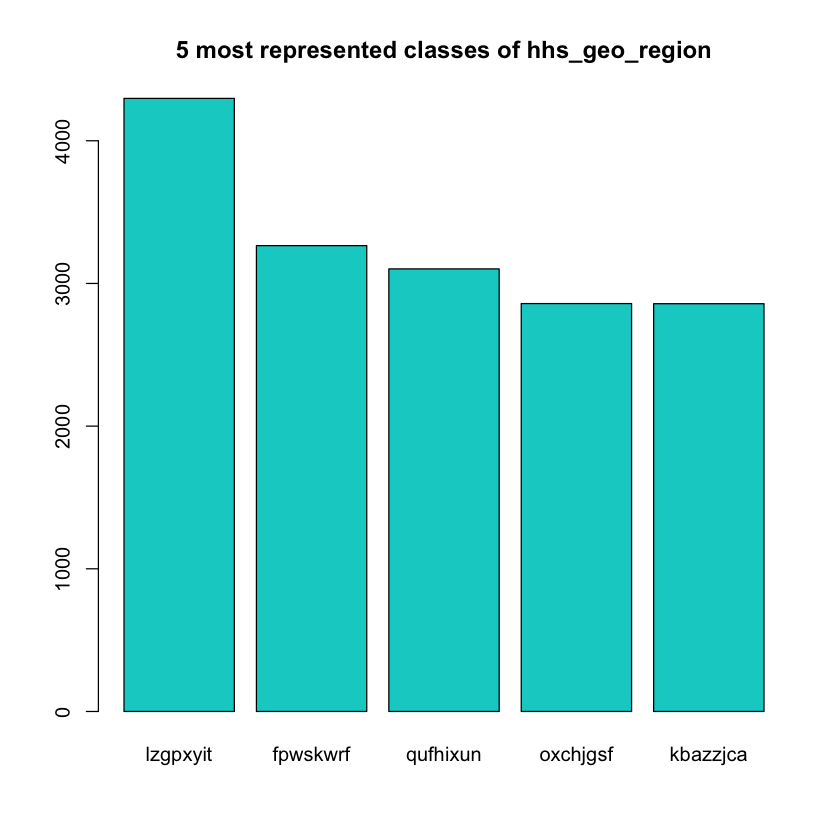

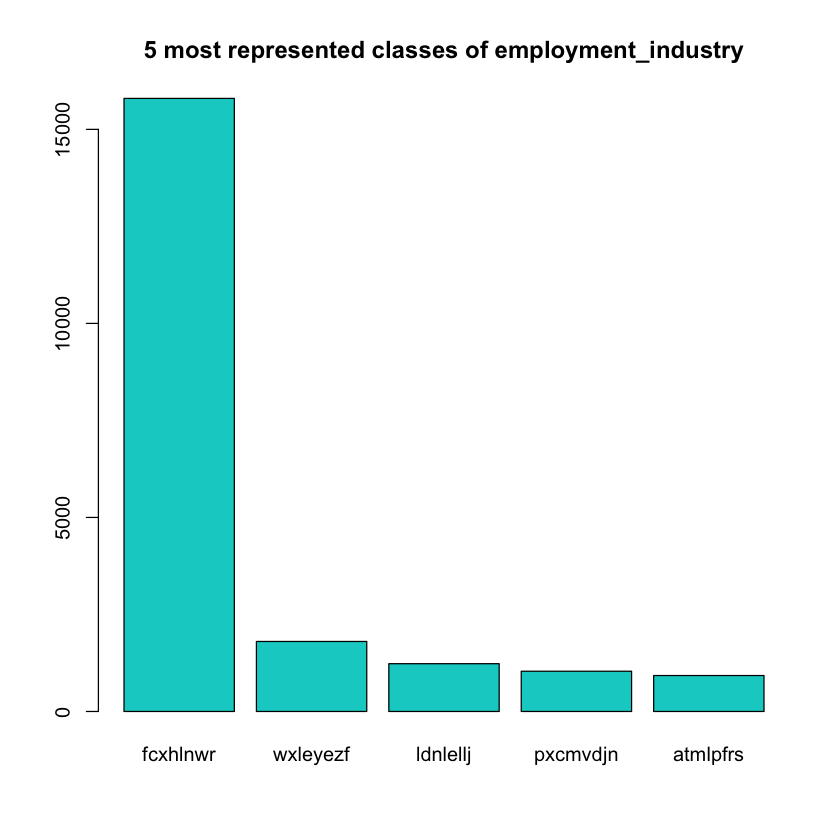

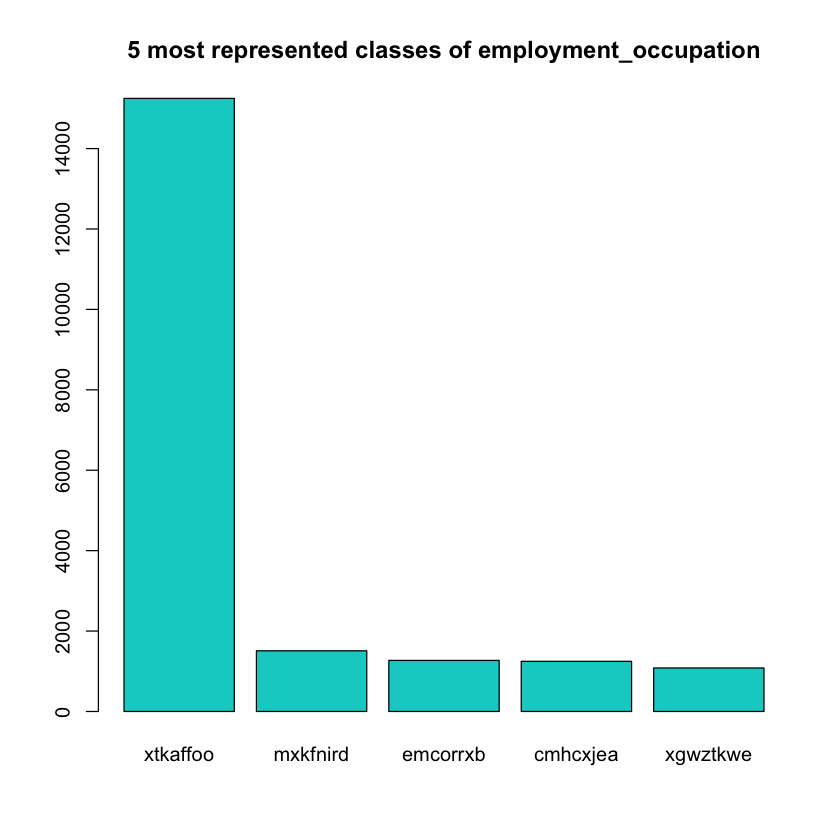

In [44]:
for (f in colnames(data_training[,-int_variables_training])) {
    factors <- table(data_training[,f])
    barplot((sort(factors, decreasing=TRUE)[1:5]),col = "#00cfcc",main=paste("5 most represented classes of",f)) 
}

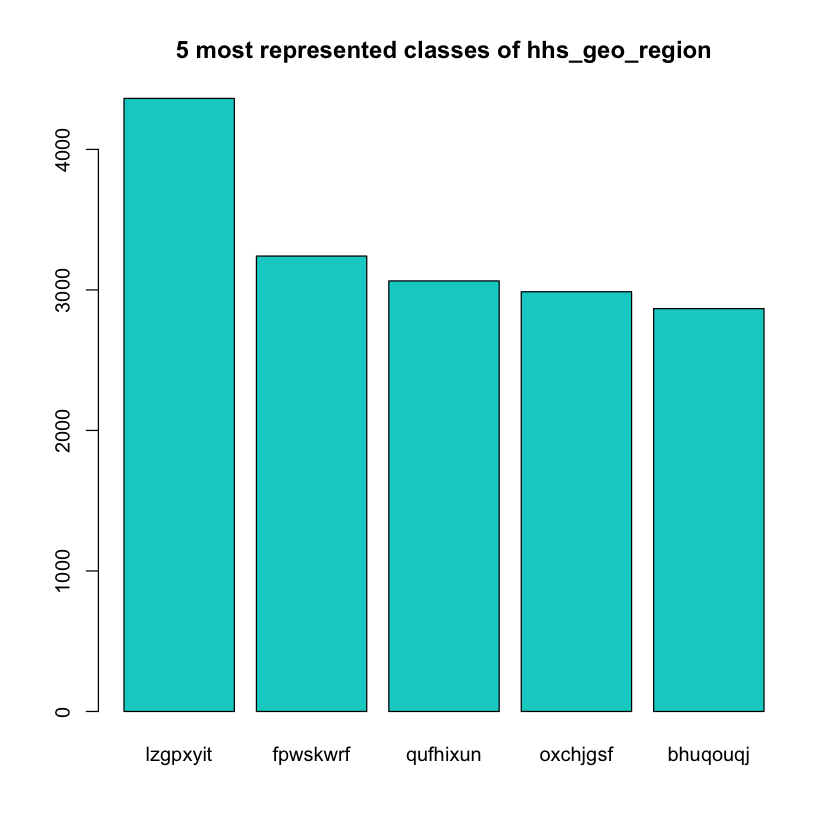

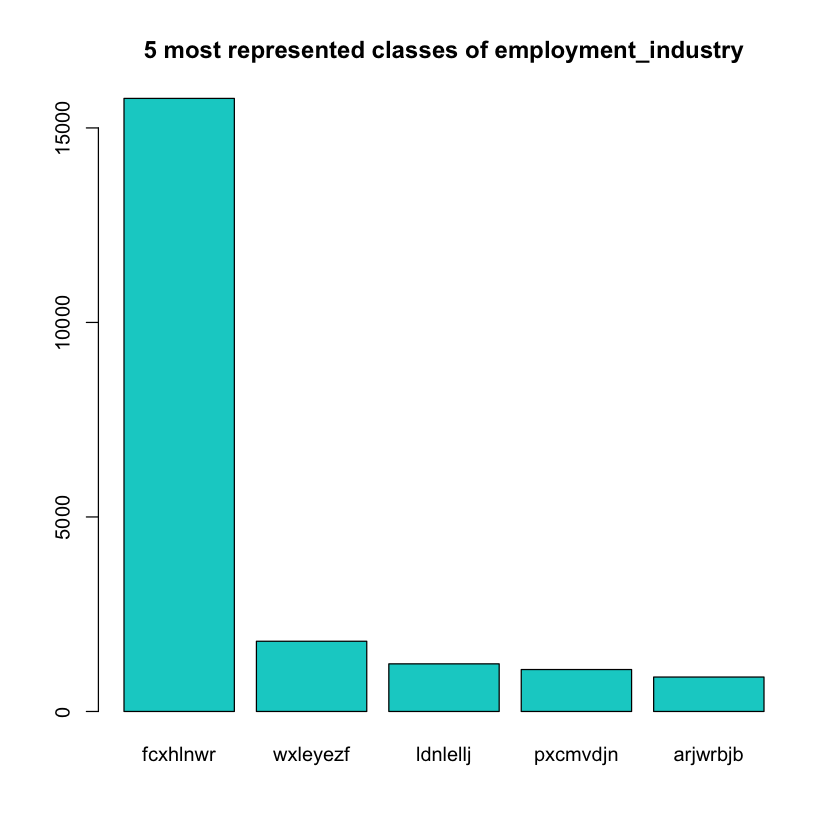

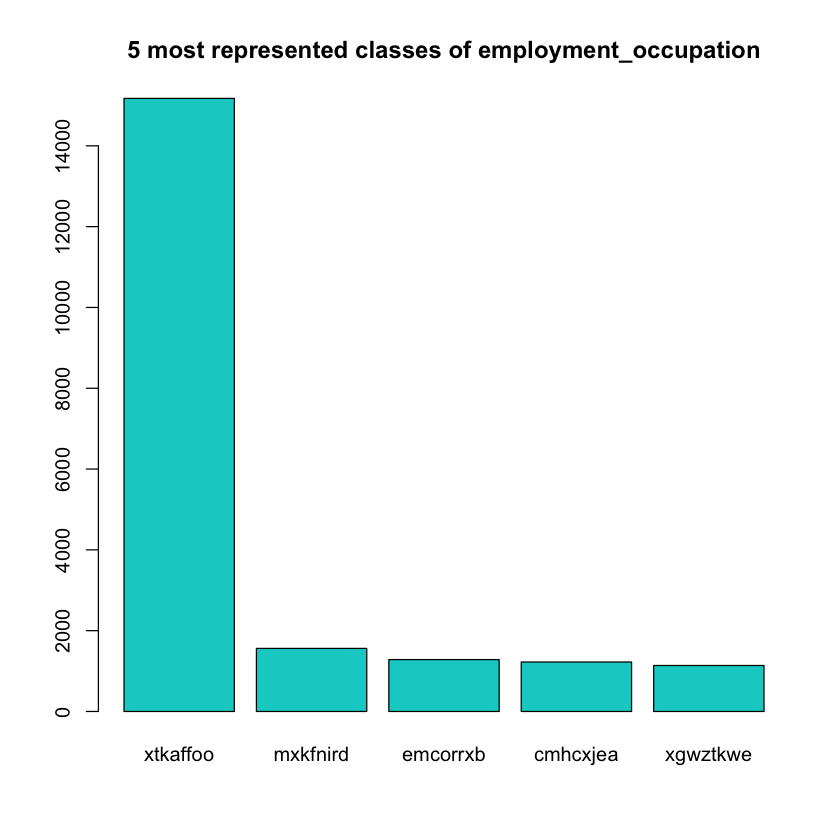

In [45]:
for (f in colnames(data_test[,-int_variables_test])) {
    factors <- table(data_test[,f])
    barplot((sort(factors, decreasing=TRUE)[1:5]),col = "#00cfcc",main=paste("5 most represented classes of",f)) 
}

As we can see in the plots, the same is happening both for test and training data. With the variables "employment_industry" and "employment_ocupation", there's clearly one class which is the most popular one with a huge difference, so we will keep it transforming it into a binary variable. Since the other classes are not that popular, we will drop them because they are too sparse to give meaningful information. Regarding the variable "hhs_geo_region", we see that there is no predominant feature with big difference, but there are rather small differences. In this case, we will keep the ones above 3000 occurrences, which correspond to the 3 most popular classes, and then transform them into binary variables.

In [46]:
keep_most_relevant_classes <- function(df) {
    #feature hhs_geo_region
    df$hhs_geo_region_lzgpxyit<-df$hhs_geo_region
    levels(df$hhs_geo_region_lzgpxyit) <- c(levels(df$hhs_geo_region_lzgpxyit), "0","1")
    df$hhs_geo_region_lzgpxyit[df$hhs_geo_region_lzgpxyit == "lzgpxyit"] <- 1
    df$hhs_geo_region_lzgpxyit[df$hhs_geo_region_lzgpxyit != "1"] <- 0
    df <- transform(df, hhs_geo_region_lzgpxyit = as.integer(as.character(hhs_geo_region_lzgpxyit)))
    df$hhs_geo_region_fpwskwrf<-df$hhs_geo_region
    levels(df$hhs_geo_region_fpwskwrf) <- c(levels(df$hhs_geo_region_fpwskwrf), "0","1")
    df$hhs_geo_region_fpwskwrf[df$hhs_geo_region_fpwskwrf == "fpwskwrf"] <- 1
    df$hhs_geo_region_fpwskwrf[df$hhs_geo_region_fpwskwrf != "1"] <- 0
    df <- transform(df, hhs_geo_region_fpwskwrf = as.integer(as.character(hhs_geo_region_fpwskwrf)))
    df$hhs_geo_region_qufhixun<-df$hhs_geo_region
    levels(df$hhs_geo_region_qufhixun) <- c(levels(df$hhs_geo_region_qufhixun), "0","1")
    df$hhs_geo_region_qufhixun[df$hhs_geo_region_qufhixun == "qufhixun"] <- 1
    df$hhs_geo_region_qufhixun[df$hhs_geo_region_qufhixun != "1"] <- 0
    df <- transform(df, hhs_geo_region_qufhixun = as.integer(as.character(hhs_geo_region_qufhixun)))
    df <- subset(df, select = -c(hhs_geo_region))
    
    #feature employment_industry
    df$employment_industry_fcxhlnwr<-df$employment_industry
    levels(df$employment_industry_fcxhlnwr) <- c(levels(df$employment_industry_fcxhlnwr), "0","1")
    df$employment_industry_fcxhlnwr[df$employment_industry_fcxhlnwr == "fcxhlnwr"] <- 1
    df$employment_industry_fcxhlnwr[df$employment_industry_fcxhlnwr != "1"] <- 0
    df <- transform(df, employment_industry_fcxhlnwr = as.integer(as.character(employment_industry_fcxhlnwr)))
    df <- subset(df, select = -c(employment_industry))
    
    #feature employment_occupation
    df$employment_ocupation_xtkaffoo<-df$employment_occupation
    levels(df$employment_ocupation_xtkaffoo) <- c(levels(df$employment_ocupation_xtkaffoo), "0","1")
    df$employment_ocupation_xtkaffoo[df$employment_ocupation_xtkaffoo == "xtkaffoo"] <- 1
    df$employment_ocupation_xtkaffoo[df$employment_ocupation_xtkaffoo != "1"] <- 0
    df <- transform(df, employment_ocupation_xtkaffoo = as.integer(as.character(employment_ocupation_xtkaffoo)))
    df <- subset(df, select = -c(employment_occupation))
    return(df)
}

In [47]:
data_training<-keep_most_relevant_classes(data_training)
int_variables_training<-which(sapply(data_training[1,],class)=="integer")
head(data_training[,-int_variables_training])

1
2
3
4
5
6


In [48]:
data_test<-keep_most_relevant_classes(data_test)
int_variables_test<-which(sapply(data_test[1,],class)=="integer")
head(data_test[,-int_variables_test])

1
2
3
4
5
6


In [49]:
dim(data_training)
head(data_training)
dim(data_test)
head(data_test)

[1] 26707    47

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,⋯,college_graduate_education,is_white_race,is_black_race,is_hispanic_race,is_other_or_multiple_race,hhs_geo_region_lzgpxyit,hhs_geo_region_fpwskwrf,hhs_geo_region_qufhixun,employment_industry_fcxhlnwr,employment_ocupation_xtkaffoo
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,1,0,0,0,0,0,0,1,1,⋯,0,1,0,0,0,0,0,0,1,1
2,1,3,2,0,1,0,1,0,1,1,⋯,0,1,0,0,0,0,0,0,0,0
3,2,1,1,0,1,0,0,0,0,0,⋯,1,1,0,0,0,0,0,1,0,1
4,3,1,1,0,1,0,1,1,0,0,⋯,0,1,0,0,0,0,0,0,1,1
5,4,2,1,0,1,0,1,1,0,1,⋯,0,1,0,0,0,0,0,1,0,0
6,5,3,1,0,1,0,1,0,0,1,⋯,0,1,0,0,0,0,0,0,0,0


[1] 26708    47

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,⋯,college_graduate_education,is_white_race,is_black_race,is_hispanic_race,is_other_or_multiple_race,hhs_geo_region_lzgpxyit,hhs_geo_region_fpwskwrf,hhs_geo_region_qufhixun,employment_industry_fcxhlnwr,employment_ocupation_xtkaffoo
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,26707,2,2,0,1,0,1,1,0,1,⋯,1,0,0,1,0,0,0,0,0,0
2,26708,1,1,0,0,0,0,0,0,0,⋯,0,1,0,0,0,0,0,0,0,0
3,26709,2,2,0,0,1,1,1,1,1,⋯,1,1,0,0,0,0,0,0,0,0
4,26710,1,1,0,0,0,0,0,0,0,⋯,0,1,0,0,0,0,0,0,1,1
5,26711,3,1,1,1,0,1,1,1,1,⋯,0,0,1,0,0,1,0,0,1,0
6,26712,2,2,0,1,0,1,1,0,1,⋯,1,1,0,0,0,0,0,0,1,0


As we can see, we now have removed all categorical variables transforming them into numerical ones, with a minimum loss of information. That way we can use them directly into any kind of prediction model, since all of them are capable of handling correctly numerical variables.

Finally, we remove one last feature, which in this case would be the "respondent_id". We are removing it because it does not give any information about the variables we want to predict, since it is different for each sample.

In [50]:
data_training <- subset(data_training, select = -c(respondent_id))
data_test <- subset(data_test, select = -c(respondent_id))

In [51]:
dim(data_training)
head(data_training)
dim(data_test)
head(data_test)

[1] 26707    46

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,⋯,college_graduate_education,is_white_race,is_black_race,is_hispanic_race,is_other_or_multiple_race,hhs_geo_region_lzgpxyit,hhs_geo_region_fpwskwrf,hhs_geo_region_qufhixun,employment_industry_fcxhlnwr,employment_ocupation_xtkaffoo
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,0,0,0,0,0,0,1,1,0,⋯,0,1,0,0,0,0,0,0,1,1
2,3,2,0,1,0,1,0,1,1,0,⋯,0,1,0,0,0,0,0,0,0,0
3,1,1,0,1,0,0,0,0,0,0,⋯,1,1,0,0,0,0,0,1,0,1
4,1,1,0,1,0,1,1,0,0,0,⋯,0,1,0,0,0,0,0,0,1,1
5,2,1,0,1,0,1,1,0,1,0,⋯,0,1,0,0,0,0,0,1,0,0
6,3,1,0,1,0,1,0,0,1,0,⋯,0,1,0,0,0,0,0,0,0,0


[1] 26708    46

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,⋯,college_graduate_education,is_white_race,is_black_race,is_hispanic_race,is_other_or_multiple_race,hhs_geo_region_lzgpxyit,hhs_geo_region_fpwskwrf,hhs_geo_region_qufhixun,employment_industry_fcxhlnwr,employment_ocupation_xtkaffoo
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,2,2,0,1,0,1,1,0,1,0,⋯,1,0,0,1,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,⋯,0,1,0,0,0,0,0,0,0,0
3,2,2,0,0,1,1,1,1,1,0,⋯,1,1,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,⋯,0,1,0,0,0,0,0,0,1,1
5,3,1,1,1,0,1,1,1,1,0,⋯,0,0,1,0,0,1,0,0,1,0
6,2,2,0,1,0,1,1,0,1,0,⋯,1,1,0,0,0,0,0,0,1,0


### New data columns based on interpretation of existing columns
First, we can make a new column for the good health habits.

Inverting the touch face values, now it's 1 when behavioral touch face is low. Then, summing this behavioral touch face with the behavioral of washing hands gives a new column. The value is 4 when the sample doesn't touch his face and wash his hands. The value is 0 when it touches his face and doesn't wash his hand. And it's 3 when he does only one of the two good behaviour.

In [52]:
X <- data_training
Y_h1n1 <- data_training_results$h1n1_vaccine
Y_season <- data_training_results$seasonal_vaccine

X_Copy <- X
data_test_Copy <- data_test

In [53]:
  index <- X_Copy$behavioral_touch_face==1
  X_Copy$behavioral_touch_face[index]=0
  X_Copy$behavioral_touch_face[!index]=1
  X_Copy$sum_inverseTouchFace_washHands <- X_Copy$behavioral_touch_face+X_Copy$behavioral_wash_hands
  X_Copy$sum_inverseTouchFace_washHands[X_Copy$sum_inverseTouchFace_washHands==2]=4
  X_Copy$sum_inverseTouchFace_washHands[X_Copy$sum_inverseTouchFace_washHands==1]=3

  index <- data_test_Copy$behavioral_touch_face==1
  data_test_Copy$behavioral_touch_face[index]=0
  data_test_Copy$behavioral_touch_face[!index]=1
  data_test_Copy$sum_inverseTouchFace_washHands <- data_test_Copy$behavioral_touch_face+data_test_Copy$behavioral_wash_hands
  data_test_Copy$sum_inverseTouchFace_washHands[data_test_Copy$sum_inverseTouchFace_washHands==2]=4
  data_test_Copy$sum_inverseTouchFace_washHands[data_test_Copy$sum_inverseTouchFace_washHands==1]=3

H1N1 global opinion can be computed from h1n1 opinion on the effectiveness of the vaccine divided by the opinion risk and the opinion on getting sick from the vacc.
This can be divided directly because there are no 0 values after having verified with the function table().

In [54]:
X_Copy$opinion_global_h1n1 <- X_Copy$opinion_h1n1_vacc_effective / X_Copy$opinion_h1n1_risk / X_Copy$opinion_h1n1_sick_from_vacc
data_test_Copy$opinion_global_h1n1 <- data_test_Copy$opinion_h1n1_vacc_effective / data_test_Copy$opinion_h1n1_risk / data_test_Copy$opinion_h1n1_sick_from_vacc

In [55]:
X_Copy$opinion_global_season <- X_Copy$opinion_seas_vacc_effective / X_Copy$opinion_seas_risk / X_Copy$opinion_seas_sick_from_vacc
data_test_Copy$opinion_global_season <- data_test_Copy$opinion_seas_vacc_effective / data_test_Copy$opinion_seas_risk / data_test_Copy$opinion_seas_sick_from_vacc

Lastly, we can multiply H1N1 concern with knowledge:

In [56]:
X_Copy$h1n1_knowledge_time_concern <- X_Copy$h1n1_concern * X_Copy$h1n1_knowledge
data_test_Copy$h1n1_knowledge_time_concern <- data_test_Copy$h1n1_concern * data_test_Copy$h1n1_knowledge

In [57]:
dim(data_test_Copy)

[1] 26708    50


## Feature selection

Feature selection is useful when there are way too many variables which would add noise to our input. A dataset number of variable is commonly considered to be too big when reaching orders bigger than 100 variables. However, in our case, after processing our dataset, we have a total of 50 variables, which is not too much, so we could even discard feature selection. Even so, we will implement some methods to do it, to check if we could discard any variable.

First of all, we need to append to our training data the results we want to predict. We will use them for training the models afterwards.

In [58]:
dim(data_training)
#create a data_training with H1N1 results
h1n1_vaccine<-data_training_results$h1n1_vaccine
data_training_h1n1<-cbind(data_training,h1n1_vaccine)
dim(data_training_h1n1)
#create a data_training with Seasonal results
seasonal_vaccine<-data_training_results$seasonal_vaccine
data_training_season<-cbind(data_training,seasonal_vaccine)
dim(data_training_season)

[1] 26707    46

[1] 26707    47

[1] 26707    47

In [59]:
N<-nrow(data_training)
n<-ncol(data_training)

In [60]:
head(data_training_h1n1)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,⋯,is_white_race,is_black_race,is_hispanic_race,is_other_or_multiple_race,hhs_geo_region_lzgpxyit,hhs_geo_region_fpwskwrf,hhs_geo_region_qufhixun,employment_industry_fcxhlnwr,employment_ocupation_xtkaffoo,h1n1_vaccine
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,0,0,0,0,0,0,1,1,0,⋯,1,0,0,0,0,0,0,1,1,0
2,3,2,0,1,0,1,0,1,1,0,⋯,1,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,0,0,0,0,0,⋯,1,0,0,0,0,0,1,0,1,0
4,1,1,0,1,0,1,1,0,0,0,⋯,1,0,0,0,0,0,0,1,1,0
5,2,1,0,1,0,1,1,0,1,0,⋯,1,0,0,0,0,0,1,0,0,0
6,3,1,0,1,0,1,0,0,1,0,⋯,1,0,0,0,0,0,0,0,0,0


In [61]:
head(data_training_season)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,⋯,is_white_race,is_black_race,is_hispanic_race,is_other_or_multiple_race,hhs_geo_region_lzgpxyit,hhs_geo_region_fpwskwrf,hhs_geo_region_qufhixun,employment_industry_fcxhlnwr,employment_ocupation_xtkaffoo,seasonal_vaccine
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,0,0,0,0,0,0,1,1,0,⋯,1,0,0,0,0,0,0,1,1,0
2,3,2,0,1,0,1,0,1,1,0,⋯,1,0,0,0,0,0,0,0,0,1
3,1,1,0,1,0,0,0,0,0,0,⋯,1,0,0,0,0,0,1,0,1,0
4,1,1,0,1,0,1,1,0,0,0,⋯,1,0,0,0,0,0,0,1,1,1
5,2,1,0,1,0,1,1,0,1,0,⋯,1,0,0,0,0,0,1,0,0,0
6,3,1,0,1,0,1,0,0,1,0,⋯,1,0,0,0,0,0,0,0,0,0


## Correlation

The first method for the feature selection process is the correlation method. In this method, we check the correlation of each one of the variables with the output, and then we order them in decreasing order. The higher the correlation, the better, since the variable is relevant for the output. We are performing this same method twice, once per feature we want to predict. Note that we can use this method because we previously transformed all the categorical variables into numerical ones.

In [62]:
CV_folds <- 10

size_CV <-floor(N/CV_folds)

CV_err<-matrix(0,nrow=n,ncol=CV_folds)

for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-data_training[idx_ts,]
    Y_ts<-data_training_results$h1n1_vaccine[idx_ts]
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-data_training[idx_tr,]
    Y_tr<-data_training_results$h1n1_vaccine[idx_tr]                          
    
    # Compute correlation across all the input variables and the target variable
    correlation_vector <-abs(cor(X_tr,Y_tr))
    # Rank variables according to correlation with the output
    correlation_ranking_idx <-sort(correlation_vector,dec=T,index.return=T)$ix
     
    for (nb_features in 1:n) {
        # Create a dataset including only the nb_features most correlated variables with the output
        DS<-cbind(X_tr[,correlation_ranking_idx[1:nb_features],drop=F],h1n1_vaccine=Y_tr)
        # Model fit (using lm function)
        model<- lm(h1n1_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,correlation_ranking_idx[1:nb_features],drop=F])
        
        # Cross validation error = MSE
        CV_err[nb_features,i] <- mean((Y_hat_ts-Y_ts)^2)
    }
}  

print(paste("#Features: ",c(1:n)," ; CV error=",round(apply(CV_err,1,mean),digits=4), " ; std dev=",round(apply(CV_err,1,sd),digits=4)))

colnames(data_training)[correlation_ranking_idx]

Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”

Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”

 [1] "#Features:  1  ; CV error= 0.1414  ; std dev= 0.0028" 
 [2] "#Features:  2  ; CV error= 0.1325  ; std dev= 0.0031" 
 [3] "#Features:  3  ; CV error= 0.1282  ; std dev= 0.0034" 
 [4] "#Features:  4  ; CV error= 0.1278  ; std dev= 0.0033" 
 [5] "#Features:  5  ; CV error= 0.1275  ; std dev= 0.0033" 
 [6] "#Features:  6  ; CV error= 0.1275  ; std dev= 0.0033" 
 [7] "#Features:  7  ; CV error= 0.1257  ; std dev= 0.0032" 
 [8] "#Features:  8  ; CV error= 0.1254  ; std dev= 0.0032" 
 [9] "#Features:  9  ; CV error= 0.1252  ; std dev= 0.0033" 
[10] "#Features:  10  ; CV error= 0.1251  ; std dev= 0.0033"
[11] "#Features:  11  ; CV error= 0.1251  ; std dev= 0.0032"
[12] "#Features:  12  ; CV error= 0.1249  ; std dev= 0.0033"
[13] "#Features:  13  ; CV error= 0.125  ; std dev= 0.0034" 
[14] "#Features:  14  ; CV error= 0.125  ; std dev= 0.0033" 
[15] "#Features:  15  ; CV error= 0.1249  ; std dev= 0.0033"
[16] "#Features:  16  ; CV error= 0.1249  ; std dev= 0.0033"
[17] "#Features:  17  ; 

[1] "doctor_recc_h1n1"              "opinion_h1n1_risk"            
 [3] "opinion_h1n1_vacc_effective"   "opinion_seas_risk"            
 [5] "doctor_recc_seasonal"          "opinion_seas_vacc_effective"  
 [7] "health_worker"                 "h1n1_concern"                 
 [9] "h1n1_knowledge"                "chronic_med_condition"        
[11] "opinion_h1n1_sick_from_vacc"   "employment_industry_fcxhlnwr" 
[13] "behavioral_wash_hands"         "behavioral_face_mask"         
[15] "behavioral_touch_face"         "child_under_6_months"         
[17] "college_graduate_education"    "income_poverty"               
[19] "behavioral_avoidance"          "marital_status"               
[21] "is_black_race"                 "age_group"                    
[23] "health_insurance"              "behavioral_antiviral_meds"    
[25] "twelve_years_education"        "hhs_geo_region_lzgpxyit"      
[27] "under_twelve_years_education"  "rent_or_own"                  
[29] "unemployed"                    "is_white_race"                
[31] "behavioral_outside_home"       "behavioral_large_gatherings"  
[33] "sex"                           "not_in_labor_force"           
[35] "employment_ocupation_xtkaffoo" "opinion_seas_sick_from_vacc"  
[37] "household_adults"              "hhs_geo_region_qufhixun"      
[39] "hhs_geo_region_fpwskwrf"       "some_college_education"       
[41] "is_hispanic_race"              "census_msa"                   
[43] "is_other_or_multiple_race"     "employed"                     
[45] "household_children"            "msa_principle_city"

In [63]:
CV_folds <- 10

size_CV <-floor(N/CV_folds)

CV_err<-matrix(0,nrow=n,ncol=CV_folds)

for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-data_training[idx_ts,]
    Y_ts<-data_training_results$seasonal_vaccine[idx_ts]
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-data_training[idx_tr,]
    Y_tr<-data_training_results$seasonal_vaccine[idx_tr]                          
    
    # Compute correlation across all the input variables and the target variable
    correlation_vector <-abs(cor(X_tr,Y_tr))
    # Rank variables according to correlation with the output
    correlation_ranking_idx <-sort(correlation_vector,dec=T,index.return=T)$ix
     
    for (nb_features in 1:n) {
        # Create a dataset including only the nb_features most correlated variables with the output
        DS<-cbind(X_tr[,correlation_ranking_idx[1:nb_features],drop=F],seasonal_vaccine=Y_tr)
        # Model fit (using lm function)
        model<- lm(seasonal_vaccine~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,correlation_ranking_idx[1:nb_features],drop=F])
        
        # Cross validation error = MSE
        CV_err[nb_features,i] <- mean((Y_hat_ts-Y_ts)^2)
    }
}  

print(paste("#Features: ",c(1:n)," ; CV error=",round(apply(CV_err,1,mean),digits=4), " ; std dev=",round(apply(CV_err,1,sd),digits=4)))

colnames(data_training)[correlation_ranking_idx]

Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”

Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”

Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”

Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”

Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, correlation_ranking_idx[1:nb_features], :
“prediction from a rank-deficient fit may be misleading”

 [1] "#Features:  1  ; CV error= 0.2116  ; std dev= 0.0026" 
 [2] "#Features:  2  ; CV error= 0.1936  ; std dev= 0.0024" 
 [3] "#Features:  3  ; CV error= 0.1808  ; std dev= 0.0019" 
 [4] "#Features:  4  ; CV error= 0.1707  ; std dev= 0.0026" 
 [5] "#Features:  5  ; CV error= 0.1707  ; std dev= 0.0026" 
 [6] "#Features:  6  ; CV error= 0.1706  ; std dev= 0.0026" 
 [7] "#Features:  7  ; CV error= 0.1705  ; std dev= 0.0027" 
 [8] "#Features:  8  ; CV error= 0.1705  ; std dev= 0.0027" 
 [9] "#Features:  9  ; CV error= 0.1704  ; std dev= 0.0028" 
[10] "#Features:  10  ; CV error= 0.17  ; std dev= 0.0029"  
[11] "#Features:  11  ; CV error= 0.1698  ; std dev= 0.0029"
[12] "#Features:  12  ; CV error= 0.1684  ; std dev= 0.003" 
[13] "#Features:  13  ; CV error= 0.1672  ; std dev= 0.003" 
[14] "#Features:  14  ; CV error= 0.1668  ; std dev= 0.0031"
[15] "#Features:  15  ; CV error= 0.1661  ; std dev= 0.0031"
[16] "#Features:  16  ; CV error= 0.1661  ; std dev= 0.0031"
[17] "#Features:  17  ; 

[1] "opinion_seas_risk"             "doctor_recc_seasonal"         
 [3] "opinion_seas_vacc_effective"   "age_group"                    
 [5] "opinion_h1n1_risk"             "opinion_h1n1_vacc_effective"  
 [7] "doctor_recc_h1n1"              "chronic_med_condition"        
 [9] "h1n1_concern"                  "employment_industry_fcxhlnwr" 
[11] "not_in_labor_force"            "health_worker"                
[13] "health_insurance"              "behavioral_touch_face"        
[15] "h1n1_knowledge"                "behavioral_wash_hands"        
[17] "household_children"            "employed"                     
[19] "is_white_race"                 "rent_or_own"                  
[21] "behavioral_avoidance"          "unemployed"                   
[23] "sex"                           "employment_ocupation_xtkaffoo"
[25] "is_hispanic_race"              "is_black_race"                
[27] "behavioral_large_gatherings"   "income_poverty"               
[29] "household_adults"              "opinion_seas_sick_from_vacc"  
[31] "behavioral_face_mask"          "college_graduate_education"   
[33] "behavioral_outside_home"       "marital_status"               
[35] "under_twelve_years_education"  "is_other_or_multiple_race"    
[37] "opinion_h1n1_sick_from_vacc"   "twelve_years_education"       
[39] "some_college_education"        "msa_principle_city"           
[41] "child_under_6_months"          "hhs_geo_region_lzgpxyit"      
[43] "hhs_geo_region_fpwskwrf"       "census_msa"                   
[45] "behavioral_antiviral_meds"     "hhs_geo_region_qufhixun"

As we can see, the importance of the features are different for each one of the variables to be predicted, but in general they all have a similar cross validation error, which in this case is the mean squared error (MSE). We can see that, as we add more variables, the error keeps decreasing in both cases, as well as the standard deviation. In this case, we could take all the features, for two main reasons: we don't have that many variables, only 46, and the standard deviation error almost always keeps decreasing, so discarding a the few less-correlated variables wouldn't make a huge difference. Note that we had some warnings: those mean that there may exist some correlation within features. This is normal, since we created several binary variables from categorical variables, so they can be inversely correlated. Another example could be the variables related with "msa", where the variable "msa_principle_city" will only be able to take value 1 when "census_msa" takes also the value 1.

## mRMR

The second method we have selected to perform feature selection is mRMR, which stands for minimum Redundancy Maximum Relevance. It is a method that aims to keep the most correlated features to the output, but avoiding using features too closely correlated together. Since we have converted all our features to numerical features, mRMR shoudl have no problem when being executed, yielding the best features as a result.

In [64]:
CV_folds <- 10

size_CV <-floor(N/CV_folds)

CV_err<-matrix(0,nrow=n,ncol=CV_folds)

for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-data_training[idx_ts,]  
    Y_ts<-data_training_results$h1n1_vaccine[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-data_training[idx_tr,]
    Y_tr<-data_training_results$h1n1_vaccine[idx_tr]                          
    
    # Computing the correlation between input variables and output variable on the training set
    correlation<-abs(cor(X_tr,Y_tr))
    
    # Initialization : No variables are selected and all the variables are candidates
    selected<-c()
    candidates<-1:n
    
    #mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
    for (j in 1:n) {
        redundancy_score<-numeric(length(candidates))
        
        if (length(selected)>0) {
            # Compute the correlation between the selected variables and the candidates on the training set
            cor_selected_candidates<-cor(X_tr[,selected,drop=F],X_tr[,candidates,drop=F])
            # Compute the mean correlation for each candidate variable, across the selected variables
            redundancy_score<-apply(cor_selected_candidates,2,mean)
        }
        
        # mRMR: minimum Redundancy Maximum Relevancy
        mRMR_score<-correlation[candidates]-redundancy_score
        
        # Select the candidate variable that maximises the mRMR score
        selected_current<-candidates[which.max(mRMR_score)]
        selected<-c(selected,selected_current)
        
        # Remove the selected variables from the candidates
        candidates<-setdiff(candidates,selected_current)
    }
    
    ranking <- selected
     
    for (nb_features in 1:n) {
        # Create a dataset including only the first nb_features selected variables
        DS<-cbind(X_tr[,ranking[1:nb_features],drop=F],imdb_score=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(imdb_score~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,ranking[1:nb_features],drop=F])
        
        # Cross-validation error = MSE
        CV_err[nb_features,i]<-mean((Y_hat_ts-Y_ts)^2)
    }
}  

print(paste("#Features: ",c(1:n)," ; CV error=",round(apply(CV_err,1,mean),digits=4), " ; std dev=",round(apply(CV_err,1,sd),digits=4)))

colnames(data_training[ranking,])

Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts

Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts

Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts

Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts

Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts

Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts

 [1] "#Features:  1  ; CV error= 0.1414  ; std dev= 0.0028" 
 [2] "#Features:  2  ; CV error= 0.134  ; std dev= 0.0033"  
 [3] "#Features:  3  ; CV error= 0.1315  ; std dev= 0.0032" 
 [4] "#Features:  4  ; CV error= 0.1264  ; std dev= 0.0033" 
 [5] "#Features:  5  ; CV error= 0.1263  ; std dev= 0.0033" 
 [6] "#Features:  6  ; CV error= 0.1263  ; std dev= 0.0033" 
 [7] "#Features:  7  ; CV error= 0.126  ; std dev= 0.0032"  
 [8] "#Features:  8  ; CV error= 0.126  ; std dev= 0.0032"  
 [9] "#Features:  9  ; CV error= 0.1258  ; std dev= 0.0031" 
[10] "#Features:  10  ; CV error= 0.1256  ; std dev= 0.0031"
[11] "#Features:  11  ; CV error= 0.1254  ; std dev= 0.0031"
[12] "#Features:  12  ; CV error= 0.1254  ; std dev= 0.0031"
[13] "#Features:  13  ; CV error= 0.1253  ; std dev= 0.0031"
[14] "#Features:  14  ; CV error= 0.1252  ; std dev= 0.0031"
[15] "#Features:  15  ; CV error= 0.1251  ; std dev= 0.0031"
[16] "#Features:  16  ; CV error= 0.125  ; std dev= 0.0031" 
[17] "#Features:  17  ; 

[1] "h1n1_concern"                  "h1n1_knowledge"               
 [3] "behavioral_antiviral_meds"     "behavioral_avoidance"         
 [5] "behavioral_face_mask"          "behavioral_wash_hands"        
 [7] "behavioral_large_gatherings"   "behavioral_outside_home"      
 [9] "behavioral_touch_face"         "doctor_recc_h1n1"             
[11] "doctor_recc_seasonal"          "chronic_med_condition"        
[13] "child_under_6_months"          "health_worker"                
[15] "health_insurance"              "opinion_h1n1_vacc_effective"  
[17] "opinion_h1n1_risk"             "opinion_h1n1_sick_from_vacc"  
[19] "opinion_seas_vacc_effective"   "opinion_seas_risk"            
[21] "opinion_seas_sick_from_vacc"   "age_group"                    
[23] "sex"                           "income_poverty"               
[25] "marital_status"                "rent_or_own"                  
[27] "census_msa"                    "household_adults"             
[29] "household_children"            "msa_principle_city"           
[31] "unemployed"                    "not_in_labor_force"           
[33] "employed"                      "under_twelve_years_education" 
[35] "twelve_years_education"        "some_college_education"       
[37] "college_graduate_education"    "is_white_race"                
[39] "is_black_race"                 "is_hispanic_race"             
[41] "is_other_or_multiple_race"     "hhs_geo_region_lzgpxyit"      
[43] "hhs_geo_region_fpwskwrf"       "hhs_geo_region_qufhixun"      
[45] "employment_industry_fcxhlnwr"  "employment_ocupation_xtkaffoo"

In [65]:
CV_folds <- 10

size_CV <-floor(N/CV_folds)

CV_err<-matrix(0,nrow=n,ncol=CV_folds)

for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-data_training[idx_ts,]  
    Y_ts<-data_training_results$seasonal_vaccine[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-data_training[idx_tr,]
    Y_tr<-data_training_results$seasonal_vaccine[idx_tr]                          
    
    # Computing the correlation between input variables and output variable on the training set
    correlation<-abs(cor(X_tr,Y_tr))
    
    # Initialization : No variables are selected and all the variables are candidates
    selected<-c()
    candidates<-1:n
    
    #mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
    for (j in 1:n) {
        redundancy_score<-numeric(length(candidates))
        
        if (length(selected)>0) {
            # Compute the correlation between the selected variables and the candidates on the training set
            cor_selected_candidates<-cor(X_tr[,selected,drop=F],X_tr[,candidates,drop=F])
            # Compute the mean correlation for each candidate variable, across the selected variables
            redundancy_score<-apply(cor_selected_candidates,2,mean)
        }
        
        # mRMR: minimum Redundancy Maximum Relevancy
        mRMR_score<-correlation[candidates]-redundancy_score
        
        # Select the candidate variable that maximises the mRMR score
        selected_current<-candidates[which.max(mRMR_score)]
        selected<-c(selected,selected_current)
        
        # Remove the selected variables from the candidates
        candidates<-setdiff(candidates,selected_current)
    }
    
    ranking <- selected
     
    for (nb_features in 1:n) {
        # Create a dataset including only the first nb_features selected variables
        DS<-cbind(X_tr[,ranking[1:nb_features],drop=F],imdb_score=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(imdb_score~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,ranking[1:nb_features],drop=F])
        
        # Cross-validation error = MSE
        CV_err[nb_features,i]<-mean((Y_hat_ts-Y_ts)^2)
    }
}  

print(paste("#Features: ",c(1:n)," ; CV error=",round(apply(CV_err,1,mean),digits=4), " ; std dev=",round(apply(CV_err,1,sd),digits=4)))

colnames(data_training[ranking,])

Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts

Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts

Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts

Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts

Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts

Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts

Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts[, ranking[1:nb_features], drop = F]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, X_ts

 [1] "#Features:  1  ; CV error= 0.2116  ; std dev= 0.0026" 
 [2] "#Features:  2  ; CV error= 0.1941  ; std dev= 0.0039" 
 [3] "#Features:  3  ; CV error= 0.1941  ; std dev= 0.0039" 
 [4] "#Features:  4  ; CV error= 0.1794  ; std dev= 0.0031" 
 [5] "#Features:  5  ; CV error= 0.1707  ; std dev= 0.0026" 
 [6] "#Features:  6  ; CV error= 0.1706  ; std dev= 0.0026" 
 [7] "#Features:  7  ; CV error= 0.1703  ; std dev= 0.0024" 
 [8] "#Features:  8  ; CV error= 0.1703  ; std dev= 0.0024" 
 [9] "#Features:  9  ; CV error= 0.1678  ; std dev= 0.0029" 
[10] "#Features:  10  ; CV error= 0.1678  ; std dev= 0.0029"
[11] "#Features:  11  ; CV error= 0.1677  ; std dev= 0.0029"
[12] "#Features:  12  ; CV error= 0.1672  ; std dev= 0.0029"
[13] "#Features:  13  ; CV error= 0.1672  ; std dev= 0.0028"
[14] "#Features:  14  ; CV error= 0.1668  ; std dev= 0.0028"
[15] "#Features:  15  ; CV error= 0.1667  ; std dev= 0.0029"
[16] "#Features:  16  ; CV error= 0.1666  ; std dev= 0.003" 
[17] "#Features:  17  ; 

[1] "h1n1_concern"                  "h1n1_knowledge"               
 [3] "behavioral_antiviral_meds"     "behavioral_avoidance"         
 [5] "behavioral_face_mask"          "behavioral_wash_hands"        
 [7] "behavioral_large_gatherings"   "behavioral_outside_home"      
 [9] "behavioral_touch_face"         "doctor_recc_h1n1"             
[11] "doctor_recc_seasonal"          "chronic_med_condition"        
[13] "child_under_6_months"          "health_worker"                
[15] "health_insurance"              "opinion_h1n1_vacc_effective"  
[17] "opinion_h1n1_risk"             "opinion_h1n1_sick_from_vacc"  
[19] "opinion_seas_vacc_effective"   "opinion_seas_risk"            
[21] "opinion_seas_sick_from_vacc"   "age_group"                    
[23] "sex"                           "income_poverty"               
[25] "marital_status"                "rent_or_own"                  
[27] "census_msa"                    "household_adults"             
[29] "household_children"            "msa_principle_city"           
[31] "unemployed"                    "not_in_labor_force"           
[33] "employed"                      "under_twelve_years_education" 
[35] "twelve_years_education"        "some_college_education"       
[37] "college_graduate_education"    "is_white_race"                
[39] "is_black_race"                 "is_hispanic_race"             
[41] "is_other_or_multiple_race"     "hhs_geo_region_lzgpxyit"      
[43] "hhs_geo_region_fpwskwrf"       "hhs_geo_region_qufhixun"      
[45] "employment_industry_fcxhlnwr"  "employment_ocupation_xtkaffoo"

We get again the same warning as in the correlation method, where it says there exist some correlated features. Regardless of that, the results are really similar to the ones yielded by the first method. There are some differences in the importance each method gives to each one of the features, but, in general, the most important ones, such as "h1n1_concern" or "doctor_recc_h1n1" are rated with high importance in both methods. Again, the cross validation error keeps decreasing almost until the last features, so, a priori, we can keep them all, for the same reasons stated before: there are not too many of them (only 46) and all of them in combination improve the performance.

## PCA

Another method we have implemented for feature selection is PCA. PCA is a technique that can be used to perform dimensionality reduction. It makes use of the principal components, so first we need to modify the training data set into the space of principal components before doing the feature selection. This third method will also allow us to be able to assess the performance of the correlation feature selection method performed previously.

In [66]:
CV_folds <- 10

size_CV <-floor(N/CV_folds)

CV_err<-matrix(0,nrow=n,ncol=CV_folds)

# Compute PCA on the full input dataset X and return the dataset transformed in the space of principal components
X_pca<-data.frame(prcomp(data_training,retx=T)$x)

for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X_pca[idx_ts,]  
    Y_ts<-data_training_results$h1n1_vaccine[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X_pca[idx_tr,]
    Y_tr<-data_training_results$h1n1_vaccine[idx_tr]         
     
    for (nb_components in 1:n) {
        # Create a dataset including only the first nb_components principal components
        DS<-cbind(X_tr[,1:nb_components,drop=F],h1n1_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(h1n1_vaccine~.,DS)
        
        # Model predict
        Y_hat_ts<- predict(model,X_ts[,1:nb_components,drop=F])
        
        CV_err[nb_components,i]<-mean((Y_hat_ts-Y_ts)^2)
    }
}  

print(paste("#Components: ",c(1:n)," ; CV error=",round(apply(CV_err,1,mean),digits=4), " ; std dev=",round(apply(CV_err,1,sd),digits=4)))

 [1] "#Components:  1  ; CV error= 0.1544  ; std dev= 0.0032" 
 [2] "#Components:  2  ; CV error= 0.1526  ; std dev= 0.0032" 
 [3] "#Components:  3  ; CV error= 0.1453  ; std dev= 0.0028" 
 [4] "#Components:  4  ; CV error= 0.1453  ; std dev= 0.0028" 
 [5] "#Components:  5  ; CV error= 0.1452  ; std dev= 0.0028" 
 [6] "#Components:  6  ; CV error= 0.1449  ; std dev= 0.0027" 
 [7] "#Components:  7  ; CV error= 0.1424  ; std dev= 0.003"  
 [8] "#Components:  8  ; CV error= 0.1424  ; std dev= 0.003"  
 [9] "#Components:  9  ; CV error= 0.1413  ; std dev= 0.0031" 
[10] "#Components:  10  ; CV error= 0.1413  ; std dev= 0.0031"
[11] "#Components:  11  ; CV error= 0.1402  ; std dev= 0.0031"
[12] "#Components:  12  ; CV error= 0.1397  ; std dev= 0.003" 
[13] "#Components:  13  ; CV error= 0.1387  ; std dev= 0.0029"
[14] "#Components:  14  ; CV error= 0.1387  ; std dev= 0.0029"
[15] "#Components:  15  ; CV error= 0.1378  ; std dev= 0.0029"
[16] "#Components:  16  ; CV error= 0.1321  ; std dev= 

In [67]:
CV_folds <- 10

size_CV <-floor(N/CV_folds)

CV_err<-matrix(0,nrow=n,ncol=CV_folds)

# Compute PCA on the full input dataset X and return the dataset transformed in the space of principal components
X_pca<-data.frame(prcomp(data_training,retx=T)$x)

for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X_pca[idx_ts,]  
    Y_ts<-data_training_results$seasonal_vaccine[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X_pca[idx_tr,]
    Y_tr<-data_training_results$seasonal_vaccine[idx_tr]         
     
    for (nb_components in 1:n) {
        # Create a dataset including only the first nb_components principal components
        DS<-cbind(X_tr[,1:nb_components,drop=F],seasonal_vaccine=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(seasonal_vaccine~.,DS)
        
        # Model predict
        Y_hat_ts<- predict(model,X_ts[,1:nb_components,drop=F])
        
        CV_err[nb_components,i]<-mean((Y_hat_ts-Y_ts)^2)
    }
}  

print(paste("#Components: ",c(1:n)," ; CV error=",round(apply(CV_err,1,mean),digits=4), " ; std dev=",round(apply(CV_err,1,sd),digits=4)))

 [1] "#Components:  1  ; CV error= 0.2295  ; std dev= 0.0015" 
 [2] "#Components:  2  ; CV error= 0.1945  ; std dev= 0.0036" 
 [3] "#Components:  3  ; CV error= 0.1825  ; std dev= 0.0029" 
 [4] "#Components:  4  ; CV error= 0.1826  ; std dev= 0.0029" 
 [5] "#Components:  5  ; CV error= 0.1821  ; std dev= 0.0031" 
 [6] "#Components:  6  ; CV error= 0.1814  ; std dev= 0.003"  
 [7] "#Components:  7  ; CV error= 0.1787  ; std dev= 0.0025" 
 [8] "#Components:  8  ; CV error= 0.1772  ; std dev= 0.0026" 
 [9] "#Components:  9  ; CV error= 0.1772  ; std dev= 0.0026" 
[10] "#Components:  10  ; CV error= 0.177  ; std dev= 0.0026" 
[11] "#Components:  11  ; CV error= 0.1769  ; std dev= 0.0026"
[12] "#Components:  12  ; CV error= 0.1751  ; std dev= 0.0027"
[13] "#Components:  13  ; CV error= 0.1738  ; std dev= 0.0027"
[14] "#Components:  14  ; CV error= 0.1738  ; std dev= 0.0027"
[15] "#Components:  15  ; CV error= 0.1728  ; std dev= 0.0026"
[16] "#Components:  16  ; CV error= 0.1675  ; std dev= 

The performance of the PCA method is almost equal to the other two methods, so we can get to the same conclusions: the cross validation error is really low with only just one feature, and it decreases as more features are added. That means that all the features are relevant for the two predictions we need to make, so we will keep all of them, as stated before with the correlation method.

By using filter methods we observe that the cross validation error is monotoneously decreasing, which indicates that our approximately 50 features are coherent and relevant for linear learning. No data selection needs to be executed here.

# Model selection

In this section, we are going to present a total amount of four different models to do the prediction. Models 1, 2 and 3 will be based on the packages and libraries we have seen during the exercise sessions. Finally, the Alternative Model will be based on a new model, package or library which we don't have seen in the sessions.

## Model 1: Neural Network

The first model used is a neural network with 3 layers. One layer of **input**, a **hidden** layer and an **output** layer. Other methods exists where there are more than 3 layers it enters the category of so called deep neural network.

The number of nodes in the input layer is equal to the number of features to be used in our dataframe. The number of nodes in the output layer is equal to the number of answer we want.

The number of hidden nodes is to be determined. Here under we'll do a cross evaluation of the number of hidden nodes giving the best results and the initial weight given to edges between nodes.

These are two functions already implemented in the TP4 of the INFO-F422 - Statistical foundations of machine learning.

The first function **accuracyFromConfusionMatrix** returns the number of True predictions on the sum of total predictions.

The second function **computeResults** calls **accuracyFromConfusionMatrix** to compute it's accuracy and returns it in a verbose way. 

In [68]:
accuracyFromConfusionMatrix <- function(confusion_matrix){
    if(dim(confusion_matrix)[1] < 2){ 
       if(rownames(confusion_matrix) == 0){
           confusion_matrix <- rbind(confusion_matrix,c(0,0))
           rownames(confusion_matrix)[2] <- 1
       }
       if(rownames(confusion_matrix) == 1){
           confusion_matrix <- rbind(c(0,0),confusion_matrix)
           rownames(confusion_matrix)[1] <- 0
       }
    }
    return((confusion_matrix[1,1]+confusion_matrix[2,2])/sum(confusion_matrix))
}

In [69]:
computeResults <- function(Y,Y_hat,explanatory_string="",verbose=TRUE){
    
    confusion_matrix <- table(Y_hat,Y)
    accuracy <- accuracyFromConfusionMatrix(confusion_matrix)
    misclassification_rate <- 1 - accuracy
    
    if(verbose){
        print(paste("Accuracy",explanatory_string,":",accuracy))
        print(paste("Misclassification rate",explanatory_string,":",misclassification_rate))
    }
    
    return(accuracy)
}

The **crossValidationInOutSample** is a function that takes a number of folding of the data, by default here 10, and proceeds to a cross Validation of the data. It returns an exhaustive list of results.

**accuracy_in_samples** is the accuracy of the model for the same data he fed on.

**accuracy_out_samples** is the accuracy of the model on a data he didn't train on. 

These two characteristics when compared can easily tell us if the model is overfitting or not. This happens when **accuracy_in_samples** is high and **accuracy_out_samples** is low.

In [70]:
crossValidationInOutSample_h1n1 <- function(hidden_nodes=5,k=10,threshold=0.5, r=0.4){
    target_variable <- ncol(data_training_h1n1)
    accuracy_vec <- c()
    
    # 1. Shuffle the dataset randomly.
    data_idx <- sample(1:nrow(data_training_h1n1)-1)
    half_split <- ceiling((nrow(data_training_h1n1)-1)/2)
    target_variable <- ncol(data_training_h1n1)
    
    # 2. Split the dataset into k groups
    max <- ceiling(nrow(data_training_h1n1)/k)
    splits <- split(data_idx, ceiling(seq_along(data_idx)/max))

    # 3. For each unique group:
    for (i in 1:k){
        #3.1 Take the group as a hold out or test data set
        train_data <- data_training_h1n1[-splits[[i]],]

        #3.2 Take the remaining groups as a training data set
        test_data <- data_training_h1n1[splits[[i]],]
        print(paste("Training set size:",dim(train_data)[1],"- Testing set size",dim(test_data)[1]))

        #3.3 Fit a model on the training set and evaluate it on the test set
        model_single_out <- nnet(train_data$h1n1_vaccine ~ ., data=train_data,size=hidden_nodes,
                                 skip=TRUE, maxit=300,MaxNWts=50000,rang=r,trace=FALSE)

        Y_pred<-predict(model_single_out,test_data[,-target_variable])
        Y <- test_data[,target_variable]
        Y_hat <- ifelse(Y_pred > threshold,1,0)
        confusion_matrix <- table(Y_hat,Y)
        
        #3.4 Retain the evaluation score and discard the model
        conf_mat_nrows <- dim(confusion_matrix)[1]
        if (conf_mat_nrows == 1){
            accuracy_vec[i] = confusion_matrix[1,1]/sum(confusion_matrix)
        }else{
            accuracy_vec[i] = (confusion_matrix[1,1]+confusion_matrix[2,2])/sum(confusion_matrix)
        }
        misclassification_rate = 1 - accuracy_vec[i]
        print(paste("Misclassification rate -",i,"fold:",misclassification_rate))
    }

    # 4.1 Summarize the skill of the model using the sample of model evaluation scores
    print(paste("CV - Mean misclassification rate:",1-mean(accuracy_vec)))
    
    # 4.2 Split training-test for in/out of sample predictions
    train_data <- data_training_h1n1[data_idx[1:half_split],]
    test_data <- data_training_h1n1[data_idx[(half_split+1):nrow(data_training_h1n1)],]
    Y <- test_data[,target_variable]

    model_single_out <- nnet(train_data$h1n1_vaccine ~ ., data=train_data,size=hidden_nodes,trace=F,skip=FALSE,maxit=300,MaxNWts=50000,rang=r)
    model_single_out

    # 4.2 - In sample evaluation error computation
    Y_pred<-predict(model_single_out,train_data[,-target_variable])
    Y_hat_single_out_in_sample <- ifelse(Y_pred > threshold,1,0)

    # 4.2 - Out of sample evaluation error computation
    Y_pred<-predict(model_single_out,test_data[,-target_variable])
    Y_hat_single_out_out_sample <- ifelse(Y_pred > threshold,1,0)

    accuracy_in_sample <- computeResults(train_data[,target_variable],Y_hat_single_out_in_sample,"In sample")
    accuracy_out_sample <- computeResults(Y,Y_hat_single_out_out_sample,"Out sample")
    
    return(list(in_sample=accuracy_in_sample,out_sample=accuracy_out_sample,cv=mean(accuracy_vec)))
}

In [71]:
crossValidationInOutSample_season <- function(hidden_nodes=5,k=10,threshold=0.5, r=0.4){
    target_variable <- ncol(data_training_season)
    accuracy_vec <- c()
    
    # 1. Shuffle the dataset randomly.
    data_idx <- sample(1:nrow(data_training_season)-1)
    half_split <- ceiling((nrow(data_training_season)-1)/2)
    target_variable <- ncol(data_training_season)
    
    # 2. Split the dataset into k groups
    max <- ceiling(nrow(data_training_season)/k)
    splits <- split(data_idx, ceiling(seq_along(data_idx)/max))

    # 3. For each unique group:
    for (i in 1:k){
        #3.1 Take the group as a hold out or test data set
        train_data <- data_training_season[-splits[[i]],]

        #3.2 Take the remaining groups as a training data set
        test_data <- data_training_season[splits[[i]],]
        print(paste("Training set size:",dim(train_data)[1],"- Testing set size",dim(test_data)[1]))

        #3.3 Fit a model on the training set and evaluate it on the test set
        model_single_out <- nnet(train_data$seasonal_vaccine ~ ., data=train_data,size=hidden_nodes,
                                 skip=TRUE, maxit=300,MaxNWts=50000,rang=r,trace=FALSE)

        Y_pred<-predict(model_single_out,test_data[,-target_variable])
        Y <- test_data[,target_variable]
        Y_hat <- ifelse(Y_pred > threshold,1,0)
        confusion_matrix <- table(Y_hat,Y)
        
        #3.4 Retain the evaluation score and discard the model
        conf_mat_nrows <- dim(confusion_matrix)[1]
        if (conf_mat_nrows == 1){
            accuracy_vec[i] = confusion_matrix[1,1]/sum(confusion_matrix)
        }else{
            accuracy_vec[i] = (confusion_matrix[1,1]+confusion_matrix[2,2])/sum(confusion_matrix)
        }
        misclassification_rate = 1 - accuracy_vec[i]
        print(paste("Misclassification rate -",i,"fold:",misclassification_rate))
    }

    # 4.1 Summarize the skill of the model using the sample of model evaluation scores
    print(paste("CV - Mean misclassification rate:",1-mean(accuracy_vec)))
    
    # 4.2 Split training-test for in/out of sample predictions
    train_data <- data_training_season[data_idx[1:half_split],]
    test_data <- data_training_season[data_idx[(half_split+1):nrow(data_training_season)],]
    Y <- test_data[,target_variable]

    model_single_out <- nnet(train_data$seasonal_vaccine ~ ., data=train_data,size=hidden_nodes,trace=F,skip=FALSE,maxit=300,MaxNWts=50000,rang=r)
    model_single_out

    # 4.2 - In sample evaluation error computation
    Y_pred<-predict(model_single_out,train_data[,-target_variable])
    Y_hat_single_out_in_sample <- ifelse(Y_pred > threshold,1,0)

    # 4.2 - Out of sample evaluation error computation
    Y_pred<-predict(model_single_out,test_data[,-target_variable])
    Y_hat_single_out_out_sample <- ifelse(Y_pred > threshold,1,0)

    accuracy_in_sample <- computeResults(train_data[,target_variable],Y_hat_single_out_in_sample,"In sample")
    accuracy_out_sample <- computeResults(Y,Y_hat_single_out_out_sample,"Out sample")
    
    return(list(in_sample=accuracy_in_sample,out_sample=accuracy_out_sample,cv=mean(accuracy_vec)))
}

### Testing of different hidden nodes values and cross-validate the results to pick the best value

We try several values for the hidden nodes, to test which number is better for each model. Note that we are not testting a lot of values. The reason for this is because, in general, not a big number of nodes is needed to make good predictions. Note that, since this execution gives warnings in local using Jupyter Notebook, when executed in Google Colab those warnings will become errors, thus stopping the execution.

In [72]:
k <- 10
hidden_nodes_vec <- c(3,5,7,10)

error_in_sample_vec <- numeric()
error_out_sample_vec <- numeric()
error_cv_vec <- numeric()

for(hidden_nodes in hidden_nodes_vec){
    print(paste("Testing h=",hidden_nodes))
    results <- crossValidationInOutSample_h1n1(hidden_nodes=hidden_nodes,k=k, threshold = 0.5)
    error_in_sample_vec <- c(error_in_sample_vec,results$in_sample)
    error_out_sample_vec <- c(error_out_sample_vec,results$out_sample)
    error_cv_vec <- c(error_cv_vec,results$cv)
}

[1] "Testing h= 3"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 1 fold: 0.210033695245227"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 2 fold: 0.211905653313366"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 3 fold: 0.203669037813553"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 4 fold: 0.209284912017971"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 5 fold: 0.169599400973418"
[1] "Training set size: 24037 - Testing set size 2670"
[1] "Misclassification rate - 6 fold: 0.208988764044944"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 7 fold: 0.228004492699364"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 8 fold: 0.166604268064395"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 

Warning message in if (rownames(confusion_matrix) == 1) {:
“the condition has length > 1 and only the first element will be used”


[1] "Accuracy In sample : 0.792406200853741"
[1] "Misclassification rate In sample : 0.207593799146259"


Warning message in if (rownames(confusion_matrix) == 1) {:
“the condition has length > 1 and only the first element will be used”


[1] "Accuracy Out sample : 0.782670560922639"
[1] "Misclassification rate Out sample : 0.217329439077361"
[1] "Testing h= 5"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 1 fold: 0.214900786222389"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 2 fold: 0.208536128790715"
[1] "Training set size: 24037 - Testing set size 2670"
[1] "Misclassification rate - 3 fold: 0.202996254681648"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 4 fold: 0.213028828154249"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 5 fold: 0.206289779108948"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 6 fold: 0.214526394608761"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 7 fold: 0.218270310745039"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 8 fold

Warning message in if (rownames(confusion_matrix) == 1) {:
“the condition has length > 1 and only the first element will be used”


[1] "Accuracy In sample : 0.79089275014979"
[1] "Misclassification rate In sample : 0.20910724985021"


Warning message in if (rownames(confusion_matrix) == 1) {:
“the condition has length > 1 and only the first element will be used”


[1] "Accuracy Out sample : 0.784184514003295"
[1] "Misclassification rate Out sample : 0.215815485996705"
[1] "Testing h= 7"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 1 fold: 0.209659303631599"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 2 fold: 0.214900786222389"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 3 fold: 0.21115687008611"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 4 fold: 0.220516660426806"
[1] "Training set size: 24037 - Testing set size 2670"
[1] "Misclassification rate - 5 fold: 0.206741573033708"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 6 fold: 0.206664170722576"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 7 fold: 0.217147135904156"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 8 fold:

Warning message in if (rownames(confusion_matrix) == 1) {:
“the condition has length > 1 and only the first element will be used”


[1] "Accuracy In sample : 0.787447573397244"
[1] "Misclassification rate In sample : 0.212552426602756"


Warning message in if (rownames(confusion_matrix) == 1) {:
“the condition has length > 1 and only the first element will be used”


[1] "Accuracy Out sample : 0.787629174779092"
[1] "Misclassification rate Out sample : 0.212370825220908"
[1] "Testing h= 10"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 1 fold: 0.211531261699738"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 2 fold: 0.209659303631599"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 3 fold: 0.216772744290528"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 4 fold: 0.172594533882441"
[1] "Training set size: 24037 - Testing set size 2670"
[1] "Misclassification rate - 5 fold: 0.210486891385768"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 6 fold: 0.164357918382628"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 7 fold: 0.213403219767877"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 8 fol

Warning message in if (rownames(confusion_matrix) == 1) {:
“the condition has length > 1 and only the first element will be used”


[1] "Accuracy In sample : 0.787372678250449"
[1] "Misclassification rate In sample : 0.212627321749551"


Warning message in if (rownames(confusion_matrix) == 1) {:
“the condition has length > 1 and only the first element will be used”


[1] "Accuracy Out sample : 0.787704058709001"
[1] "Misclassification rate Out sample : 0.212295941290999"


In [73]:
save(error_in_sample_vec,error_out_sample_vec,error_cv_vec,file="Results_CV.Rdata")

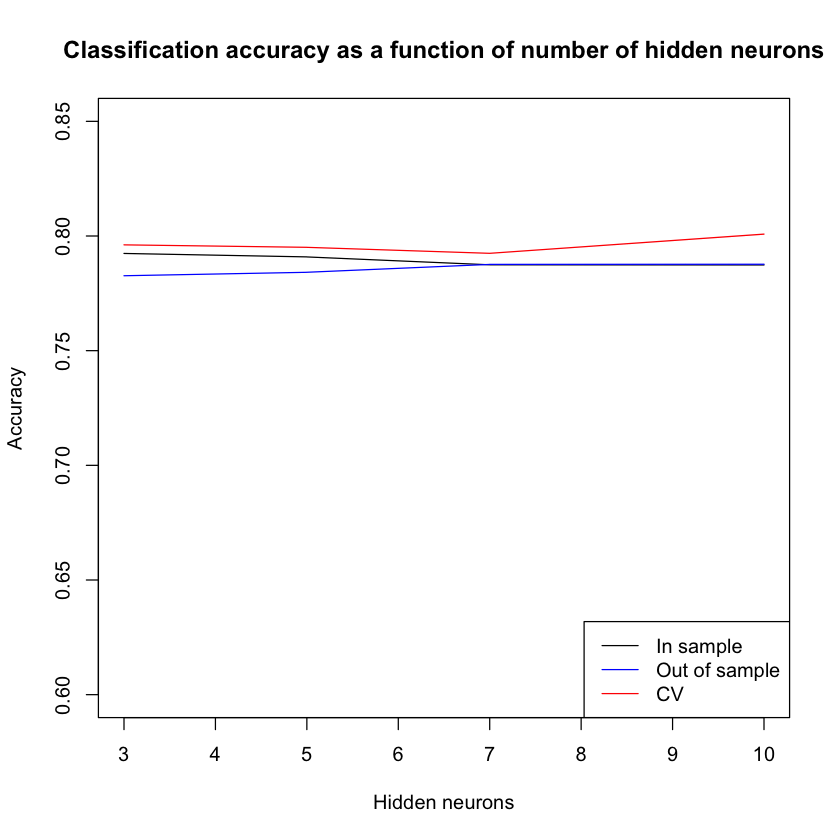

In [74]:
load("Results_CV.Rdata")
plot(hidden_nodes_vec,error_in_sample_vec,type="n",main="Classification accuracy as a function of number of hidden neurons",xlab="Hidden neurons",ylab="Accuracy",ylim=c(0.6,0.85))
lines(hidden_nodes_vec,error_in_sample_vec)
lines(hidden_nodes_vec,error_out_sample_vec,col="blue")
lines(hidden_nodes_vec,error_cv_vec,col="red")
legend("bottomright",legend=c("In sample","Out of sample","CV"),col=c("black","blue","red"),lty=c(1,1,1))

In [75]:
k <- 10
hidden_nodes_vec <- c(3,5,7,10)

error_in_sample_vec <- numeric()
error_out_sample_vec <- numeric()
error_cv_vec <- numeric()

for(hidden_nodes in hidden_nodes_vec){
    print(paste("Testing h=",hidden_nodes))
    results <- crossValidationInOutSample_season(hidden_nodes=hidden_nodes,k=k, threshold = 0.5)
    error_in_sample_vec <- c(error_in_sample_vec,results$in_sample)
    error_out_sample_vec <- c(error_out_sample_vec,results$out_sample)
    error_cv_vec <- c(error_cv_vec,results$cv)
}

[1] "Testing h= 3"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 1 fold: 0.211905653313366"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 2 fold: 0.229127667540247"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 3 fold: 0.225758143017596"
[1] "Training set size: 24037 - Testing set size 2670"
[1] "Misclassification rate - 4 fold: 0.257677902621723"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 5 fold: 0.219393485585923"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 6 fold: 0.232871583676526"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 7 fold: 0.232497192062898"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 8 fold: 0.229127667540247"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 

In [76]:
save(error_in_sample_vec,error_out_sample_vec,error_cv_vec,file="Results_CV.Rdata")

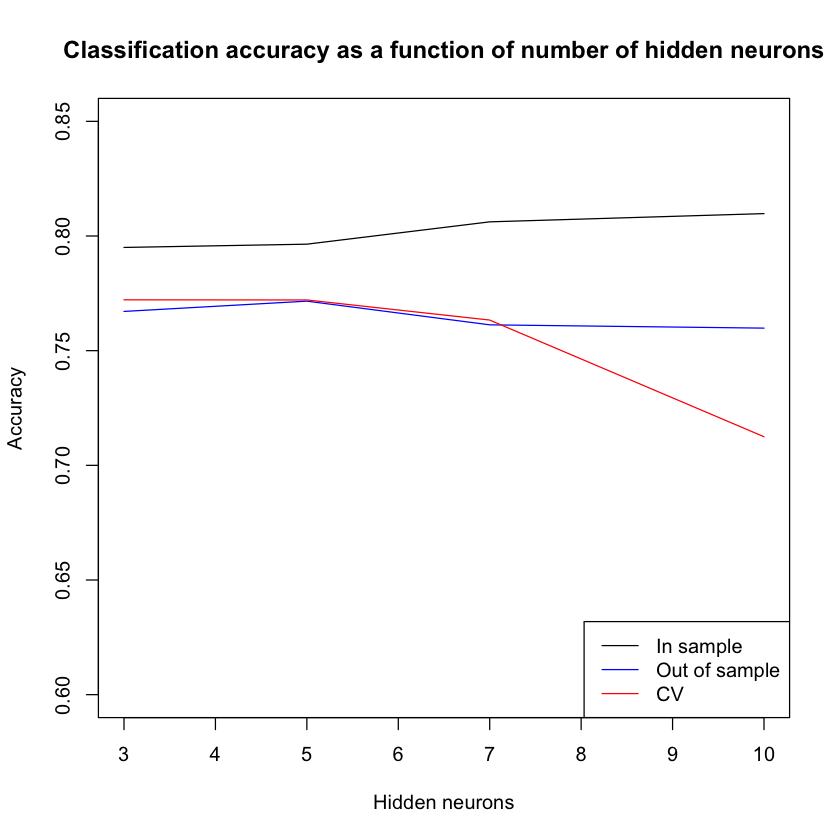

In [77]:
load("Results_CV.Rdata")
plot(hidden_nodes_vec,error_in_sample_vec,type="n",main="Classification accuracy as a function of number of hidden neurons",xlab="Hidden neurons",ylab="Accuracy",ylim=c(0.6,0.85))
lines(hidden_nodes_vec,error_in_sample_vec)
lines(hidden_nodes_vec,error_out_sample_vec,col="blue")
lines(hidden_nodes_vec,error_cv_vec,col="red")
legend("bottomright",legend=c("In sample","Out of sample","CV"),col=c("black","blue","red"),lty=c(1,1,1))

We observe that in general the best results are obtained for 7 neurons in both models.

### Searching for the optimal initial weight of the connections of our neural network with the same method

Once we know how many nodes we are going to use, we test again several values for the initial weights of the connections of the neural network.

In [78]:
k <- 10
rang_vec <- c(0.1,0.2,0.3,0.4,0.5)

error_in_sample_vec_r <- numeric()
error_out_sample_vec_r <- numeric()
error_cv_vec_r <- numeric()

for(rang in rang_vec){
    print(paste("Testing rang=",rang))
    results <- crossValidationInOutSample_h1n1(hidden_nodes=7,k=k, threshold = 0.5, r=rang)
    error_in_sample_vec_r <- c(error_in_sample_vec_r,results$in_sample)
    error_out_sample_vec_r <- c(error_out_sample_vec_r,results$out_sample)
    error_cv_vec_r <- c(error_cv_vec_r,results$cv)
}

[1] "Testing rang= 0.1"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 1 fold: 0.204043429427181"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 2 fold: 0.204043429427181"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 3 fold: 0.214526394608761"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 4 fold: 0.209659303631599"
[1] "Training set size: 24037 - Testing set size 2670"
[1] "Misclassification rate - 5 fold: 0.211610486891386"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 6 fold: 0.226506926244852"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 7 fold: 0.201422688131786"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 8 fold: 0.210782478472482"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification ra

Warning message in if (rownames(confusion_matrix) == 1) {:
“the condition has length > 1 and only the first element will be used”


[1] "Accuracy In sample : 0.791267225883763"
[1] "Misclassification rate In sample : 0.208732774116237"


Warning message in if (rownames(confusion_matrix) == 1) {:
“the condition has length > 1 and only the first element will be used”


[1] "Accuracy Out sample : 0.783810094353752"
[1] "Misclassification rate Out sample : 0.216189905646248"
[1] "Testing rang= 0.2"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 1 fold: 0.15350056158742"
[1] "Training set size: 24037 - Testing set size 2670"
[1] "Misclassification rate - 2 fold: 0.170786516853933"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 3 fold: 0.217895919131411"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 4 fold: 0.217895919131411"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 5 fold: 0.166229876450767"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 6 fold: 0.228753275926619"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 7 fold: 0.209659303631599"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 8 

Warning message in if (rownames(confusion_matrix) == 1) {:
“the condition has length > 1 and only the first element will be used”


[1] "Accuracy In sample : 0.787522468544038"
[1] "Misclassification rate In sample : 0.212477531455962"


Warning message in if (rownames(confusion_matrix) == 1) {:
“the condition has length > 1 and only the first element will be used”


[1] "Accuracy Out sample : 0.787554290849184"
[1] "Misclassification rate Out sample : 0.212445709150816"
[1] "Testing rang= 0.3"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 1 fold: 0.159490827405466"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 2 fold: 0.164732309996256"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 3 fold: 0.212654436540621"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 4 fold: 0.167353051291651"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 5 fold: 0.217895919131411"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 6 fold: 0.206664170722576"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 7 fold: 0.205166604268064"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 8

Warning message in if (rownames(confusion_matrix) == 1) {:
“the condition has length > 1 and only the first element will be used”


[1] "Accuracy In sample : 0.785516363364038"
[1] "Misclassification rate In sample : 0.214483636635962"


Warning message in if (rownames(confusion_matrix) == 1) {:
“the condition has length > 1 and only the first element will be used”


[1] "Accuracy Out sample : 0.789560398412342"
[1] "Misclassification rate Out sample : 0.210439601587658"
[1] "Testing rang= 0.4"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 1 fold: 0.218270310745039"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 2 fold: 0.215649569449644"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 3 fold: 0.168101834518907"
[1] "Training set size: 24037 - Testing set size 2670"
[1] "Misclassification rate - 4 fold: 0.203370786516854"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 5 fold: 0.207038562336204"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 6 fold: 0.215649569449644"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 7 fold: 0.177087233245975"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 8

Warning message in if (rownames(confusion_matrix) == 1) {:
“the condition has length > 1 and only the first element will be used”


[1] "Accuracy In sample : 0.787447573397244"
[1] "Misclassification rate In sample : 0.212552426602756"


Warning message in if (rownames(confusion_matrix) == 1) {:
“the condition has length > 1 and only the first element will be used”


[1] "Accuracy Out sample : 0.787629174779092"
[1] "Misclassification rate Out sample : 0.212370825220908"
[1] "Testing rang= 0.5"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 1 fold: 0.178959191314115"
[1] "Training set size: 24037 - Testing set size 2670"
[1] "Misclassification rate - 2 fold: 0.20749063670412"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 3 fold: 0.225758143017596"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 4 fold: 0.163983526769"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 5 fold: 0.210033695245227"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 6 fold: 0.214152002995133"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 7 fold: 0.219019093972295"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 8 fol

Warning message in if (rownames(confusion_matrix) == 1) {:
“the condition has length > 1 and only the first element will be used”


[1] "Accuracy In sample : 0.789544637507489"
[1] "Misclassification rate In sample : 0.210455362492511"


Warning message in if (rownames(confusion_matrix) == 1) {:
“the condition has length > 1 and only the first element will be used”


[1] "Accuracy Out sample : 0.78553242474165"
[1] "Misclassification rate Out sample : 0.21446757525835"


In [79]:
save(error_in_sample_vec_r,error_out_sample_vec_r,error_cv_vec_r,file="Results_CV_r.Rdata")

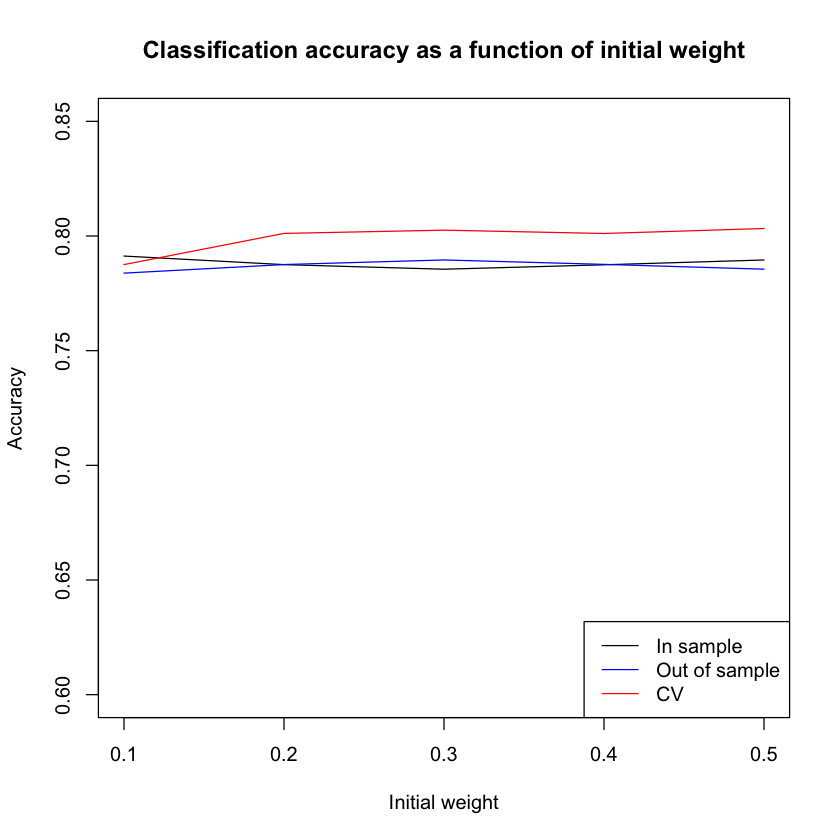

In [80]:
load("Results_CV_r.Rdata")
plot(rang_vec,error_in_sample_vec_r,type="n",main="Classification accuracy as a function of initial weight",xlab="Initial weight",ylab="Accuracy",ylim=c(0.6,0.85))
lines(rang_vec,error_in_sample_vec_r)
lines(rang_vec,error_out_sample_vec_r,col="blue")
lines(rang_vec,error_cv_vec_r,col="red")
legend("bottomright",legend=c("In sample","Out of sample","CV"),col=c("black","blue","red"),lty=c(1,1,1))

In [81]:
k <- 10
rang_vec <- c(0.1,0.2,0.3,0.4,0.5)

error_in_sample_vec_r <- numeric()
error_out_sample_vec_r <- numeric()
error_cv_vec_r <- numeric()

for(rang in rang_vec){
    print(paste("Testing rang=",rang))
    results <- crossValidationInOutSample_season(hidden_nodes=7,k=k, threshold = 0.5, r=rang)
    error_in_sample_vec_r <- c(error_in_sample_vec_r,results$in_sample)
    error_out_sample_vec_r <- c(error_out_sample_vec_r,results$out_sample)
    error_cv_vec_r <- c(error_cv_vec_r,results$cv)
}

[1] "Testing rang= 0.1"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 1 fold: 0.2163983526769"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 2 fold: 0.236241108199176"
[1] "Training set size: 24037 - Testing set size 2670"
[1] "Misclassification rate - 3 fold: 0.234456928838951"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 4 fold: 0.239236241108199"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 5 fold: 0.225009359790341"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 6 fold: 0.229502059153875"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 7 fold: 0.231374017222014"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 8 fold: 0.224260576563085"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate

In [82]:
save(error_in_sample_vec_r,error_out_sample_vec_r,error_cv_vec_r,file="Results_CV_r.Rdata")

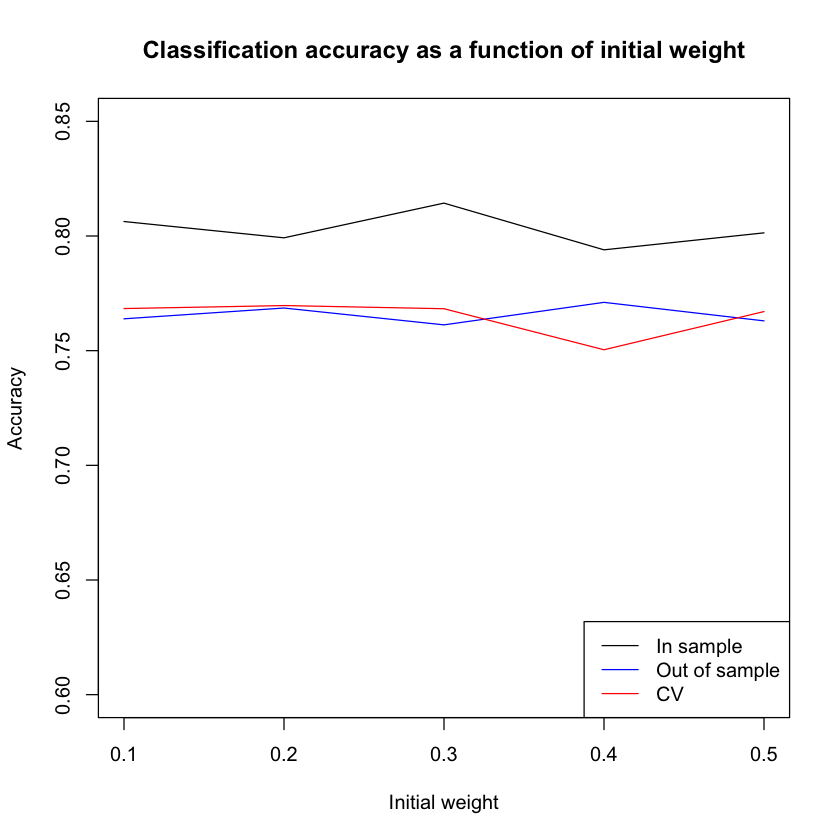

In [83]:
load("Results_CV_r.Rdata")
plot(rang_vec,error_in_sample_vec_r,type="n",main="Classification accuracy as a function of initial weight",xlab="Initial weight",ylab="Accuracy",ylim=c(0.6,0.85))
lines(rang_vec,error_in_sample_vec_r)
lines(rang_vec,error_out_sample_vec_r,col="blue")
lines(rang_vec,error_cv_vec_r,col="red")
legend("bottomright",legend=c("In sample","Out of sample","CV"),col=c("black","blue","red"),lty=c(1,1,1))

With that we can be sure that the best weight for initial connections is 0.4 for both models.

### Performing 10-fold cross validation with the selected parameters

Next, we are doing 10-fold cross validation with the selected parameters in order to know the expected performance.

In [84]:
k <- 10

error_in_sample_vec_r <- numeric()
error_out_sample_vec_r <- numeric()
error_cv_vec_r <- numeric()

results <- crossValidationInOutSample_h1n1(hidden_nodes=7,k=k, threshold = 0.5, r=0.4)
error_in_sample_vec_r <- c(error_in_sample_vec_r,results$in_sample)
error_out_sample_vec_r <- c(error_out_sample_vec_r,results$out_sample)
error_cv_vec_r <- c(error_cv_vec_r,results$cv)
print("Accuracy CV")
print(error_cv_vec_r)

[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 1 fold: 0.210408086858854"
[1] "Training set size: 24037 - Testing set size 2670"
[1] "Misclassification rate - 2 fold: 0.210486891385768"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 3 fold: 0.218644702358667"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 4 fold: 0.197678771995507"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 5 fold: 0.177087233245975"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 6 fold: 0.207038562336204"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 7 fold: 0.213028828154249"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 8 fold: 0.214900786222389"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 9 fold: 0.173343317

Warning message in if (rownames(confusion_matrix) == 1) {:
“the condition has length > 1 and only the first element will be used”


[1] "Accuracy In sample : 0.789994008388256"
[1] "Misclassification rate In sample : 0.210005991611744"


Warning message in if (rownames(confusion_matrix) == 1) {:
“the condition has length > 1 and only the first element will be used”


[1] "Accuracy Out sample : 0.785083121162199"
[1] "Misclassification rate Out sample : 0.214916878837801"
[1] "Accuracy CV"
[1] 0.7954744


In [85]:
k <- 10

error_in_sample_vec_r <- numeric()
error_out_sample_vec_r <- numeric()
error_cv_vec_r <- numeric()

results <- crossValidationInOutSample_season(hidden_nodes=7,k=k, threshold = 0.5, r=0.4)
error_in_sample_vec_r <- c(error_in_sample_vec_r,results$in_sample)
error_out_sample_vec_r <- c(error_out_sample_vec_r,results$out_sample)
error_cv_vec_r <- c(error_cv_vec_r,results$cv)
print("Accuracy CV")
print(error_cv_vec_r)

[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 1 fold: 0.270685136652939"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 2 fold: 0.223137401722201"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 3 fold: 0.231748408835642"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 4 fold: 0.23736428304006"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 5 fold: 0.234743541744665"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 6 fold: 0.231374017222014"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 7 fold: 0.257955821789592"
[1] "Training set size: 24037 - Testing set size 2670"
[1] "Misclassification rate - 8 fold: 0.211985018726592"
[1] "Training set size: 24036 - Testing set size 2671"
[1] "Misclassification rate - 9 fold: 0.2186447023

We can see that its accuracy is 80% for "h1n1_vaccine" and 76% for "seasonal_vaccine"

### Training the model and making the predictions
Finally, we train our model and make the predictions:

In [86]:
nnet_h1n1<-nnet(x=X,
               y=class.ind(Y_h1n1),
               size=7,
               skip=FALSE,
               trace=T, 
               maxit=1000,
               rang=0.4)

# weights:  345
initial  value 13209.250129 
final  value 11348.000000 
converged


In [87]:
nnet_season<-nnet(x=X,
               y=class.ind(Y_season),
               size=7,
               skip=FALSE,
               trace=T, 
               maxit=1000,
               rang=0.4)

# weights:  345
initial  value 13383.748138 
iter  10 value 10070.733706
iter  20 value 8685.067570
iter  30 value 8464.034336
iter  40 value 8376.101109
iter  50 value 8315.877048
iter  60 value 8260.963538
iter  70 value 8232.904619
iter  80 value 8214.099576
iter  90 value 8196.228629
iter 100 value 8185.256128
iter 110 value 8176.084972
iter 120 value 8167.662645
iter 130 value 8158.978045
iter 140 value 8152.117129
iter 150 value 8146.094455
iter 160 value 8140.058942
iter 170 value 8125.680819
iter 180 value 8110.509253
iter 190 value 8099.944385
iter 200 value 8090.482034
iter 210 value 8077.852523
iter 220 value 8070.840030
iter 230 value 8061.871006
iter 240 value 8041.183400
iter 250 value 7998.574258
iter 260 value 7971.041898
iter 270 value 7949.767889
iter 280 value 7931.431840
iter 290 value 7921.127119
iter 300 value 7914.678804
iter 310 value 7910.152426
iter 320 value 7906.256845
iter 330 value 7905.264662
iter 340 value 7903.618351
iter 350 value 7897.080778
iter 360 

In [88]:
Y_pred_h1n1_nnet<-predict(nnet_h1n1,data_test)
Y_pred_season_nnet<-predict(nnet_season,data_test)

Our neural network model yields two probabilities for each variable: the probability of that variable taking the value 1 and the probability of that same variable taking the value 0.

In [89]:
head(Y_pred_h1n1_nnet)
head(Y_pred_season_nnet)

,0,1
1,1,0
2,1,0
3,1,0
4,1,0
5,1,0
6,1,0


,0,1
1,1.00000000,0.0000000
2,0.96268402,0.0372980
3,0.33191883,0.6680831
4,0.05130609,0.9487286
5,0.57444503,0.4255763
6,0.10980740,0.8901828


In [90]:
respondent_id<-intact_data_test$respondent_id
h1n1_vaccine<-Y_pred_h1n1_nnet[,2]
seasonal_vaccine<-Y_pred_season_nnet[,2]

result_nnet<-data.frame(respondent_id,h1n1_vaccine,seasonal_vaccine)


write.csv(result_nnet, "./result_nnet.csv", row.names=FALSE)

## Model 2: Random Forest

The second chosen model is the random forest. This models consists in generating a certain number of decision trees. These decision trees will be based on random features and random entries from our dataset. It will also use bootstrap when creating the trees, so it can have more options available. Normally, the prediction given by a random forest is an average of the results yielded by its trees or a majority vote, for numeral or categorical variables, repectively. Two different models will be implemented, one for each variable we want to predict. As a hyperparameter, we will have the number of trees. We will plot a diagram to show how the performance evolves as the number of trees increases. Cross validation will also be performed to assess the overall performance of each model. 

### Choosing the best number of trees
Generally, a good number of trees is around 100, so we will test the performance from just 1 tree up to 100, and then choose the most accurate model. Using the random forest package, the model will perform its own embedded feature selection method. Note that this takes quite a long time to execute. To speed up the process, one can comment the outer loop, corresponding to the cross validation, and updating the j value to a number (which is the case as it is now, but it has been executed with the cross validation). The number of k-fold cross validation has been set to 3 so that it can finish in a reasonable amount of time, but it can be set to a higher number.

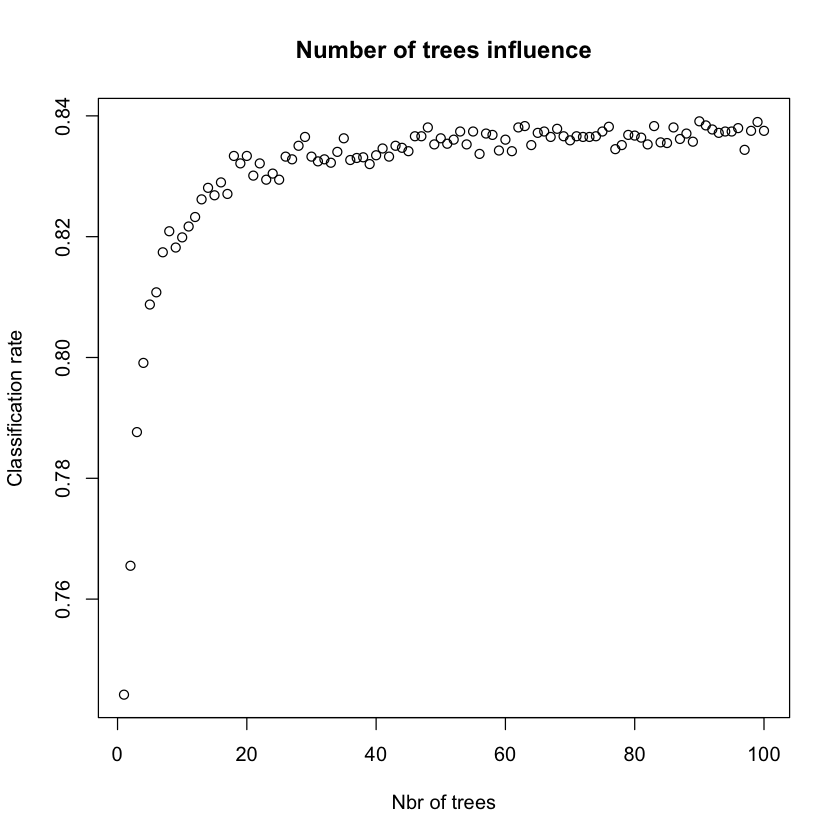

In [91]:
n_trees <- 100
accuracy_vec <- array(0,n_trees)
k<-3

#Shuffle the data
idx <- sample(1:nrow(data_training_h1n1))
target_variable <- ncol(data_training_h1n1)

#Split the dataset into k groups for k-fold CV
max <- ceiling(nrow(data_training_h1n1)/k)
splits <- split(idx, ceiling(seq_along(idx)/max))

#for (j in 1:k){
    for (i in 1:n_trees){
        #Take the split of the dataset as a training data set
        train_data <- data_training_h1n1[-splits[[1]],] #j instead of 1 for CV

        #Take the rest of the dataset as a hold out or test data set
        test_data <- data_training_h1n1[splits[[1]],] #j instead of 1 for CV

        model <- randomForest(x=train_data[,-c(target_variable)],
                              y=as.factor(train_data[,c(target_variable)]),
                              xtest=test_data[,-c(target_variable)],
                              ytest=as.factor(test_data[,c(target_variable)]),
                              ntree=i)

        accuracy_vec[i] = (model$test$confusion[1,1]+model$test$confusion[2,2])/sum(model$test$confusion)
    }

    plot(accuracy_vec,main = "Number of trees influence",xlab = "Nbr of trees",ylab = "Classification rate") 
#}

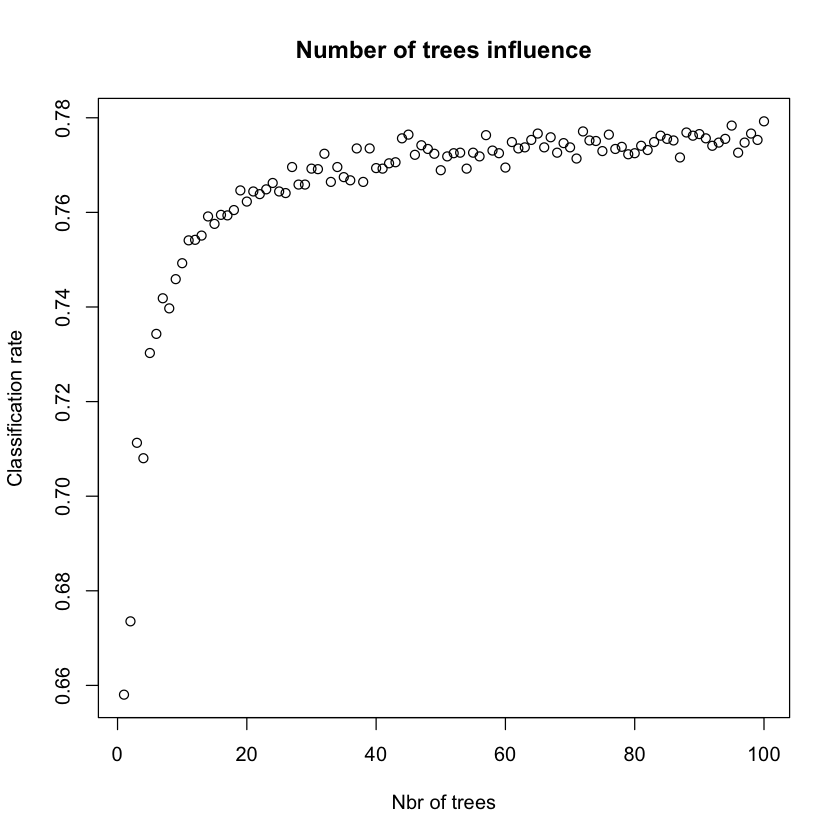

In [92]:
n_trees <- 100
accuracy_vec <- array(0,n_trees)
k<-3

#Shuffle the data
idx <- sample(1:nrow(data_training_season))
target_variable <- ncol(data_training_season)

#Split the dataset into k groups for k-fold CV
max <- ceiling(nrow(data_training_season)/k)
splits <- split(idx, ceiling(seq_along(idx)/max))

#for (j in 1:k){
    for (i in 1:n_trees){ 
        #Take the split of the dataset as a training data set
        train_data <- data_training_season[-splits[[1]],] #j instead of 1 for CV

        #Take the rest of the dataset as a hold out or test data set
        test_data <- data_training_season[splits[[1]],] #j instead of 1 for CV

        model <- randomForest(x=train_data[,-c(target_variable)],
                              y=as.factor(train_data[,c(target_variable)]),
                              xtest=test_data[,-c(target_variable)],
                              ytest=as.factor(test_data[,c(target_variable)]),
                              ntree=i)

        accuracy_vec[i] = (model$test$confusion[1,1]+model$test$confusion[2,2])/sum(model$test$confusion)
    }

    plot(accuracy_vec,main = "Number of trees influence",xlab = "Nbr of trees",ylab = "Classification rate") 
#}

### Performing 10-fold cross validation with the selected parameters
As we can see, the performance starts to stagnate at around 60 trees, but keeps increasing slowly. We will choose a total number of 80 trees in both cases to train our models. Now, we perform cross-validation to check the accuracy rate of the model with 80 trees we have selected:

In [93]:
k<-10
accuracy_vec <- array(0,k)

#Shuffle the data
idx <- sample(1:nrow(data_training_h1n1))
target_variable <- ncol(data_training_h1n1)

#Split the dataset into k groups for k-fold CV
max <- ceiling(nrow(data_training_h1n1)/k)
splits <- split(idx, ceiling(seq_along(idx)/max))

for (j in 1:k){
    #Take the split of the dataset as a training data set
    train_data <- data_training_h1n1[-splits[[j]],]

    #Take the rest of the dataset as a hold out or test data set
    test_data <- data_training_h1n1[splits[[j]],]

    model <- randomForest(x=train_data[,-c(target_variable)],
                          y=as.factor(train_data[,c(target_variable)]),
                          xtest=test_data[,-c(target_variable)],
                          ytest=as.factor(test_data[,c(target_variable)]),
                          ntree=80)

    accuracy_vec[j] = (model$test$confusion[1,1]+model$test$confusion[2,2])/sum(model$test$confusion)
    print(paste("Accuracy rate -",j,"fold: ",accuracy_vec[j]))
}
print(paste("Mean accuracy rate: ",mean(accuracy_vec)))

[1] "Accuracy rate - 1 fold:  0.834682923261047"
[1] "Accuracy rate - 2 fold:  0.828707924437395"
[1] "Accuracy rate - 3 fold:  0.833936314261003"
[1] "Accuracy rate - 4 fold:  0.830563560671837"
[1] "Accuracy rate - 5 fold:  0.832062849654783"
[1] "Accuracy rate - 6 fold:  0.828322464347447"
[1] "Accuracy rate - 7 fold:  0.824956724557687"
[1] "Accuracy rate - 8 fold:  0.840677391363204"
[1] "Accuracy rate - 9 fold:  0.835444983996876"
[1] "Accuracy rate - 10 fold:  0.849502152784259"
[1] "Mean accuracy rate:  0.833885728933554"


In [94]:
k<-10
accuracy_vec <- array(0,k)

#Shuffle the data
idx <- sample(1:nrow(data_training_season))
target_variable <- ncol(data_training_season)

#Split the dataset into k groups for k-fold CV
max <- ceiling(nrow(data_training_season)/k)
splits <- split(idx, ceiling(seq_along(idx)/max))

for (j in 1:k){
    #Take the split of the dataset as a training data set
    train_data <- data_training_season[-splits[[j]],]

    #Take the rest of the dataset as a hold out or test data set
    test_data <- data_training_season[splits[[j]],]

    model <- randomForest(x=train_data[,-c(target_variable)],
                          y=as.factor(train_data[,c(target_variable)]),
                          xtest=test_data[,-c(target_variable)],
                          ytest=as.factor(test_data[,c(target_variable)]),
                          ntree=80)

    accuracy_vec[j] = (model$test$confusion[1,1]+model$test$confusion[2,2])/sum(model$test$confusion)
    print(paste("Accuracy rate -",j,"fold: ",accuracy_vec[j]))
}
print(paste("Mean accuracy rate: ",mean(accuracy_vec)))

[1] "Accuracy rate - 1 fold:  0.778229853060033"
[1] "Accuracy rate - 2 fold:  0.765495828291161"
[1] "Accuracy rate - 3 fold:  0.750887707582967"
[1] "Accuracy rate - 4 fold:  0.786845003422593"
[1] "Accuracy rate - 5 fold:  0.775981951462034"
[1] "Accuracy rate - 6 fold:  0.780851819537748"
[1] "Accuracy rate - 7 fold:  0.769615397998358"
[1] "Accuracy rate - 8 fold:  0.785346233280045"
[1] "Accuracy rate - 9 fold:  0.779352409638637"
[1] "Accuracy rate - 10 fold:  0.766731129724356"
[1] "Mean accuracy rate:  0.773933733399793"


### Training the model and making the predictions
As expected, the accuracy rate of our selected model is around 83% for "h1n1_vaccine" and 77% for "seasonal_vaccine". Now we proceed to train our model so that we can make the predictions we need with our test data:

In [95]:
rf_h1n1 <- randomForest(x=X,
                        y=as.factor(Y_h1n1),
                        ntree=80)

In [96]:
rf_season <- randomForest(x=X,
                          y=as.factor(Y_season),
                          ntree=80)

In [97]:
Y_pred_h1n1_rf<-predict(rf_h1n1,data_test,"prob")
Y_pred_season_rf<-predict(rf_season,data_test,"prob")

In the case of the random forest prediction model, the output is two probabilities (which sum up to 1) for each variable: the probability for that entry to take the value 0 and the probability for that same entry to take value 1:

In [98]:
head(Y_pred_h1n1_rf)
head(Y_pred_season_rf)

,0,1
1,0.8000,0.2000
2,0.9500,0.0500
3,0.4000,0.6000
4,0.5000,0.5000
5,0.6875,0.3125
6,0.4375,0.5625


,0,1
1,0.8125,0.1875
2,1.0000,0.0000
3,0.0250,0.9750
4,0.1500,0.8500
5,0.4375,0.5625
6,0.0625,0.9375


In [99]:
respondent_id<-intact_data_test$respondent_id
h1n1_vaccine<-Y_pred_h1n1_rf[,2]
seasonal_vaccine<-Y_pred_season_rf[,2]

result_rf<-data.frame(respondent_id,h1n1_vaccine,seasonal_vaccine)


write.csv(result_rf, "./result_rf.csv", row.names=FALSE)

# Model 3 : Decision Tree
Decision tree is a supervised learning algorithm which can be used for both regression (quantitive outputs) and classification (qualitative or categorical outputs) problems.

The idea of decision tree algorithm is to build a tree from the top (root node) to the bottom (leaves). Each intermediate node represents a condition on a feature that directs what the next node is and the end nodes or leaves are associated with a single output variable value. Each sample in the training set must have a unique path on the trained tree.

Decision Trees have some advantages : 
 - Decision trees are able to deals with both quantitive or qualitative outputs and features.
 - It's very simple to understand small decisions.
But also some drawbacks: 
 - It's very dificult to interpret large trees.
 - Sometimes decision trees lack accuracy.
 
For the following implementation, we have used the **rpart** package to train our decision trees and **rpart.plot** to plot the obtained trees.

##  Training our model with decision tree algorithm 
First, we are going to use 50% of the training data for the training and the other half for the assessment of the obtained model:

In [100]:
h1n1 <- data_training_h1n1
season <- data_training_season
colnames(h1n1)[ncol(h1n1)] <- 'h1n1_vaccine'
colnames(season)[ncol(season)] <- 'seasonal_vaccine'

#### 1. Decision Tree model for h1n1_vaccine classification problem and accuracy measure
As can be seen on the decision tree below and on the variable importance  table, **'doctor_recc_h1n1'**, which represents the fact that the H1N1 flu vaccine was recommended by the doctor or not, strongly influences the decision or the output value for our model.
The model is easily readable and interpretable and we have an accuracy score of 82% for the prediction of **'h1n1_vaccine'** (whether respondent received H1N1 flu vaccine or not). 

[1] "Training Set Size :  13353 Test set Size :  13354"


,model_h1n1.variable.importance
,<dbl>
doctor_recc_h1n1,671.0689183
doctor_recc_seasonal,129.2540358
opinion_h1n1_vacc_effective,112.6269100
opinion_h1n1_risk,55.6143309
opinion_seas_vacc_effective,34.7727892
opinion_seas_risk,25.2876309
h1n1_concern,10.3674625
opinion_h1n1_sick_from_vacc,7.3764208
behavioral_antiviral_meds,0.6739529


[1] "Misclassification_rate On h1n1 Vaccine Prediction =  0.18136887823873"
[1] "Accuracy On h1n1 Vaccine Prediction =  0.81863112176127"


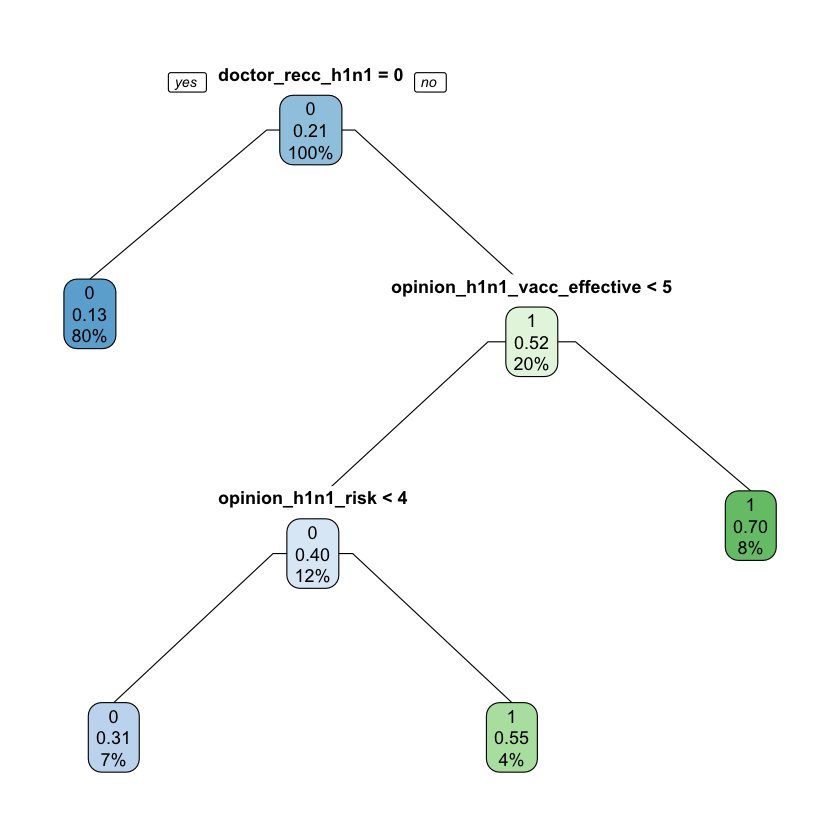

In [101]:
# 1. Shuffle the dataset randomly.
shuffled_index <- sample(1:nrow(h1n1))

# 2. get the index for the half of the dataset
half_index <- floor(nrow(h1n1)/2)

# 3. split data training into two smaller data frames training set and the test set    
train_data <-  h1n1[shuffled_index[1:half_index],]
test_data <-  h1n1[shuffled_index[(half_index+1):nrow(h1n1)],]

#4. training_set and test_set sizes
print(paste("Training Set Size : ",half_index ,"Test set Size : ",nrow(h1n1)-half_index ))

#5. Train the decision tree model with rpart 
model_h1n1 <- rpart(h1n1_vaccine ~ . , method="class", data=train_data)

#visualize the most important variables
data.frame(model_h1n1$variable.importance)

#visualize the model's decision tree
rpart.plot(model_h1n1, type=1 , fallen.leaves = F ,cex =0.9)

#get predictions of our test set from our trained model
Y_pred <- predict(model_h1n1,test_data[,-ncol(test_data)])

# get real results from the test set
Y <- test_data[,ncol(test_data)]

threshold <- 0.5
# transform probabilities into binary values 
Y_hat <- ifelse(Y_pred[,2] > threshold,1,0) 

#confusion_matrix
confusion_matrix <- table(Y_hat,Y)

# 6. compute misclassification rate and accuracy
accuracy = (confusion_matrix[1,1]+confusion_matrix[2,2])/sum(confusion_matrix)
misclassification_rate = 1 - accuracy
print(paste("Misclassification_rate On h1n1 Vaccine Prediction = " , misclassification_rate))
print(paste( "Accuracy On h1n1 Vaccine Prediction = " , accuracy))

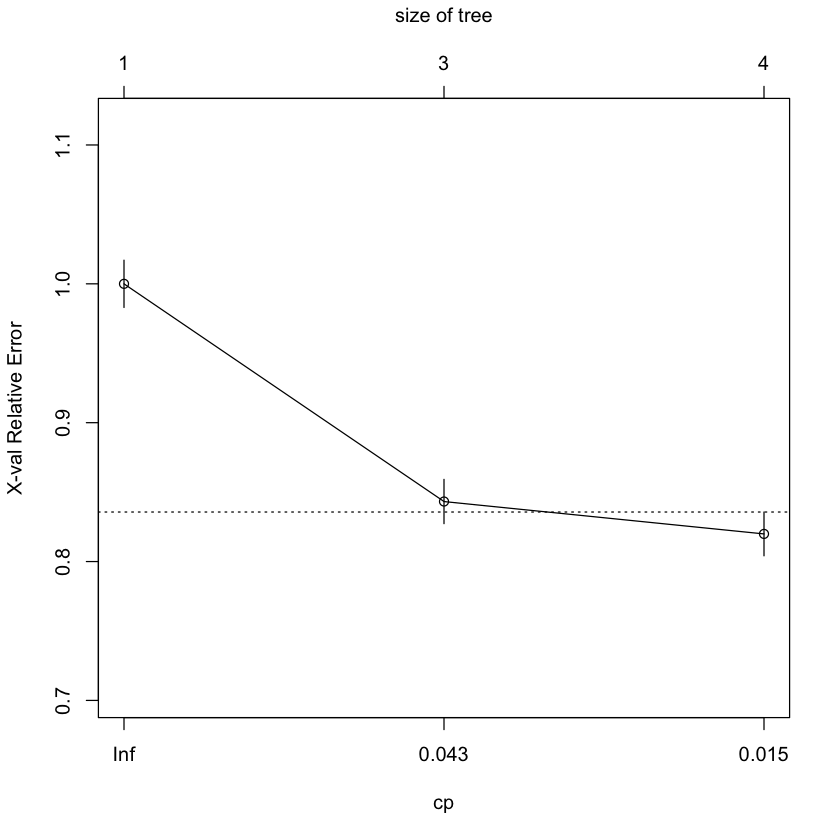

In [102]:
plotcp(model_h1n1) # visualize cross-validation error for differents size of tree

#### 2. Decision Tree model for seasonal_vaccine classification problem and accuracy measure
As can be seen on the decision tree below and on the variable importance  table, **'doctor_recc_season'**, which stands for the fact that Seasonal flu vaccine was recommended by doctor or not, and **'opinion_seas_vacc_effective'**, which corresponds to the respondent's opinion about seasonal flu vaccine effectiveness, both strongly influences the decision or the output value for our model.
The model is easily readable and interpretable as the previous model but we obtain less accuracy, being 74% for the prediction of **'seasonal_vaccine'** (whether respondent received Seasonal flu vaccine or not). 

[1] "Training Set Size :  13353 Test set Size :  13354"


,model_season.variable.importance
,<dbl>
opinion_seas_vacc_effective,894.591149
doctor_recc_seasonal,633.120878
doctor_recc_h1n1,280.589972
opinion_h1n1_vacc_effective,245.804564
opinion_seas_risk,170.556257
age_group,89.278223
opinion_h1n1_risk,66.337780
household_children,35.802589
not_in_labor_force,31.368024


[1] "Misclassification_rate On Seasonal Vaccine Prediction =  0.262168638610154"
[1] "Accuracy on Seasonal Vaccine Prediction =  0.737831361389846"


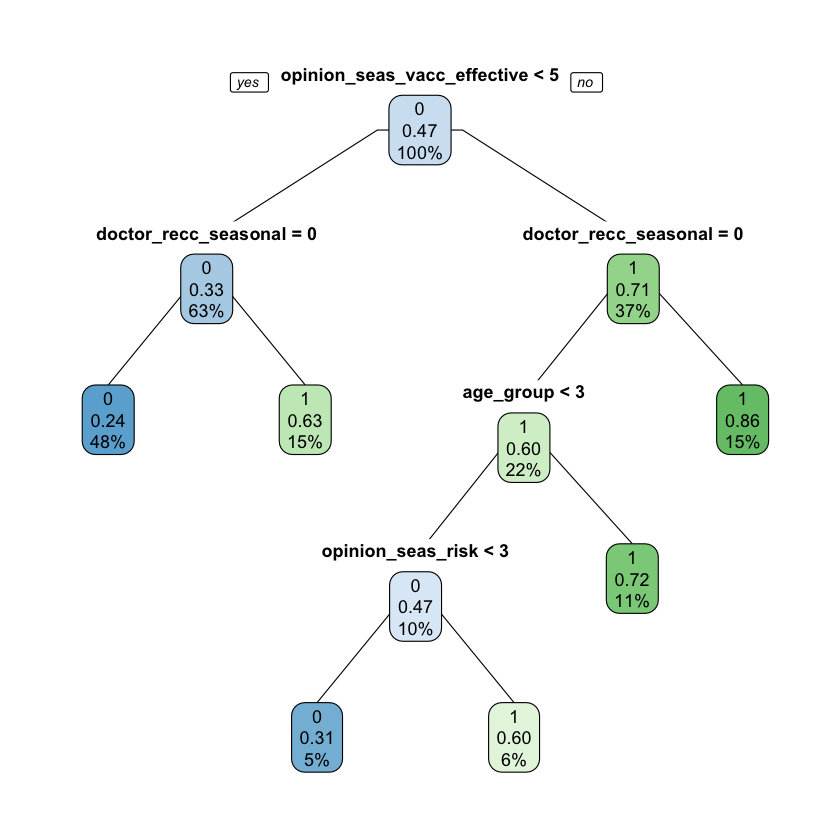

In [103]:
# 1. Shuffle the dataset randomly.
shuffled_index <- sample(1:nrow(season))

# 2. get the index for the half of the dataset
half_index <- floor(nrow(season)/2)

# 3. split data training into two smaller data frames training set and the test set    
train_data <- season[shuffled_index[1:half_index],]
test_data <- season[shuffled_index[(half_index+1):nrow(season)],]

#4. training_set and test_set sizes
print(paste("Training Set Size : ",half_index ,"Test set Size : ",nrow(season)-half_index ))

#5. Train the decision tree model with rpart 
model_season <- rpart(seasonal_vaccine ~ . , method="class", data=train_data)

#visualize the most important variables
data.frame(model_season$variable.importance)

#visualize the model's decision tree
rpart.plot(model_season, type=1 , fallen.leaves = F ,cex =0.9)

#get predictions of our test set from our trained model
Y_pred <- predict(model_season,test_data[,-ncol(test_data)])

# get real results from the test set
Y <- test_data[,ncol(test_data)]

threshold <- 0.5
# transform probabilities into binary values 
Y_hat <- ifelse(Y_pred[,2] > threshold,1,0) 

#confusion_matrix
confusion_matrix <- table(Y_hat,Y)


# compute misclassification rate and accuracy
accuracy = (confusion_matrix[1,1]+confusion_matrix[2,2])/sum(confusion_matrix)
misclassification_rate = 1 - accuracy
print(paste("Misclassification_rate On Seasonal Vaccine Prediction = " , misclassification_rate))
print(paste( "Accuracy on Seasonal Vaccine Prediction = " , accuracy))

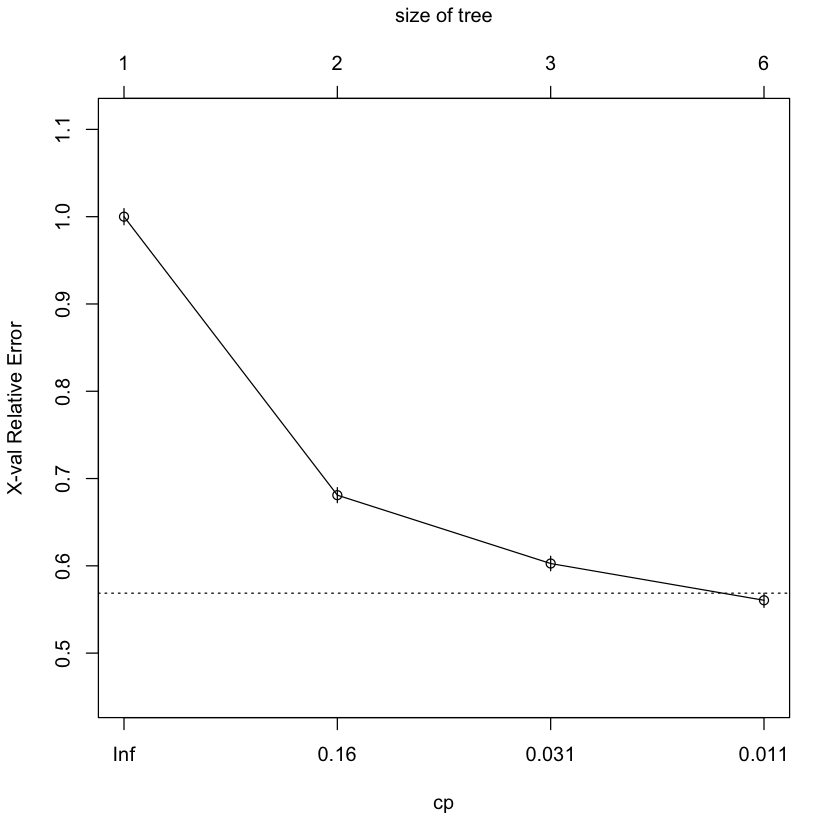

In [104]:
plotcp(model_season) # visualize cross-validation error for differents size of tree

### Learning with 10-fold Cross validation
The K-fold Cross validation helps us to assess our model. The idea is to split the training set DN into k partitions, and then for k iterations, we train our model with all the data without the i-th partition and we compute error with the ith partition (as the test set).
At the end of the k iterations we can compute the cross validation error, which is the average error of all the k partitions. 
In our implementation we have taken k = 10. This means that, at each iteration, 90% of the data is used for the training the decision and the remaining 10% of the data is used for test in order to assess the model.

In [105]:
k<-10
# 10% of data size
max <- ceiling(nrow(h1n1)/k)

accuracy_vec <- array(0,k)

shuffled_index <- sample(1:nrow(h1n1))

splits <- split(shuffled_index , ceiling(seq_along(shuffled_index)/max))

for (i in 1:k){
    #  split data training into two smaller data frames training set and the test set    
    train_data <-  h1n1[splits[[i]] , ]
    test_data <-  h1n1[-splits[[i]], ]


    model_h1n1_cv <- rpart(h1n1_vaccine ~ . , method="class", data=train_data)

    #get predictions of our test set from our trained model
    Y_pred <- predict(model_h1n1_cv,test_data[,-ncol(test_data)])
    # get real results from the test set
    Y <- test_data[,ncol(test_data)]

    threshold <- 0.5
    # transform probabilities into binary values 
    Y_hat <- ifelse(Y_pred[,2] > threshold,1,0) 

        #confusion_matrix
    confusion_matrix <- table(Y_hat,Y)

    # compute misclassification rate and accuracy
    accuracy = (confusion_matrix[1,1]+confusion_matrix[2,2])/sum(confusion_matrix)
    misclassification_rate = 1 - accuracy
    accuracy_vec[i] = accuracy
    print(paste(" Misclassification_error for the ",i,"-th Partition = " , misclassification_rate))
}
print(paste("Mean misclassification rate:",1-mean(accuracy_vec)))
print(paste("Mean accuracy rate:",mean(accuracy_vec)))

[1] " Misclassification_error for the  1 -th Partition =  0.177899816941255"
[1] " Misclassification_error for the  2 -th Partition =  0.178607089365951"
[1] " Misclassification_error for the  3 -th Partition =  0.17640206357131"
[1] " Misclassification_error for the  4 -th Partition =  0.176318855050757"
[1] " Misclassification_error for the  5 -th Partition =  0.175195540023298"
[1] " Misclassification_error for the  6 -th Partition =  0.180520885338659"
[1] " Misclassification_error for the  7 -th Partition =  0.18472291562656"
[1] " Misclassification_error for the  8 -th Partition =  0.180812115160592"
[1] " Misclassification_error for the  9 -th Partition =  0.176235646530205"
[1] " Misclassification_error for the  10 -th Partition =  0.175048878905113"
[1] "Mean misclassification rate: 0.17817638065137"
[1] "Mean accuracy rate: 0.82182361934863"


In [106]:
k<-10
# 10% of data size
max <- ceiling(nrow(season)/k)

accuracy_vec <- array(0,k)

shuffled_index <- sample(1:nrow(season))

splits <- split(shuffled_index , ceiling(seq_along(shuffled_index)/max))

for (i in 1:k){
    #  split data training into two smaller data frames training set and the test set    
    train_data <-  season[splits[[i]] , ]
    test_data <-  season[-splits[[i]], ]


    model_season_cv <- rpart(seasonal_vaccine ~ . , method="class", data=train_data)

    data.frame(model_season_cv$variable.importance)

    #get predictions of our test set from our trained model
    Y_pred <- predict(model_season_cv,test_data[,-ncol(test_data)])
    # get real results from the test set
    Y <- test_data[,ncol(test_data)]

    threshold <- 0.5
    # transform probabilities into binary values 
    Y_hat <- ifelse(Y_pred[,2] > threshold,1,0) 

    #confusion_matrix
    confusion_matrix <- table(Y_hat,Y)


    # compute misclassification rate and accuracy
    accuracy = (confusion_matrix[1,1]+confusion_matrix[2,2])/sum(confusion_matrix)
    misclassification_rate = 1 - accuracy
    accuracy_vec[i] = accuracy
    print(paste(" Misclassification_error for the ",i,"-th Partition = " , misclassification_rate))
}
print(paste("Mean misclassification rate:",1-mean(accuracy_vec)))
print(paste("Mean accuracy rate:",mean(accuracy_vec)))

[1] " Misclassification_error for the  1 -th Partition =  0.252080213013813"
[1] " Misclassification_error for the  2 -th Partition =  0.260026626726577"
[1] " Misclassification_error for the  3 -th Partition =  0.277500416042603"
[1] " Misclassification_error for the  4 -th Partition =  0.263937427192545"
[1] " Misclassification_error for the  5 -th Partition =  0.269803627891496"
[1] " Misclassification_error for the  6 -th Partition =  0.258736894658013"
[1] " Misclassification_error for the  7 -th Partition =  0.258445664836079"
[1] " Misclassification_error for the  8 -th Partition =  0.263812614411716"
[1] " Misclassification_error for the  9 -th Partition =  0.253910800465968"
[1] " Misclassification_error for the  10 -th Partition =  0.263197304380382"
[1] "Mean misclassification rate: 0.262145158961919"
[1] "Mean accuracy rate: 0.737854841038081"


### Training the model and making the predictions
Finally, we train our final models and make the predictions with the test data:

In [107]:
dt_h1n1 <- rpart(data_training_h1n1$h1n1_vaccine ~ . , method="class", data=data_training_h1n1)
dt_season <- rpart(data_training_season$seasonal_vaccine ~ . , method="class", data=data_training_season)

In [108]:
Y_pred_h1n1_dt<-predict(dt_h1n1,data_test)
Y_pred_season_dt<-predict(dt_season,data_test)

In [109]:
head(Y_pred_h1n1_dt)
head(Y_pred_season_dt)

,0,1
1,0.8687732,0.1312268
2,0.8687732,0.1312268
3,0.8687732,0.1312268
4,0.6750962,0.3249038
5,0.8687732,0.1312268
6,0.8687732,0.1312268


,0,1
1,0.6873563,0.3126437
2,0.7659608,0.2340392
3,0.2838602,0.7161398
4,0.3873508,0.6126492
5,0.7659608,0.2340392
6,0.4003984,0.5996016


In [110]:
respondent_id<-intact_data_test$respondent_id
h1n1_vaccine<-Y_pred_h1n1_dt[,2]
seasonal_vaccine<-Y_pred_season_dt[,2]

result_dt<-data.frame(respondent_id,h1n1_vaccine,seasonal_vaccine)


write.csv(result_dt, "./result_dt.csv", row.names=FALSE)

Comparing its performance with a random forest of 80 trees, for the "h1n1_vaccine" both accuracies are quite similar, but for the "seasonal_vaccine", the random forest takes the lead with a bigger advantage.

## Alternative model: Gradient Boosting Tree

The alternative model chosen is the gradient boosting tree. The first reason to pick this model was that the best performance corresponded to the random forest model, so it made sense to pick another tree-based model. The other reason to choose this model is to compare its performance with out other two tree-based models: random forest and decision tree. This model is an ensemble of other weaker models, being in this case decision trees. It normally outperforms the random forest model, so we will put it to the test and see if it is the case for our data. It works like any other boosting method: gets the prediction of the first of its weak learners, and then tries to improve it, generally trying to reduce the mean squared error. Then executes another of its weak learners after the pertinent parameter modificion, and repeats so in a iterative manner. We will make use of the package **gbm**.

### Choosing the best number of trees and distribution
In this case, we will compare several distributions to calculate the error that needs to be improved in the boosting. We will execute it using a "gaussian" distribution and a "bernoulli" distribution. The first one will take the mean squared error as error to improve, and the second one the logistic regression for 0-1 outcomes, since the results for the training data are binary. As a hyperparameter, we will use the number of trees that the method will use, in order to check its performance, using our own 3-fold crossvalidation error. We have chosen this number to avoid too large execution times. Note that, to perform the boosting, we need at least 2 trees, and we will check the influence of the number of trees up to 500 trees. Again, this will take a huge amount of time to finish, so one can comment the outer loop and update j accordingly to speed up the process (which is the case as it is now, but it has been executed with the cross validation), or modify the starting or finishing numbers of trees.

Using 2 trees...


Using 3 trees...


Using 4 trees...


Using 5 trees...


Using 6 trees...


Using 7 trees...


Using 8 trees...


Using 9 trees...


Using 10 trees...


Using 11 trees...


Using 12 trees...


Using 13 trees...


Using 14 trees...


Using 15 trees...


Using 16 trees...


Using 17 trees...


Using 18 trees...


Using 19 trees...


Using 20 trees...


Using 21 trees...


Using 22 trees...


Using 23 trees...


Using 24 trees...


Using 25 trees...


Using 26 trees...


Using 27 trees...


Using 28 trees...


Using 29 trees...


Using 30 trees...


Using 31 trees...


Using 32 trees...


Using 33 trees...


Using 34 trees...


Using 35 trees...


Using 36 trees...


Using 37 trees...


Using 38 trees...


Using 39 trees...


Using 40 trees...


Using 41 trees...


Using 42 trees...


Using 43 trees...


Using 44 trees...


Using 45 trees...


Using 46 trees...


Using 47 trees...


Using 48 trees...


Using 49 trees...


Using 50 trees...


Using 51 trees...


Using 52

Using 398 trees...


Using 399 trees...


Using 400 trees...


Using 401 trees...


Using 402 trees...


Using 403 trees...


Using 404 trees...


Using 405 trees...


Using 406 trees...


Using 407 trees...


Using 408 trees...


Using 409 trees...


Using 410 trees...


Using 411 trees...


Using 412 trees...


Using 413 trees...


Using 414 trees...


Using 415 trees...


Using 416 trees...


Using 417 trees...


Using 418 trees...


Using 419 trees...


Using 420 trees...


Using 421 trees...


Using 422 trees...


Using 423 trees...


Using 424 trees...


Using 425 trees...


Using 426 trees...


Using 427 trees...


Using 428 trees...


Using 429 trees...


Using 430 trees...


Using 431 trees...


Using 432 trees...


Using 433 trees...


Using 434 trees...


Using 435 trees...


Using 436 trees...


Using 437 trees...


Using 438 trees...


Using 439 trees...


Using 440 trees...


Using 441 trees...


Using 442 trees...


Using 443 trees...


Using 444 trees...


Using 445 tre

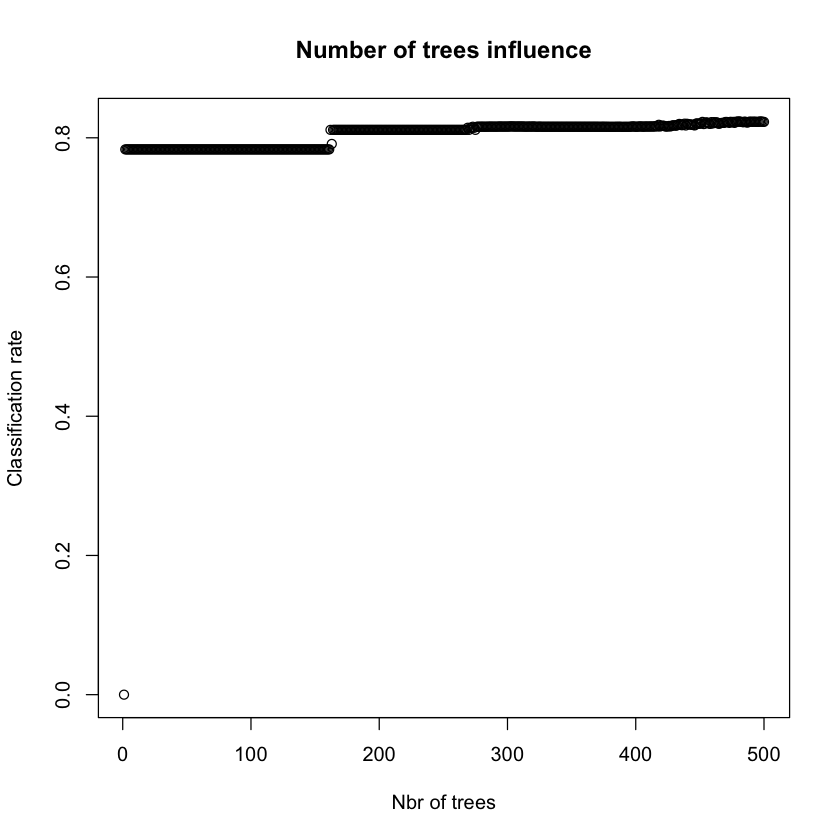

In [111]:
n_trees <- 500
accuracy_vec <- array(0,n_trees)
k<-3

#Shuffle the data
idx <- sample(1:nrow(data_training_h1n1))
target_variable <- ncol(data_training_h1n1)

#Split the dataset into k groups for k-fold CV
max <- ceiling(nrow(data_training_h1n1)/k)
splits <- split(idx, ceiling(seq_along(idx)/max))

#for (j in 1:k){
    for (i in 2:n_trees){
        #Take the split of the dataset as a training data set
        train_data <- data_training_h1n1[-splits[[1]],] #j instead of 1 for CV

        #Take the rest of the dataset as a hold out or test data set
        test_data <- data_training_h1n1[splits[[1]],] #j instead of 1 for CV
        
        #Train the model
        model_gbm = gbm(train_data$h1n1_vaccine ~.,
                        data = train_data,
                        distribution = "gaussian",
                        cv.folds = 10,
                        shrinkage = .01,
                        n.minobsinnode = 10,
                        n.trees = i)
        
        #Do the prediction
        Y_pred = predict(model_gbm, test_data[,-target_variable])
        Y = test_data[,target_variable]
        Y_hat <- ifelse(Y_pred > 0.5,"1","0") 
        
        #Check the accuracy rate
        confusion_matrix <- table(Y_hat,Y)
        conf_mat_nrows <- dim(confusion_matrix)[1]
        if (conf_mat_nrows == 1){
            accuracy_vec[i] = confusion_matrix[1,1]/sum(confusion_matrix)
        }else{
            accuracy_vec[i] = (confusion_matrix[1,1]+confusion_matrix[2,2])/sum(confusion_matrix)
        }
    }

    plot(accuracy_vec,main = "Number of trees influence",xlab = "Nbr of trees",ylab = "Classification rate")
#}

Using 2 trees...


Using 3 trees...


Using 4 trees...


Using 5 trees...


Using 6 trees...


Using 7 trees...


Using 8 trees...


Using 9 trees...


Using 10 trees...


Using 11 trees...


Using 12 trees...


Using 13 trees...


Using 14 trees...


Using 15 trees...


Using 16 trees...


Using 17 trees...


Using 18 trees...


Using 19 trees...


Using 20 trees...


Using 21 trees...


Using 22 trees...


Using 23 trees...


Using 24 trees...


Using 25 trees...


Using 26 trees...


Using 27 trees...


Using 28 trees...


Using 29 trees...


Using 30 trees...


Using 31 trees...


Using 32 trees...


Using 33 trees...


Using 34 trees...


Using 35 trees...


Using 36 trees...


Using 37 trees...


Using 38 trees...


Using 39 trees...


Using 40 trees...


Using 41 trees...


Using 42 trees...


Using 43 trees...


Using 44 trees...


Using 45 trees...


Using 46 trees...


Using 47 trees...


Using 48 trees...


Using 49 trees...


Using 50 trees...


Using 51 trees...


Using 52

Using 398 trees...


Using 399 trees...


Using 400 trees...


Using 401 trees...


Using 402 trees...


Using 403 trees...


Using 404 trees...


Using 405 trees...


Using 406 trees...


Using 407 trees...


Using 408 trees...


Using 409 trees...


Using 410 trees...


Using 411 trees...


Using 412 trees...


Using 413 trees...


Using 414 trees...


Using 415 trees...


Using 416 trees...


Using 417 trees...


Using 418 trees...


Using 419 trees...


Using 420 trees...


Using 421 trees...


Using 422 trees...


Using 423 trees...


Using 424 trees...


Using 425 trees...


Using 426 trees...


Using 427 trees...


Using 428 trees...


Using 429 trees...


Using 430 trees...


Using 431 trees...


Using 432 trees...


Using 433 trees...


Using 434 trees...


Using 435 trees...


Using 436 trees...


Using 437 trees...


Using 438 trees...


Using 439 trees...


Using 440 trees...


Using 441 trees...


Using 442 trees...


Using 443 trees...


Using 444 trees...


Using 445 tre

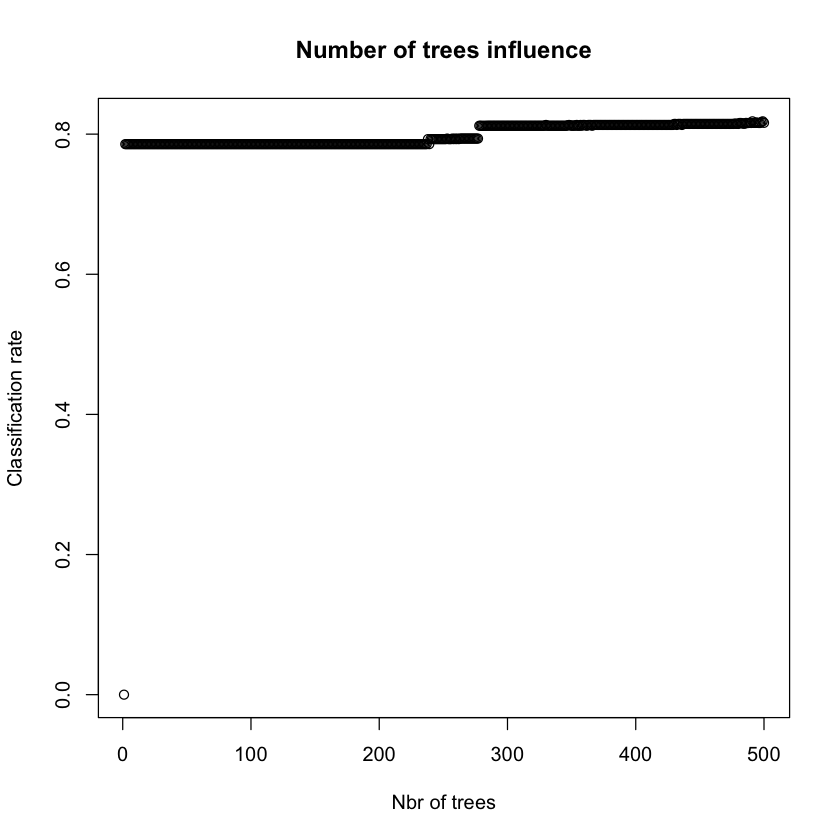

In [112]:
n_trees <- 500
accuracy_vec <- array(0,n_trees)
k<-3

#Shuffle the data
idx <- sample(1:nrow(data_training_h1n1))
target_variable <- ncol(data_training_h1n1)

#Split the dataset into k groups for k-fold CV
max <- ceiling(nrow(data_training_h1n1)/k)
splits <- split(idx, ceiling(seq_along(idx)/max))

#for (j in 1:k){
    for (i in 2:n_trees){
        #Take the split of the dataset as a training data set
        train_data <- data_training_h1n1[-splits[[1]],] #j instead of 1 for CV

        #Take the rest of the dataset as a hold out or test data set
        test_data <- data_training_h1n1[splits[[1]],] #j instead of 1 for CV
        
        #Train the model
        model_gbm = gbm(train_data$h1n1_vaccine ~.,
                        data = train_data,
                        distribution = "bernoulli",
                        cv.folds = 10,
                        shrinkage = .01,
                        n.minobsinnode = 10,
                        n.trees = i)
        
        #Do the prediction
        Y_pred = predict(model_gbm, test_data[,-target_variable])
        Y = test_data[,target_variable]
        Y_hat <- ifelse(Y_pred > 0.5,"1","0") 
        
        #Check the accuracy rate
        confusion_matrix <- table(Y_hat,Y)
        conf_mat_nrows <- dim(confusion_matrix)[1]
        if (conf_mat_nrows == 1){
            accuracy_vec[i] = confusion_matrix[1,1]/sum(confusion_matrix)
        }else{
            accuracy_vec[i] = (confusion_matrix[1,1]+confusion_matrix[2,2])/sum(confusion_matrix)
        }
    }

    plot(accuracy_vec,main = "Number of trees influence",xlab = "Nbr of trees",ylab = "Classification rate")
#}

Using 2 trees...


Using 3 trees...


Using 4 trees...


Using 5 trees...


Using 6 trees...


Using 7 trees...


Using 8 trees...


Using 9 trees...


Using 10 trees...


Using 11 trees...


Using 12 trees...


Using 13 trees...


Using 14 trees...


Using 15 trees...


Using 16 trees...


Using 17 trees...


Using 18 trees...


Using 19 trees...


Using 20 trees...


Using 21 trees...


Using 22 trees...


Using 23 trees...


Using 24 trees...


Using 25 trees...


Using 26 trees...


Using 27 trees...


Using 28 trees...


Using 29 trees...


Using 30 trees...


Using 31 trees...


Using 32 trees...


Using 33 trees...


Using 34 trees...


Using 35 trees...


Using 36 trees...


Using 37 trees...


Using 38 trees...


Using 39 trees...


Using 40 trees...


Using 41 trees...


Using 42 trees...


Using 43 trees...


Using 44 trees...


Using 45 trees...


Using 46 trees...


Using 47 trees...


Using 48 trees...


Using 49 trees...


Using 50 trees...


Using 51 trees...


Using 52

Using 398 trees...


Using 399 trees...


Using 400 trees...


Using 401 trees...


Using 402 trees...


Using 403 trees...


Using 404 trees...


Using 405 trees...


Using 406 trees...


Using 407 trees...


Using 408 trees...


Using 409 trees...


Using 410 trees...


Using 411 trees...


Using 412 trees...


Using 413 trees...


Using 414 trees...


Using 415 trees...


Using 416 trees...


Using 417 trees...


Using 418 trees...


Using 419 trees...


Using 420 trees...


Using 421 trees...


Using 422 trees...


Using 423 trees...


Using 424 trees...


Using 425 trees...


Using 426 trees...


Using 427 trees...


Using 428 trees...


Using 429 trees...


Using 430 trees...


Using 431 trees...


Using 432 trees...


Using 433 trees...


Using 434 trees...


Using 435 trees...


Using 436 trees...


Using 437 trees...


Using 438 trees...


Using 439 trees...


Using 440 trees...


Using 441 trees...


Using 442 trees...


Using 443 trees...


Using 444 trees...


Using 445 tre

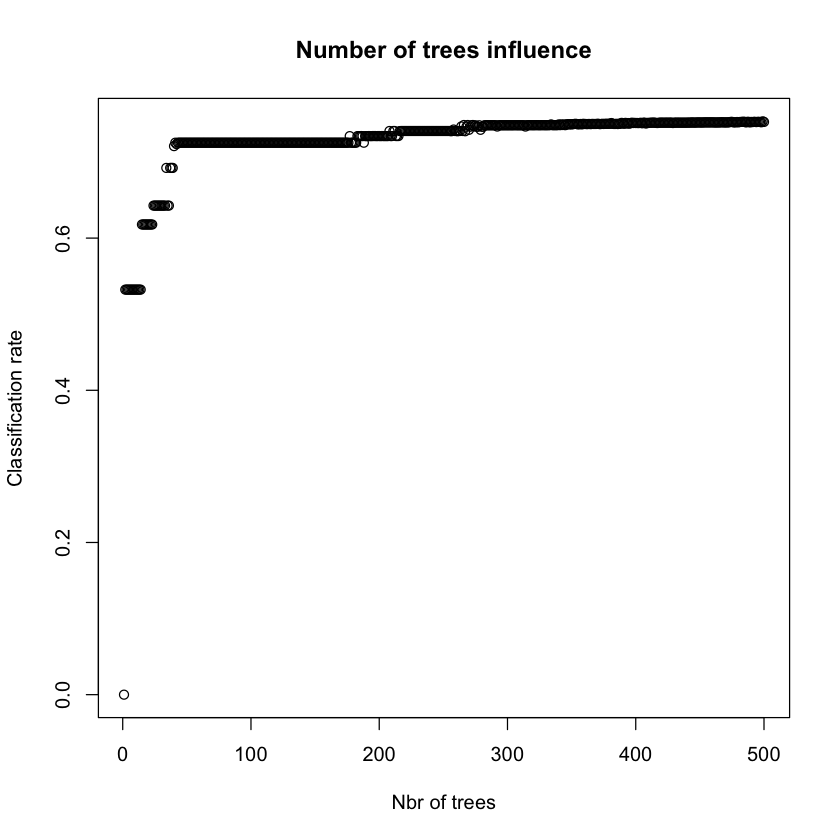

In [113]:
n_trees <- 500
accuracy_vec <- array(0,n_trees)
k<-3

#Shuffle the data
idx <- sample(1:nrow(data_training_season))
target_variable <- ncol(data_training_season)

#Split the dataset into k groups for k-fold CV
max <- ceiling(nrow(data_training_season)/k)
splits <- split(idx, ceiling(seq_along(idx)/max))

#for (j in 1:k){
    for (i in 2:n_trees){
        #Take the split of the dataset as a training data set
        train_data <- data_training_season[-splits[[1]],] #j instead of 1 for CV

        #Take the rest of the dataset as a hold out or test data set
        test_data <- data_training_season[splits[[1]],] #j instead of 1 for CV
        
        #Train the model
        model_gbm = gbm(train_data$seasonal_vaccine ~.,
                        data = train_data,
                        distribution = "gaussian",
                        cv.folds = 10,
                        shrinkage = .01,
                        n.minobsinnode = 10,
                        n.trees = i)
        
        #Do the prediction
        Y_pred = predict(model_gbm, test_data[,-target_variable])
        Y = test_data[,target_variable]
        Y_hat <- ifelse(Y_pred > 0.5,"1","0") 
        
        #Check the accuracy rate
        confusion_matrix <- table(Y_hat,Y)
        conf_mat_nrows <- dim(confusion_matrix)[1]
        if (conf_mat_nrows == 1){
            accuracy_vec[i] = confusion_matrix[1,1]/sum(confusion_matrix)
        }else{
            accuracy_vec[i] = (confusion_matrix[1,1]+confusion_matrix[2,2])/sum(confusion_matrix)
        }
    }

    plot(accuracy_vec,main = "Number of trees influence",xlab = "Nbr of trees",ylab = "Classification rate")
#}

Using 2 trees...


Using 3 trees...


Using 4 trees...


Using 5 trees...


Using 6 trees...


Using 7 trees...


Using 8 trees...


Using 9 trees...


Using 10 trees...


Using 11 trees...


Using 12 trees...


Using 13 trees...


Using 14 trees...


Using 15 trees...


Using 16 trees...


Using 17 trees...


Using 18 trees...


Using 19 trees...


Using 20 trees...


Using 21 trees...


Using 22 trees...


Using 23 trees...


Using 24 trees...


Using 25 trees...


Using 26 trees...


Using 27 trees...


Using 28 trees...


Using 29 trees...


Using 30 trees...


Using 31 trees...


Using 32 trees...


Using 33 trees...


Using 34 trees...


Using 35 trees...


Using 36 trees...


Using 37 trees...


Using 38 trees...


Using 39 trees...


Using 40 trees...


Using 41 trees...


Using 42 trees...


Using 43 trees...


Using 44 trees...


Using 45 trees...


Using 46 trees...


Using 47 trees...


Using 48 trees...


Using 49 trees...


Using 50 trees...


Using 51 trees...


Using 52

Using 398 trees...


Using 399 trees...


Using 400 trees...


Using 401 trees...


Using 402 trees...


Using 403 trees...


Using 404 trees...


Using 405 trees...


Using 406 trees...


Using 407 trees...


Using 408 trees...


Using 409 trees...


Using 410 trees...


Using 411 trees...


Using 412 trees...


Using 413 trees...


Using 414 trees...


Using 415 trees...


Using 416 trees...


Using 417 trees...


Using 418 trees...


Using 419 trees...


Using 420 trees...


Using 421 trees...


Using 422 trees...


Using 423 trees...


Using 424 trees...


Using 425 trees...


Using 426 trees...


Using 427 trees...


Using 428 trees...


Using 429 trees...


Using 430 trees...


Using 431 trees...


Using 432 trees...


Using 433 trees...


Using 434 trees...


Using 435 trees...


Using 436 trees...


Using 437 trees...


Using 438 trees...


Using 439 trees...


Using 440 trees...


Using 441 trees...


Using 442 trees...


Using 443 trees...


Using 444 trees...


Using 445 tre

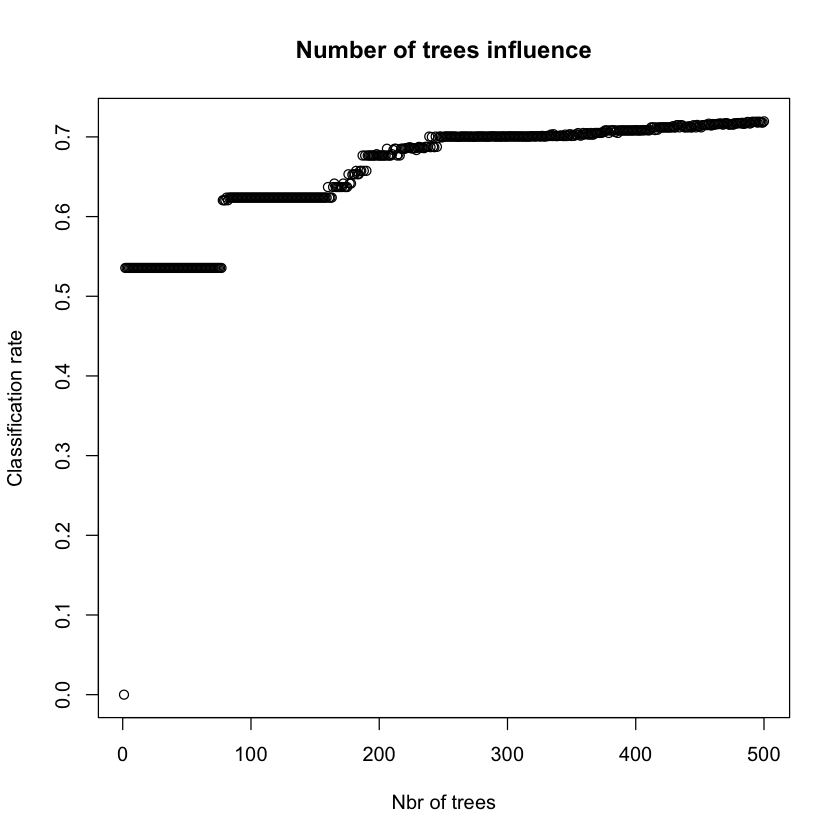

In [114]:
n_trees <- 500
accuracy_vec <- array(0,n_trees)
k<-3

#Shuffle the data
idx <- sample(1:nrow(data_training_season))
target_variable <- ncol(data_training_season)

#Split the dataset into k groups for k-fold CV
max <- ceiling(nrow(data_training_season)/k)
splits <- split(idx, ceiling(seq_along(idx)/max))

#for (j in 1:k){
    for (i in 2:n_trees){
        #Take the split of the dataset as a training data set
        train_data <- data_training_season[-splits[[1]],] #j instead of 1 for CV

        #Take the rest of the dataset as a hold out or test data set
        test_data <- data_training_season[splits[[1]],] #j instead of 1 for CV
        
        #Train the model
        model_gbm = gbm(train_data$seasonal_vaccine ~.,
                        data = train_data,
                        distribution = "bernoulli",
                        cv.folds = 10,
                        shrinkage = .01,
                        n.minobsinnode = 10,
                        n.trees = i)
        
        #Do the prediction
        Y_pred = predict(model_gbm, test_data[,-target_variable])
        Y = test_data[,target_variable]
        Y_hat <- ifelse(Y_pred > 0.5,"1","0") 
        
        #Check the accuracy rate
        confusion_matrix <- table(Y_hat,Y)
        conf_mat_nrows <- dim(confusion_matrix)[1]
        if (conf_mat_nrows == 1){
            accuracy_vec[i] = confusion_matrix[1,1]/sum(confusion_matrix)
        }else{
            accuracy_vec[i] = (confusion_matrix[1,1]+confusion_matrix[2,2])/sum(confusion_matrix)
        }
    }

    plot(accuracy_vec,main = "Number of trees influence",xlab = "Nbr of trees",ylab = "Classification rate")
#}

### Performing 10-fold cross validation on the selected model
As observed in the plots, both the gaussian and bernoulli models behave similarly. Regarding the influence of the number of trees used, around 400 trees the performance stops increasing, so we will use this number as a number of trees for our model. Now we perform cross-validation in our selected model in order to see its accuracy rate. We will test both with gaussian and bernoulli models, so we can choose the most accurate one:

In [115]:
k<-10
accuracy_vec <- array(0,k)

#Shuffle the data
idx <- sample(1:nrow(data_training_h1n1))
target_variable <- ncol(data_training_h1n1)

#Split the dataset into k groups for k-fold CV
max <- ceiling(nrow(data_training_h1n1)/k)
splits <- split(idx, ceiling(seq_along(idx)/max))

for (j in 1:k){
    #Take the split of the dataset as a training data set
    train_data <- data_training_h1n1[-splits[[j]],]

    #Take the rest of the dataset as a hold out or test data set
    test_data <- data_training_h1n1[splits[[j]],]

    #Train the model
    model_gbm = gbm(train_data$h1n1_vaccine ~.,
                    data = train_data,
                    distribution = "gaussian",
                    cv.folds = 10,
                    shrinkage = .01,
                    n.minobsinnode = 10,
                    n.trees = 400)

    #Do the prediction
    Y_pred = predict(model_gbm, test_data[,-target_variable])
    Y = test_data[,target_variable]
    Y_hat <- ifelse(Y_pred > 0.5,"1","0")
    confusion_matrix <- table(Y_hat,Y)

    #Check the accuracy rate
    accuracy_vec[j] = (confusion_matrix[1,1]+confusion_matrix[2,2])/sum(confusion_matrix)

    print(paste("Accuracy rate -",j,"fold: ",accuracy_vec[j]))
}
print(paste("Mean accuracy rate: ",mean(accuracy_vec)))

Using 400 trees...




[1] "Accuracy rate - 1 fold:  0.814301759640584"


Using 400 trees...




[1] "Accuracy rate - 2 fold:  0.822912766754025"


Using 400 trees...




[1] "Accuracy rate - 3 fold:  0.821040808685885"


Using 400 trees...




[1] "Accuracy rate - 4 fold:  0.829277424185698"


Using 400 trees...




[1] "Accuracy rate - 5 fold:  0.815424934481468"


Using 400 trees...




[1] "Accuracy rate - 6 fold:  0.825907899663048"


Using 400 trees...




[1] "Accuracy rate - 7 fold:  0.825907899663048"


Using 400 trees...




[1] "Accuracy rate - 8 fold:  0.819168850617746"


Using 400 trees...




[1] "Accuracy rate - 9 fold:  0.821789591913141"


Using 400 trees...




[1] "Accuracy rate - 10 fold:  0.80359820089955"
[1] "Mean accuracy rate:  0.819933013650419"


In [116]:
k<-10
accuracy_vec <- array(0,k)

#Shuffle the data
idx <- sample(1:nrow(data_training_h1n1))
target_variable <- ncol(data_training_h1n1)

#Split the dataset into k groups for k-fold CV
max <- ceiling(nrow(data_training_h1n1)/k)
splits <- split(idx, ceiling(seq_along(idx)/max))

for (j in 1:k){
    #Take the split of the dataset as a training data set
    train_data <- data_training_h1n1[-splits[[j]],]

    #Take the rest of the dataset as a hold out or test data set
    test_data <- data_training_h1n1[splits[[j]],]

    #Train the model
    model_gbm = gbm(train_data$h1n1_vaccine ~.,
                    data = train_data,
                    distribution = "bernoulli",
                    cv.folds = 10,
                    shrinkage = .01,
                    n.minobsinnode = 10,
                    n.trees = 400)

    #Do the prediction
    Y_pred = predict(model_gbm, test_data[,-target_variable])
    Y = test_data[,target_variable]
    Y_hat <- ifelse(Y_pred > 0.5,"1","0") 
    confusion_matrix <- table(Y_hat,Y)

    #Check the accuracy rate
    accuracy_vec[j] = (confusion_matrix[1,1]+confusion_matrix[2,2])/sum(confusion_matrix)

    print(paste("Accuracy rate -",j,"fold: ",accuracy_vec[j]))
}
print(paste("Mean accuracy rate: ",mean(accuracy_vec)))

Using 400 trees...




[1] "Accuracy rate - 1 fold:  0.816548109322351"


Using 400 trees...




[1] "Accuracy rate - 2 fold:  0.811306626731561"


Using 400 trees...




[1] "Accuracy rate - 3 fold:  0.818045675776863"


Using 400 trees...




[1] "Accuracy rate - 4 fold:  0.809060277049794"


Using 400 trees...




[1] "Accuracy rate - 5 fold:  0.824410333208536"


Using 400 trees...




[1] "Accuracy rate - 6 fold:  0.804193186072632"


Using 400 trees...




[1] "Accuracy rate - 7 fold:  0.816548109322351"


Using 400 trees...




[1] "Accuracy rate - 8 fold:  0.818045675776863"


Using 400 trees...




[1] "Accuracy rate - 9 fold:  0.822912766754025"


Using 400 trees...




[1] "Accuracy rate - 10 fold:  0.800974512743628"
[1] "Mean accuracy rate:  0.81420452727586"


In [117]:
k<-10
accuracy_vec <- array(0,k)

#Shuffle the data
idx <- sample(1:nrow(data_training_season))
target_variable <- ncol(data_training_season)

#Split the dataset into k groups for k-fold CV
max <- ceiling(nrow(data_training_season)/k)
splits <- split(idx, ceiling(seq_along(idx)/max))

for (j in 1:k){
    #Take the split of the dataset as a training data set
    train_data <- data_training_season[-splits[[j]],]

    #Take the rest of the dataset as a hold out or test data set
    test_data <- data_training_season[splits[[j]],]

    #Train the model
    model_gbm = gbm(train_data$seasonal_vaccine ~.,
                    data = train_data,
                    distribution = "gaussian",
                    cv.folds = 10,
                    shrinkage = .01,
                    n.minobsinnode = 10,
                    n.trees = 400)

    #Do the prediction
    Y_pred = predict(model_gbm, test_data[,-target_variable])
    Y = test_data[,target_variable]
    Y_hat <- ifelse(Y_pred > 0.5,"1","0") 
    confusion_matrix <- table(Y_hat,Y)

    #Check the accuracy rate
    accuracy_vec[j] = (confusion_matrix[1,1]+confusion_matrix[2,2])/sum(confusion_matrix)

    print(paste("Accuracy rate -",j,"fold: ",accuracy_vec[j]))
}
print(paste("Mean accuracy rate: ",mean(accuracy_vec)))

Using 400 trees...




[1] "Accuracy rate - 1 fold:  0.750280793710221"


Using 400 trees...




[1] "Accuracy rate - 2 fold:  0.748408835642082"


Using 400 trees...




[1] "Accuracy rate - 3 fold:  0.754399101460127"


Using 400 trees...




[1] "Accuracy rate - 4 fold:  0.737551478846874"


Using 400 trees...




[1] "Accuracy rate - 5 fold:  0.769749157618869"


Using 400 trees...




[1] "Accuracy rate - 6 fold:  0.764882066641707"


Using 400 trees...




[1] "Accuracy rate - 7 fold:  0.761512542119057"


Using 400 trees...




[1] "Accuracy rate - 8 fold:  0.764133283414452"


Using 400 trees...




[1] "Accuracy rate - 9 fold:  0.751403968551104"


Using 400 trees...




[1] "Accuracy rate - 10 fold:  0.747376311844078"
[1] "Mean accuracy rate:  0.754969753984857"


In [118]:
k<-10
accuracy_vec <- array(0,k)

#Shuffle the data
idx <- sample(1:nrow(data_training_season))
target_variable <- ncol(data_training_season)

#Split the dataset into k groups for k-fold CV
max <- ceiling(nrow(data_training_season)/k)
splits <- split(idx, ceiling(seq_along(idx)/max))

for (j in 1:k){
    #Take the split of the dataset as a training data set
    train_data <- data_training_season[-splits[[j]],]

    #Take the rest of the dataset as a hold out or test data set
    test_data <- data_training_season[splits[[j]],]

    #Train the model
    model_gbm = gbm(train_data$seasonal_vaccine ~.,
                    data = train_data,
                    distribution = "bernoulli",
                    cv.folds = 10,
                    shrinkage = .01,
                    n.minobsinnode = 10,
                    n.trees = 400)

    #Do the prediction
    Y_pred = predict(model_gbm, test_data[,-target_variable])
    Y = test_data[,target_variable]
    Y_hat <- ifelse(Y_pred > 0.5,"1","0")
    confusion_matrix <- table(Y_hat,Y)

    #Check the accuracy rate
    accuracy_vec[j] = (confusion_matrix[1,1]+confusion_matrix[2,2])/sum(confusion_matrix)

    print(paste("Accuracy rate -",j,"fold: ",accuracy_vec[j]))
}
print(paste("Mean accuracy rate: ",mean(accuracy_vec)))

Using 400 trees...




[1] "Accuracy rate - 1 fold:  0.71546237364283"


Using 400 trees...




[1] "Accuracy rate - 2 fold:  0.715836765256458"


Using 400 trees...




[1] "Accuracy rate - 3 fold:  0.706102583302134"


Using 400 trees...




[1] "Accuracy rate - 4 fold:  0.700112317484088"


Using 400 trees...




[1] "Accuracy rate - 5 fold:  0.711344065892924"


Using 400 trees...




[1] "Accuracy rate - 6 fold:  0.725196555597155"


Using 400 trees...




[1] "Accuracy rate - 7 fold:  0.703107450393111"


Using 400 trees...




[1] "Accuracy rate - 8 fold:  0.718457506551853"


Using 400 trees...




[1] "Accuracy rate - 9 fold:  0.704605016847623"


Using 400 trees...




[1] "Accuracy rate - 10 fold:  0.711019490254873"
[1] "Mean accuracy rate:  0.711124412522305"


The results can be summed up in the following table:

|      Variable    | Gaussian | Bernoulli |
|------------------|----------|-----------|
| h1n1_vaccine     |  82%     |  81%      |
| seasonal_vaccine |  76%     |    71%    |

### Training the model and making the predictions
With those, results, we will pick the gaussian distribution for both models, so we proceed to train them using all the training data:

In [119]:
gbm_h1n1 = gbm(data_training_h1n1$h1n1_vaccine ~.,
                    data = data_training_h1n1,
                    distribution = "gaussian",
                    cv.folds = 10,
                    shrinkage = .01,
                    n.minobsinnode = 10,
                    n.trees = 400)

In [120]:
gbm_season = gbm(data_training_season$seasonal_vaccine ~.,
                    data = data_training_season,
                    distribution = "gaussian",
                    cv.folds = 10,
                    shrinkage = .01,
                    n.minobsinnode = 10,
                    n.trees = 400)

In [121]:
Y_pred_h1n1_gbm<-predict(gbm_h1n1,data_test)
Y_pred_season_gbm<-predict(gbm_season,data_test)

Using 400 trees...


Using 400 trees...




Note that the gradient boosting tree outputs the probability of being vaccinated on both cases, so only the probability that the value equals 1:

In [122]:
head(Y_pred_h1n1_gbm)
head(Y_pred_season_gbm)

[1] 0.19249447 0.07166142 0.34237305 0.37756556 0.29572247 0.28798213

[1] 0.3540930 0.1848391 0.6416013 0.7336811 0.4281351 0.6037898

In [123]:
respondent_id<-intact_data_test$respondent_id
h1n1_vaccine<-Y_pred_h1n1_gbm
seasonal_vaccine<-Y_pred_season_gbm

result_gbm<-data.frame(respondent_id,h1n1_vaccine,seasonal_vaccine)


write.csv(result_gbm, "./result_gbm.csv", row.names=FALSE)

It is also worth noting that, despite having a good accuracy rate, the gradient boosting tree model was not able to outperform our random forest model, altough it was only 1% behind in both predictions, on average.

# Conclusions

During the development of this project, we were able to implement the techniques seen during the lectures and exercise sessions of the course INFO-F422 Statistical foundations of machine learning. We participated in the DrivenData competition for "Flu Shot Learning: Predict H1N1 and Seasonal Flu Vaccines" under the team name "Mokaku".

We were able to download, treat and use a real dataset for training several learning models and make the predictions we were asked to. It has been really interesting to see the different performances of each one of the models and how the features affected differently each one of them and how they are correlated to each of the two variables we had to predict.

For data preprocessing, we filled all the non-attributed values by the mode or the median, if they were categorical or numerical data respectively. Also, we changed the categorical features into numerical ones, so that we had no problem with the models we wanted to use. We also introduced several feature selection methods, leading all of them to the same conclusion of using all the features.

Regarding the models, we have one simple model, which is the decision tree, and two more complex model: neural network and random forest. These three models are models seen during the lectures and exercise sessions.

Finally, we had to develop a fourth model, which in our case has been a gradient boosting tree. This model has not been seen during the exercise session, altough it has some similarities with Ada boost and decision trees, since it is an ensemble of the latter.

Regarding the competition, we submitted several predictions, being made with different models. The following table sums up our results:

|Model                 |Accuracy H1N1|Accuracy Seasonal|DrivenData score|
|----------------------|-------------|-----------------|----------------|
|Decision tree         |82%          |74%              |0.7323          |
|Neural network        |80%          |76%              |0.8277          |
|Random forest         |83%          |   77%           |0.8301          |
|Gradient boosting tree|82%          |76%              |0.8150          |

Surprisingly, our decision tree model was able to outperform, at least during our tests, the performance of the neural network model for the prediction of the H1N1 vaccine. Also, it is important to note that the decision tree is the weakest of the models, since it has the lowest DrivenData score with around a 10% difference with the scores of the other models. This can be explained by two things. First, the accuracy of the prediction for H1N1 and Seasonal vaccine of the decision tree are not correlated as much as the other model, this is the only reason why the DrivenData score could fall behind in both tests' accuracy. Secondly, the other model is hypertuning better on the integrality of the data where the decision tree stays static reaching a certain number of data samples.

In addition, making a prediction for the Seasonal vaccine is, in general, harder than making a prediction for the H1N1 vaccine.

As of the moment that this notebook has been written, our position (team Mokaku) in the DrivenData competition is 874 out of 3945 participants, which puts us in the top 23% of participants. Our score, 0.8301, is only 3% away from the best one (0.8658), and that makes us realize how difficult it can be to improve just a little, making it, sometimes, not worth the effort.